In [154]:
!nvidia-smi

Thu Feb  8 22:14:15 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   37C    P8              21W / 215W |   1926MiB /  8192MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
%load_ext autoreload
%autoreload 2

In [6]:
import os
os.getcwd()

'/home/linh/projects'

In [7]:
os.chdir('IConNet')

In [8]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import IPython.display as ipd
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [9]:
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [10]:
data_dir = '../data/heartsound/'

In [11]:
dataset = []
for folder in ["set_a/**","set_b/**"]:
    for filename in glob.iglob(data_dir + folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)
                        
                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })
                       
                        
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset = dataset[dataset['label'].isin(['normal', 'murmur'])]
print(dataset['label'].value_counts())

train, test = train_test_split(dataset, test_size=0.2, random_state=42)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

label
normal    769
murmur    373
Name: count, dtype: int64
Train: 913
Test: 229


In [58]:
sr = 16000

In [12]:
def extract_features(audio_path, offset, duration=3, sr=16000):
    y, sr = librosa.load(
        audio_path, offset=offset, duration=duration, sr=sr)
    y = librosa.util.normalize(y)
    return y

x_train = []
x_test = []

for idx in tqdm(range(len(train))):
    x_train.append(extract_features(
        train.filename.iloc[idx],
        offset = train.offset.iloc[idx],
        sr = sr
    ))

for idx in tqdm(range(len(test))):
    x_test.append(extract_features(
        test.filename.iloc[idx],
        test.offset.iloc[idx],
        sr = sr
    ))
    
x_test = np.asarray(x_test)
x_train = np.asarray(x_train)

print("X train:", x_train.shape)
print("X test:", x_test.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 1201.97it/s]


X train: (913, 48000)
X test: (229, 48000)


In [13]:
# Encode Labels
encoder = LabelEncoder()
encoder.fit(train.label)

y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)
print(y_train.shape, y_test.shape, sep=' ')
# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight = "balanced", 
    classes = np.unique(y_train),
    y = y_train )
print(class_weights)

classnames = encoder.classes_
print(classnames)

(913,) (229,)
[1.56335616 0.73510467]
['murmur' 'normal']


In [15]:
np.save(f'{data_dir}preprocessed16k/heartsound.audio16k.train.npy', x_train)
np.save(f'{data_dir}preprocessed16k/heartsound.audio16k.test.npy', x_test)
np.save(f'{data_dir}preprocessed16k/heartsound.classnames.npy', classnames)
np.save(f'{data_dir}preprocessed16k/heartsound.labels_binary.train.npy', y_train)
np.save(f'{data_dir}preprocessed16k/heartsound.labels_binary.test.npy', y_test)

In [16]:
from einops import rearrange, reduce, repeat
from torch.utils.data import TensorDataset, DataLoader

def create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=32):
    x_train = torch.tensor(x_train)[:, None ,:]
    y_train = torch.tensor(y_train)
    x_test = torch.tensor(x_test)[:, None, :]
    y_test = torch.tensor(y_test)
    train_data = TensorDataset(x_train, y_train)
    test_data = TensorDataset(x_test, y_test)
    
    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size)
    return train_loader, test_loader

In [156]:
batch_size = 32
train_loader, test_loader = create_data_loader(x_train, y_train, 
                       x_test, y_test, batch_size=batch_size)
labels = classnames

In [34]:
from IConNet.nn.model import M10

In [28]:
from omegaconf import OmegaConf as ocf

In [252]:
model_config_path = 'config/model/m10.yaml'
model_config = ocf.load(model_config_path)
model_config

{'name': 'M10', 'description': 'gated residual FirConv', 'fe': {'n_block': 2, 'n_channel': [64, 64], 'kernel_size': [511, 127], 'stride': [2, 8], 'window_k': [2, 9], 'residual_connection_type': 'concat', 'pooling': 'mean'}, 'cls': {'n_block': 2, 'n_hidden_dim': [256, 256]}}

In [253]:
model = M10(config=model_config,
           n_input=1, n_output=2)
model

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirWinConv()
        (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (layer): Linear(in_features=64, out_features=256, bias=True)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (layer): Linear(in_features=256, out_features=256, bias=True)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (act): ReLU()
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [54]:
from IConNet.visualizer import visualize_model

In [254]:
visualize_model.count_parameters(model)

129538

In [255]:
visualize_model.count_parameters(model.fe_blocks)

45568

In [124]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0036],
        [0.0075],
        [0.0117],
        [0.0162],
        [0.0211],
        [0.0264],
        [0.0322],
        [0.0384],
        [0.0451],
        [0.0524],
        [0.0603],
        [0.0688],
        [0.0780],
        [0.0880],
        [0.0988],
        [0.1105],
        [0.1231],
        [0.1368],
        [0.1516],
        [0.1676],
        [0.1849],
        [0.2036],
        [0.2239],
        [0.2458],
        [0.2696],
        [0.2952],
        [0.3230],
        [0.3531],
        [0.3856],
        [0.4208],
        [0.4588],
        [0.0000],
        [0.0054],
        [0.0111],
        [0.0171],
        [0.0235],
        [0.0303],
        [0.0375],
        [0.0452],
        [0.0534],
        [0.0620],
        [0.0712],
        [0.0809],
        [0.0912],
        [0.1022],
        [0.1138],
        [0.1261],
        [0.1392],
        [0.1531],
        [0.1679],
        [0.1835],
        [0.2002],
       

In [108]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

In [99]:
layer.lowcut_bands.shape

torch.Size([128, 1])

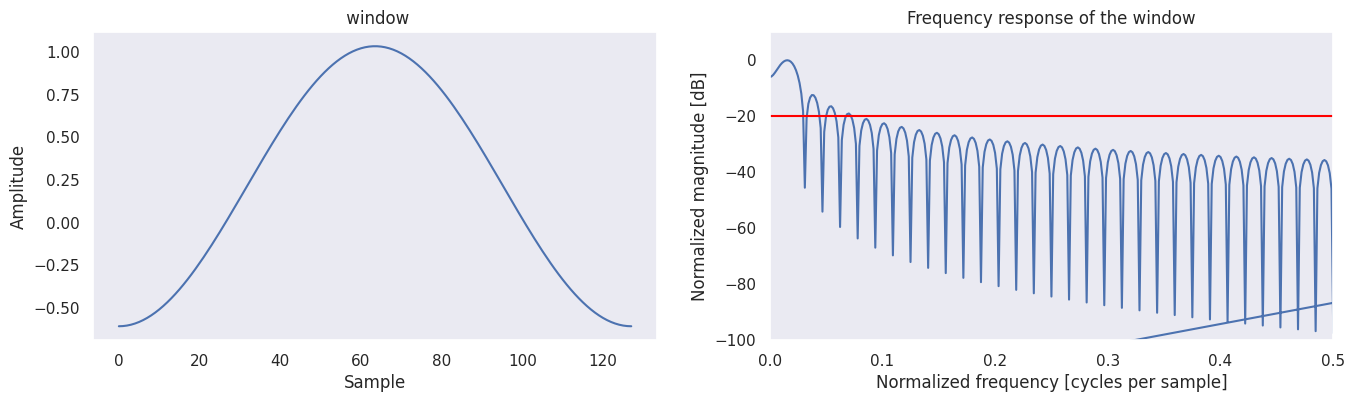

In [100]:
filtviz.visualize_one_window()

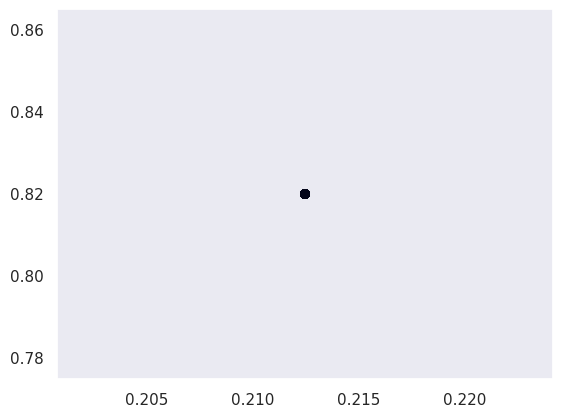

In [101]:
filtviz.visualize_window_params()

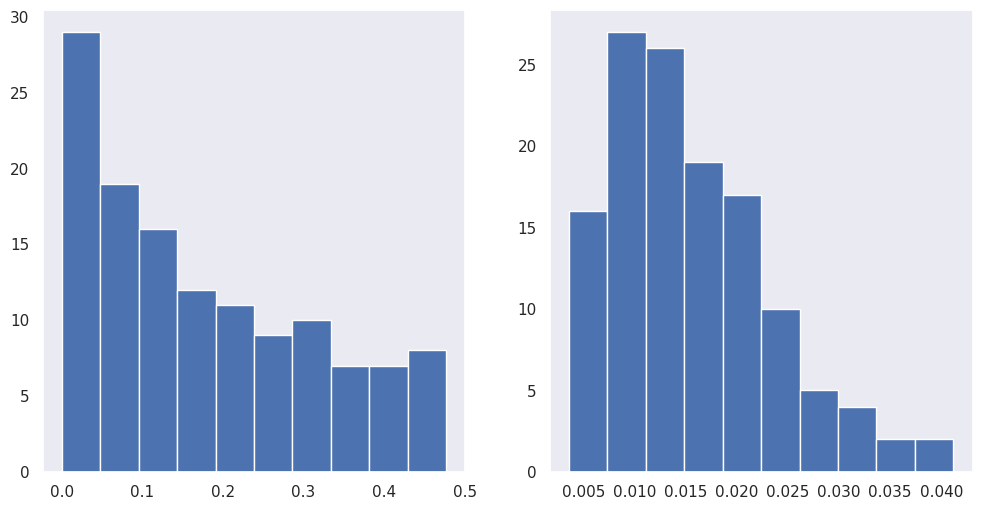

In [102]:
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


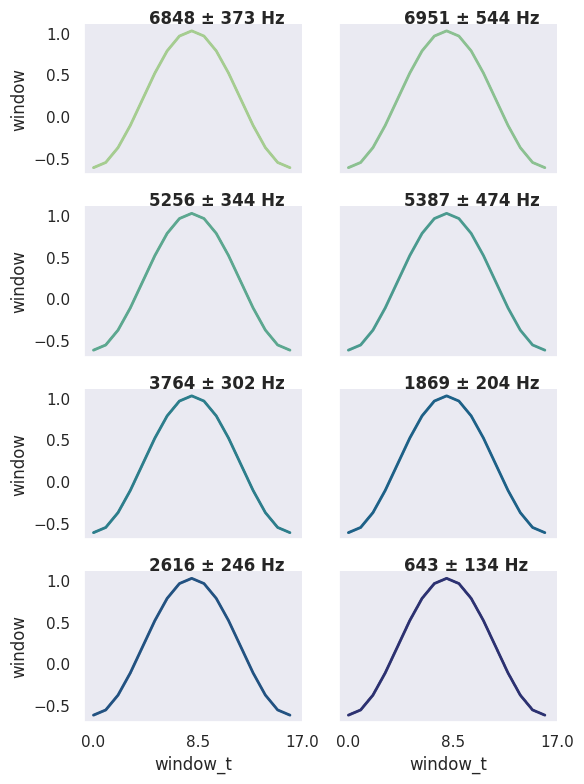

In [116]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


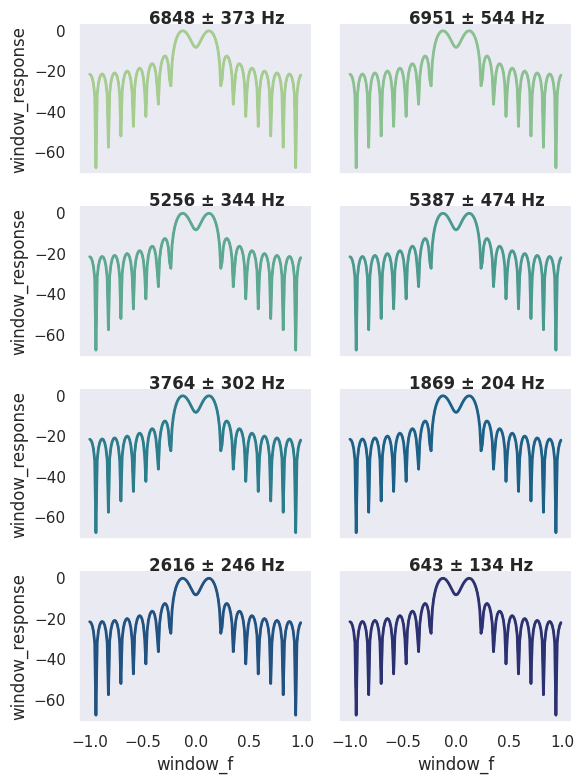

In [118]:
filtviz.visualize_filters(filter_domain='freq')

In [274]:
import traceback
from torchmetrics import ConfusionMatrix
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

In [279]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            # data = transform(data)
            data_length = len(data)
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
    
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * data_length}/{train_loader_length} ({100. * batch_idx / train_loader_length:.0f}%)]\tLoss: {loss.item():.6f}")
    
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data_length} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        # data = transform(data)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{test_loader_length} ({100. * acc:.0f}%)\n")
    return acc

In [258]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [259]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▏                                                                           | 0.02702702702702703/10 [00:00<02:29, 14.99s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.724074


 10%|███████▋                                                                     | 0.9999999999999991/10 [00:12<01:42, 11.36s/it]


Test Epoch: 1	Accuracy: 148/229 (65%)



 10%|████████                                                                      | 1.027027027027026/10 [00:13<01:48, 12.11s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.596779


 20%|███████████████▍                                                             | 1.9999999999999971/10 [00:25<01:31, 11.38s/it]


Test Epoch: 2	Accuracy: 148/229 (65%)



 20%|███████████████▊                                                              | 2.027027027027024/10 [00:25<01:39, 12.47s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.733137


 30%|███████████████████████▍                                                      | 3.000000000000003/10 [00:37<01:19, 11.30s/it]


Test Epoch: 3	Accuracy: 153/229 (67%)



 30%|███████████████████████▎                                                     | 3.0270270270270303/10 [00:38<01:24, 12.14s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.696534


 40%|███████████████████████████████▏                                              | 4.000000000000009/10 [00:50<01:08, 11.34s/it]


Test Epoch: 4	Accuracy: 153/229 (67%)



 40%|███████████████████████████████▍                                              | 4.027027027027036/10 [00:50<01:12, 12.07s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.733845


 50%|███████████████████████████████████████                                       | 5.000000000000015/10 [01:03<00:56, 11.39s/it]


Test Epoch: 5	Accuracy: 154/229 (67%)



 50%|███████████████████████████████████████▏                                      | 5.027027027027042/10 [01:03<01:00, 12.12s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.654589


 60%|██████████████████████████████████████████████▊                               | 6.000000000000021/10 [01:15<00:47, 11.92s/it]


Test Epoch: 6	Accuracy: 148/229 (65%)



 60%|██████████████████████████████████████████████▍                              | 6.0270270270270485/10 [01:16<00:50, 12.62s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.650870


 70%|█████████████████████████████████████████████████████▉                       | 7.0000000000000275/10 [01:28<00:34, 11.41s/it]


Test Epoch: 7	Accuracy: 160/229 (70%)



 70%|██████████████████████████████████████████████████████▊                       | 7.027027027027055/10 [01:28<00:36, 12.13s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.650901


 80%|██████████████████████████████████████████████████████████████▍               | 8.000000000000034/10 [01:41<00:22, 11.43s/it]


Test Epoch: 8	Accuracy: 167/229 (73%)



 80%|███████████████████████████████████████████████████████████████▍               | 8.02702702702706/10 [01:41<00:23, 12.13s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.527053


 90%|██████████████████████████████████████████████████████████████████████▏       | 9.000000000000007/10 [01:53<00:11, 11.71s/it]


Test Epoch: 9	Accuracy: 170/229 (74%)



 90%|██████████████████████████████████████████████████████████████████████▍       | 9.027027027027033/10 [01:54<00:12, 12.53s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.509364


100%|██████████████████████████████████████████████████████████████████████████████▉| 9.99999999999998/10 [02:06<00:00, 12.65s/it]


Test Epoch: 10	Accuracy: 146/229 (64%)



In [277]:
from torchmetrics import ConfusionMatrix
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    # if data.shape != torch.Size([64,1,20000]):
    #         continue
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 146/229 (0.6376)
tensor([[63, 18],
        [65, 83]], device='cuda:0')


In [260]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0702],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0411],
        [0.0634],
        [0.0869],
       

In [261]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-1.0177e-16],
        [-5.8653e-18],
        [ 1.8294e-18],
        [ 3.0136e-18],
        [-3.1231e-18],
        [-1.5820e-17],
        [ 5.5300e-17],
        [-3.5837e-16],
        [ 6.3479e-17],
        [ 3.5295e-18],
        [ 3.3526e-18],
        [ 6.1686e-18],
        [-6.7211e-19],
        [ 1.4412e-18],
        [-3.2583e-19],
        [ 0.0000e+00],
        [-1.3914e-15],
        [-3.1830e-16],
        [-6.7684e-18],
        [-2.9513e-18],
        [ 4.3253e-19],
        [-2.6294e-18],
        [ 1.4791e-18],
        [-9.2075e-18],
        [-8.6191e-17],
        [ 5.7252e-18],
        [ 8.0367e-21],
        [ 2.0108e-17],
        [ 2.3192e-19],
        [-1.6812e-18],
        [ 1.5041e-18],
        [ 0.0000e+00],
        [ 9.2650e-17],
        [ 6.6889e-19],
        [-4.2398e-18],
        [ 2.0980e-14],
        [-3.2770e-16],
        [-6.6588e-16],
        [-7.2345e-17],
        [-1.7460e-18],
        [ 1.9236e-18],
        [-4.3142e-18],
        [-3

[None, None, None]

In [262]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

Time domain: Filters' shapes vary by frequency bins


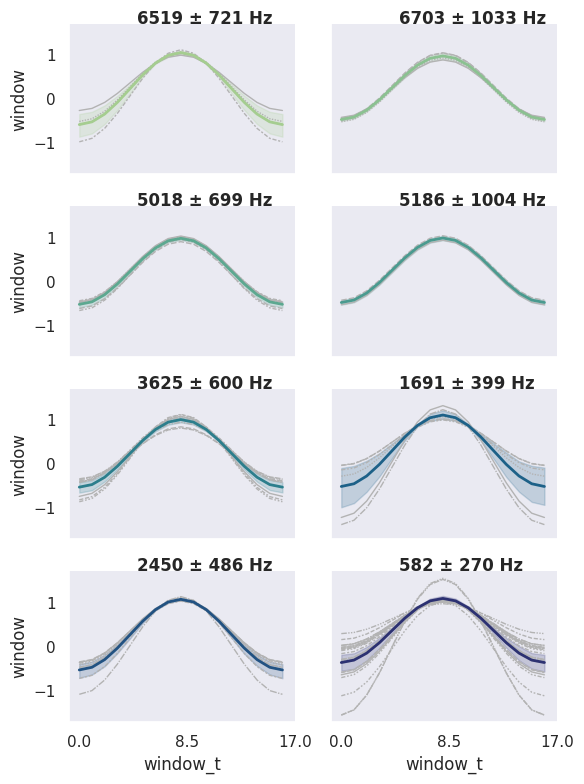

In [263]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


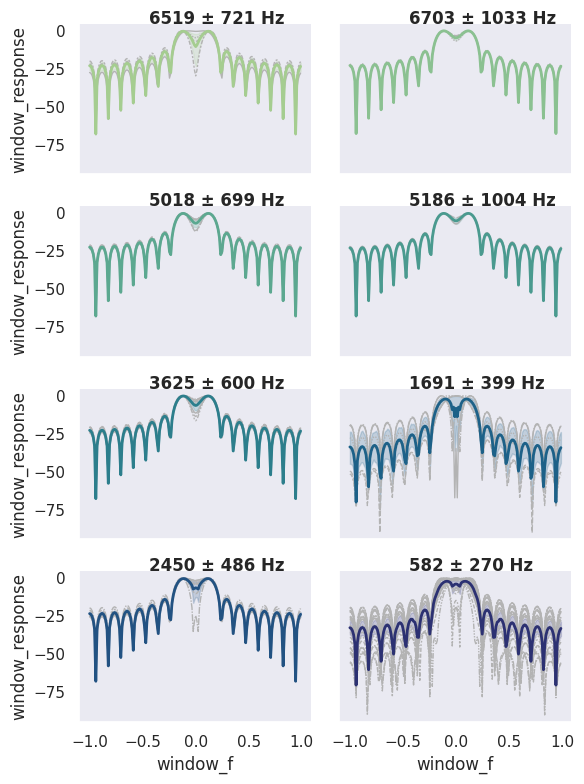

In [264]:
filtviz.visualize_filters(filter_domain='freq')

In [265]:
layer2 = model.fe_blocks.blocks[1].layer
downsample_factor = model.config.fe.stride[0]

In [267]:
[print(p.grad) for p in layer2.parameters() if p.requires_grad]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-7.1242e-20,  5.5303e-19,  3.3740e-19,  ...,  3.7146e-19,
          4.0661e-19,  3.3096e-19],
        [ 6.6083e-19,  7.3609e-19,  2.2066e-19,  ...,  1.3526e-19,
          2.1478e-19,  7.8065e-20],
        ...,
        [ 2.1721e-23,  1.2538e-23,  4.3297e-24,  ...,  2.4791e-24,
         -4.5258e-24,  1.0667e-23],
        [ 1.2158e-21,  2.2574e-21,  3.4179e-22,  ...,  5.3723e-21,
          4.0907e-21,  5.8095e-21],
        [ 8.4367e-21, -9.8183e-21, -6.7438e-21,  ..., -3.7221e-21,
         -9.3457e-21, -7.7214e-22]], device='cuda:0')
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 6.7832e-20,  4.0290e-19,  4.4773e-20,  ..., -1.3304e-19,
         -1.0850e-19, -1.5340e-19],
        [ 9.0574e-21,  6.9817e-21,  4.5491e-21,  ...,  3.9176e-21,
          5.3411e-21,  2.9853e-21],
        ...,
        [-3.4432e-24, -6.9460

[None, None, None]

In [271]:
filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = sr // downsample_factor
)

Time domain: Filters' shapes vary by frequency bins


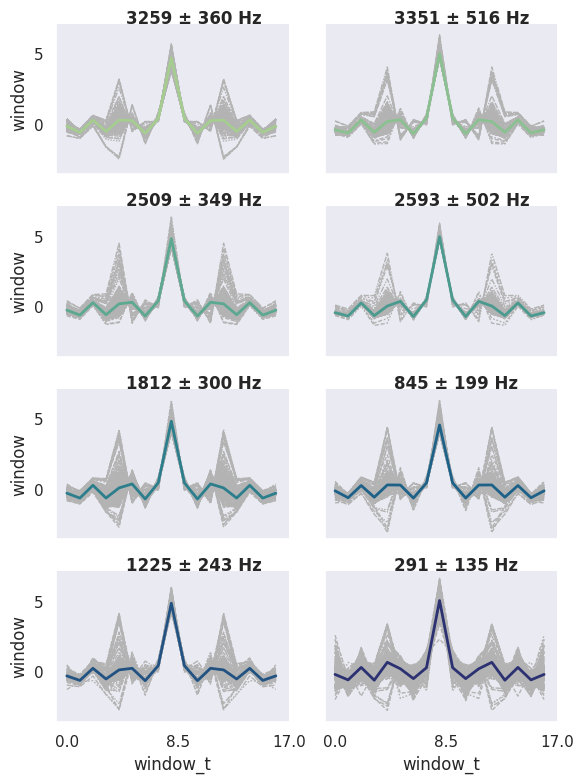

In [272]:
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


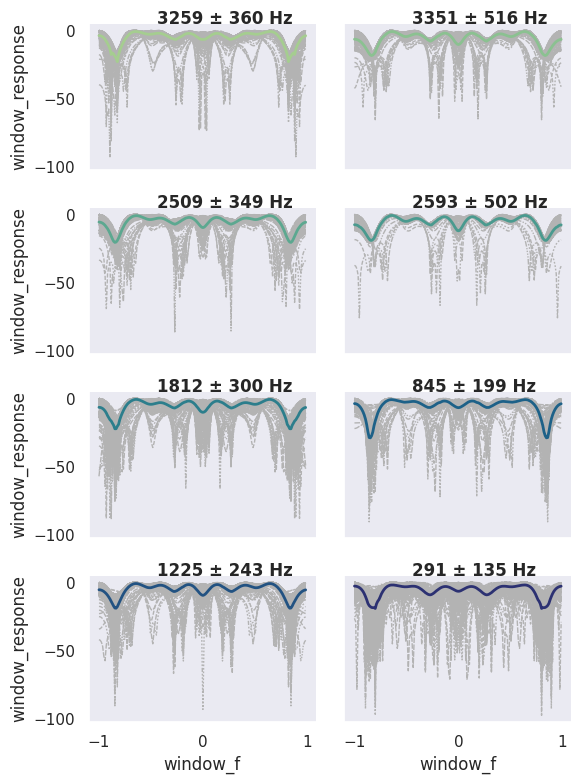

In [273]:
filtviz2.visualize_filters(filter_domain='freq')

In [278]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

In [280]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1 + n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02702702702702703/50 [00:00<12:13, 14.69s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.572669


  2%|█▌                                                                           | 0.9999999999999991/50 [00:13<09:39, 11.83s/it]


Test Epoch: 11	Accuracy: 170/229 (74%)



  2%|█▌                                                                            | 1.027027027027026/50 [00:13<10:18, 12.63s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.484947


  4%|███                                                                          | 1.9999999999999971/50 [00:27<10:14, 12.81s/it]


Test Epoch: 12	Accuracy: 169/229 (74%)



  4%|███▏                                                                          | 2.027027027027024/50 [00:27<11:07, 13.91s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.628307


  6%|████▋                                                                         | 3.000000000000003/50 [00:40<09:22, 11.96s/it]


Test Epoch: 13	Accuracy: 170/229 (74%)



  6%|████▋                                                                        | 3.0270270270270303/50 [00:40<10:07, 12.93s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.359071


  8%|██████▏                                                                       | 4.000000000000009/50 [00:53<09:03, 11.81s/it]


Test Epoch: 14	Accuracy: 179/229 (78%)



  8%|██████▎                                                                       | 4.027027027027036/50 [00:54<09:53, 12.91s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.462891


 10%|███████▊                                                                      | 5.000000000000015/50 [01:06<10:10, 13.57s/it]


Test Epoch: 15	Accuracy: 180/229 (79%)



 10%|███████▊                                                                      | 5.027027027027042/50 [01:07<10:18, 13.75s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.503699


 12%|█████████▎                                                                    | 6.000000000000021/50 [01:20<08:44, 11.91s/it]


Test Epoch: 16	Accuracy: 151/229 (66%)



 12%|█████████▎                                                                   | 6.0270270270270485/50 [01:20<09:22, 12.79s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.514662


 14%|██████████▊                                                                  | 7.0000000000000275/50 [01:33<08:28, 11.83s/it]


Test Epoch: 17	Accuracy: 165/229 (72%)



 14%|██████████▉                                                                   | 7.027027027027055/50 [01:33<09:04, 12.67s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.473340


 16%|████████████▍                                                                 | 8.000000000000034/50 [01:46<08:30, 12.16s/it]


Test Epoch: 18	Accuracy: 169/229 (74%)



 16%|████████████▋                                                                  | 8.02702702702706/50 [01:47<09:01, 12.91s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.681769


 18%|██████████████                                                                | 9.000000000000007/50 [01:59<08:03, 11.78s/it]


Test Epoch: 19	Accuracy: 178/229 (78%)



 18%|██████████████                                                                | 9.027027027027033/50 [02:00<08:34, 12.56s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.420734


 20%|███████████████▊                                                               | 9.99999999999998/50 [02:12<07:51, 11.80s/it]


Test Epoch: 20	Accuracy: 182/229 (79%)



 20%|███████████████▍                                                             | 10.027027027027007/50 [02:13<08:22, 12.58s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.554378


 22%|████████████████▉                                                            | 10.999999999999954/50 [02:25<07:39, 11.79s/it]


Test Epoch: 21	Accuracy: 171/229 (75%)



 22%|█████████████████▏                                                            | 11.02702702702698/50 [02:26<08:21, 12.86s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.482062


 24%|██████████████████▍                                                          | 11.999999999999927/50 [02:39<07:41, 12.15s/it]


Test Epoch: 22	Accuracy: 174/229 (76%)



 24%|██████████████████▌                                                          | 12.027027027026953/50 [02:39<08:19, 13.15s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.602344


 26%|████████████████████▌                                                          | 12.9999999999999/50 [02:52<07:19, 11.88s/it]


Test Epoch: 23	Accuracy: 166/229 (72%)



 26%|████████████████████                                                         | 13.027027027026927/50 [02:52<07:59, 12.97s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.486427


 28%|█████████████████████▌                                                       | 13.999999999999874/50 [03:05<07:09, 11.92s/it]


Test Epoch: 24	Accuracy: 168/229 (73%)



 28%|██████████████████████▏                                                        | 14.0270270270269/50 [03:05<07:42, 12.85s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.569093


 30%|███████████████████████                                                      | 14.999999999999847/50 [03:18<06:53, 11.83s/it]


Test Epoch: 25	Accuracy: 152/229 (66%)



 30%|███████████████████████▏                                                     | 15.027027027026874/50 [03:19<07:21, 12.61s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.644188


 32%|████████████████████████▉                                                     | 15.99999999999982/50 [03:31<06:43, 11.86s/it]


Test Epoch: 26	Accuracy: 174/229 (76%)



 32%|████████████████████████▋                                                    | 16.027027027026847/50 [03:32<07:06, 12.56s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.595348


 34%|██████████████████████████▏                                                  | 16.999999999999858/50 [03:45<06:29, 11.81s/it]


Test Epoch: 27	Accuracy: 177/229 (77%)



 34%|██████████████████████████▏                                                  | 17.027027027026886/50 [03:46<06:54, 12.58s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.474775


 36%|███████████████████████████▋                                                 | 17.999999999999897/50 [03:58<06:27, 12.12s/it]


Test Epoch: 28	Accuracy: 178/229 (78%)



 36%|███████████████████████████▊                                                 | 18.027027027026925/50 [03:59<06:49, 12.81s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.540671


 38%|█████████████████████████████▎                                               | 18.999999999999936/50 [04:11<06:07, 11.85s/it]


Test Epoch: 29	Accuracy: 180/229 (79%)



 38%|█████████████████████████████▎                                               | 19.027027027026964/50 [04:12<06:30, 12.60s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.400308


 40%|██████████████████████████████▊                                              | 19.999999999999975/50 [04:24<05:53, 11.78s/it]


Test Epoch: 30	Accuracy: 176/229 (77%)



 40%|██████████████████████████████▊                                              | 20.027027027027003/50 [04:25<06:23, 12.80s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.553825


 42%|████████████████████████████████▎                                            | 21.000000000000014/50 [04:37<05:43, 11.85s/it]


Test Epoch: 31	Accuracy: 179/229 (78%)



 42%|████████████████████████████████▍                                            | 21.027027027027042/50 [04:38<06:05, 12.63s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.460517


 44%|█████████████████████████████████▉                                           | 22.000000000000053/50 [04:50<05:32, 11.89s/it]


Test Epoch: 32	Accuracy: 164/229 (72%)



 44%|██████████████████████████████████▎                                           | 22.02702702702708/50 [04:51<05:51, 12.55s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.583238


 46%|███████████████████████████████████▍                                         | 23.000000000000092/50 [05:03<05:19, 11.82s/it]


Test Epoch: 33	Accuracy: 174/229 (76%)



 46%|███████████████████████████████████▉                                          | 23.02702702702712/50 [05:04<05:41, 12.66s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.530028


 48%|█████████████████████████████████████▍                                        | 24.00000000000013/50 [05:16<05:03, 11.68s/it]


Test Epoch: 34	Accuracy: 173/229 (76%)



 48%|█████████████████████████████████████▍                                        | 24.02702702702716/50 [05:17<05:23, 12.47s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.446905


 50%|███████████████████████████████████████                                       | 25.00000000000017/50 [05:29<05:01, 12.07s/it]


Test Epoch: 35	Accuracy: 178/229 (78%)



 50%|███████████████████████████████████████▌                                       | 25.0270270270272/50 [05:30<05:16, 12.66s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.515240


 52%|████████████████████████████████████████▌                                     | 26.00000000000021/50 [05:42<04:42, 11.79s/it]


Test Epoch: 36	Accuracy: 145/229 (63%)



 52%|████████████████████████████████████████                                     | 26.027027027027238/50 [05:43<05:02, 12.62s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.699511


 54%|██████████████████████████████████████████                                    | 27.00000000000025/50 [05:55<04:28, 11.69s/it]


Test Epoch: 37	Accuracy: 175/229 (76%)



 54%|█████████████████████████████████████████▌                                   | 27.027027027027277/50 [05:56<04:49, 12.59s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.454512


 56%|███████████████████████████████████████████                                  | 28.000000000000288/50 [06:08<04:21, 11.91s/it]


Test Epoch: 38	Accuracy: 165/229 (72%)



 56%|███████████████████████████████████████████▏                                 | 28.027027027027316/50 [06:09<04:38, 12.70s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.603166


 58%|████████████████████████████████████████████▋                                | 29.000000000000327/50 [06:21<04:05, 11.70s/it]


Test Epoch: 39	Accuracy: 178/229 (78%)



 58%|████████████████████████████████████████████▋                                | 29.027027027027355/50 [06:22<04:21, 12.48s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.615792


 60%|██████████████████████████████████████████████▏                              | 30.000000000000366/50 [06:34<03:56, 11.81s/it]


Test Epoch: 40	Accuracy: 158/229 (69%)



 60%|██████████████████████████████████████████████▏                              | 30.027027027027394/50 [06:35<04:13, 12.70s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.465918


 62%|███████████████████████████████████████████████▋                             | 31.000000000000405/50 [06:47<03:44, 11.82s/it]


Test Epoch: 41	Accuracy: 178/229 (78%)



 62%|███████████████████████████████████████████████▊                             | 31.027027027027433/50 [06:48<04:00, 12.68s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.421986


 64%|█████████████████████████████████████████████████▉                            | 32.00000000000044/50 [07:00<03:34, 11.89s/it]


Test Epoch: 42	Accuracy: 179/229 (78%)



 64%|█████████████████████████████████████████████████▎                           | 32.027027027027465/50 [07:01<03:45, 12.56s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.538607


 66%|███████████████████████████████████████████████████▍                          | 33.00000000000035/50 [07:13<03:21, 11.87s/it]


Test Epoch: 43	Accuracy: 160/229 (70%)



 66%|███████████████████████████████████████████████████▌                          | 33.02702702702737/50 [07:14<03:33, 12.58s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.671481


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000256/50 [07:26<03:12, 12.01s/it]


Test Epoch: 44	Accuracy: 154/229 (67%)



 68%|█████████████████████████████████████████████████████                         | 34.02702702702728/50 [07:27<03:22, 12.70s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.548790


 70%|██████████████████████████████████████████████████████▌                       | 35.00000000000016/50 [07:39<02:58, 11.88s/it]


Test Epoch: 45	Accuracy: 168/229 (73%)



 70%|██████████████████████████████████████████████████████▋                       | 35.02702702702719/50 [07:40<03:06, 12.48s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.419807


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000007/50 [07:52<02:46, 11.91s/it]


Test Epoch: 46	Accuracy: 175/229 (76%)



 72%|███████████████████████████████████████████████████████▍                     | 36.027027027027096/50 [07:53<02:55, 12.58s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.523291


 74%|█████████████████████████████████████████████████████████▋                    | 36.99999999999998/50 [08:05<02:35, 11.95s/it]


Test Epoch: 47	Accuracy: 181/229 (79%)



 74%|███████████████████████████████████████████████████████████▏                    | 37.027027027027/50 [08:06<02:44, 12.64s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.540917


 76%|██████████████████████████████████████████████████████████▌                  | 37.999999999999886/50 [08:18<02:23, 11.94s/it]


Test Epoch: 48	Accuracy: 173/229 (76%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.02702702702691/50 [08:19<02:31, 12.69s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.507298


 78%|████████████████████████████████████████████████████████████                 | 38.999999999999794/50 [08:31<02:08, 11.68s/it]


Test Epoch: 49	Accuracy: 179/229 (78%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02702702702682/50 [08:32<02:16, 12.44s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.476467


 80%|███████████████████████████████████████████████████████████████▏               | 39.9999999999997/50 [08:44<01:58, 11.80s/it]


Test Epoch: 50	Accuracy: 163/229 (71%)



 80%|█████████████████████████████████████████████████████████████▋               | 40.027027027026726/50 [08:45<02:06, 12.64s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.600561


 82%|███████████████████████████████████████████████████████████████▉              | 40.99999999999961/50 [08:57<01:48, 12.00s/it]


Test Epoch: 51	Accuracy: 174/229 (76%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.027027027026634/50 [08:58<01:53, 12.68s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.823852


 84%|█████████████████████████████████████████████████████████████████▌            | 41.99999999999952/50 [09:11<01:36, 12.05s/it]


Test Epoch: 52	Accuracy: 163/229 (71%)



 84%|█████████████████████████████████████████████████████████████████▌            | 42.02702702702654/50 [09:11<01:42, 12.84s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.512738


 86%|██████████████████████████████████████████████████████████████████▏          | 42.999999999999424/50 [09:24<01:22, 11.84s/it]


Test Epoch: 53	Accuracy: 169/229 (74%)



 86%|███████████████████████████████████████████████████████████████████           | 43.02702702702645/50 [09:24<01:28, 12.65s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.400314


 88%|████████████████████████████████████████████████████████████████████▋         | 43.99999999999933/50 [09:37<01:11, 11.89s/it]


Test Epoch: 54	Accuracy: 181/229 (79%)



 88%|████████████████████████████████████████████████████████████████████▋         | 44.02702702702636/50 [09:37<01:15, 12.62s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.540838


 90%|██████████████████████████████████████████████████████████████████████▏       | 44.99999999999924/50 [09:50<01:00, 12.14s/it]


Test Epoch: 55	Accuracy: 177/229 (77%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 45.027027027026264/50 [09:50<01:03, 12.75s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.493378


 92%|███████████████████████████████████████████████████████████████████████▊      | 45.99999999999915/50 [10:03<00:48, 12.09s/it]


Test Epoch: 56	Accuracy: 175/229 (76%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.02702702702617/50 [10:04<00:50, 12.70s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.523072


 94%|████████████████████████████████████████████████████████████████████████▍    | 46.999999999999055/50 [10:17<00:35, 11.98s/it]


Test Epoch: 57	Accuracy: 159/229 (69%)



 94%|█████████████████████████████████████████████████████████████████████████▎    | 47.02702702702608/50 [10:17<00:37, 12.75s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.529131


 96%|██████████████████████████████████████████████████████████████████████████▉   | 47.99999999999896/50 [10:30<00:23, 11.73s/it]


Test Epoch: 58	Accuracy: 172/229 (75%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02702702702599/50 [10:30<00:24, 12.47s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.548644


 98%|████████████████████████████████████████████████████████████████████████████▍ | 48.99999999999887/50 [10:43<00:11, 11.88s/it]


Test Epoch: 59	Accuracy: 164/229 (72%)



 98%|███████████████████████████████████████████████████████████████████████████▌ | 49.027027027025895/50 [10:43<00:12, 12.65s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.494030


100%|█████████████████████████████████████████████████████████████████████████████▉| 49.99999999999878/50 [10:56<00:00, 13.14s/it]


Test Epoch: 60	Accuracy: 178/229 (78%)



In [281]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    # if data.shape != torch.Size([64,1,20000]):
    #         continue
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 178/229 (0.7773)
tensor([[ 33,  48],
        [  3, 145]], device='cuda:0')


In [283]:
from matplotlib import pyplot as plt

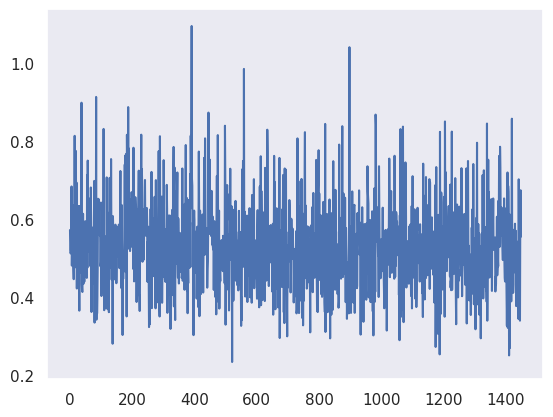

In [284]:
plt.plot(train_losses)

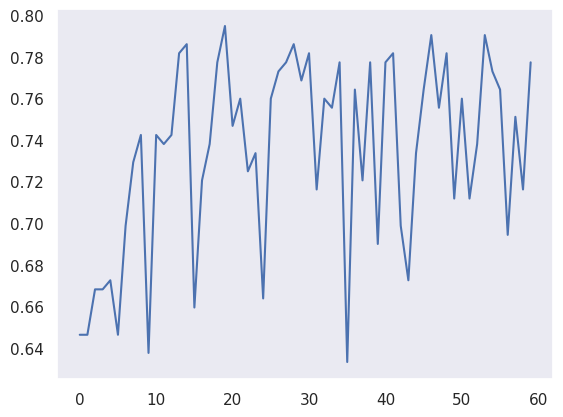

In [286]:
plt.plot(test_accuracy)

In [282]:
layer = model.fe_blocks.blocks[0].layer
visualize_model.print_parameters(layer)

('lowcut_bands', Parameter containing:
tensor([[0.0000],
        [0.0075],
        [0.0162],
        [0.0264],
        [0.0384],
        [0.0524],
        [0.0688],
        [0.0880],
        [0.1105],
        [0.1368],
        [0.1676],
        [0.2036],
        [0.2458],
        [0.2952],
        [0.3531],
        [0.4208],
        [0.0000],
        [0.0111],
        [0.0235],
        [0.0375],
        [0.0534],
        [0.0712],
        [0.0912],
        [0.1138],
        [0.1392],
        [0.1679],
        [0.2002],
        [0.2365],
        [0.2775],
        [0.3236],
        [0.3756],
        [0.4341],
        [0.0000],
        [0.0154],
        [0.0322],
        [0.0504],
        [0.0703],
        [0.0918],
        [0.1153],
        [0.1409],
        [0.1687],
        [0.1989],
        [0.2319],
        [0.2677],
        [0.3067],
        [0.3491],
        [0.3952],
        [0.4454],
        [0.0000],
        [0.0200],
        [0.0410],
        [0.0634],
        [0.0869],
       

In [287]:
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-1.0617e-16],
        [-6.8176e-18],
        [ 3.9475e-16],
        [-9.4244e-19],
        [ 1.2716e-15],
        [-3.1595e-17],
        [-1.2443e-17],
        [ 1.0915e-14],
        [-9.0628e-17],
        [-4.1557e-18],
        [ 8.3253e-17],
        [-2.7211e-19],
        [-3.2166e-19],
        [-5.7562e-18],
        [ 2.6222e-20],
        [ 0.0000e+00],
        [ 3.9105e-14],
        [ 7.2124e-16],
        [ 9.5420e-19],
        [ 6.3301e-19],
        [-1.1160e-17],
        [-3.6555e-19],
        [ 3.2279e-19],
        [-1.9506e-17],
        [ 3.0108e-16],
        [-4.6217e-18],
        [ 1.7272e-19],
        [ 4.6426e-18],
        [ 1.4114e-19],
        [-5.7540e-18],
        [-6.0551e-19],
        [ 0.0000e+00],
        [ 5.3486e-16],
        [ 2.0737e-22],
        [-2.1181e-15],
        [ 1.3454e-13],
        [-1.3208e-16],
        [ 3.2661e-16],
        [ 2.1172e-15],
        [ 3.9586e-33],
        [ 6.7308e-18],
        [ 8.5366e-19],
        [-3

[None, None, None]

In [288]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

Time domain: Filters' shapes vary by frequency bins


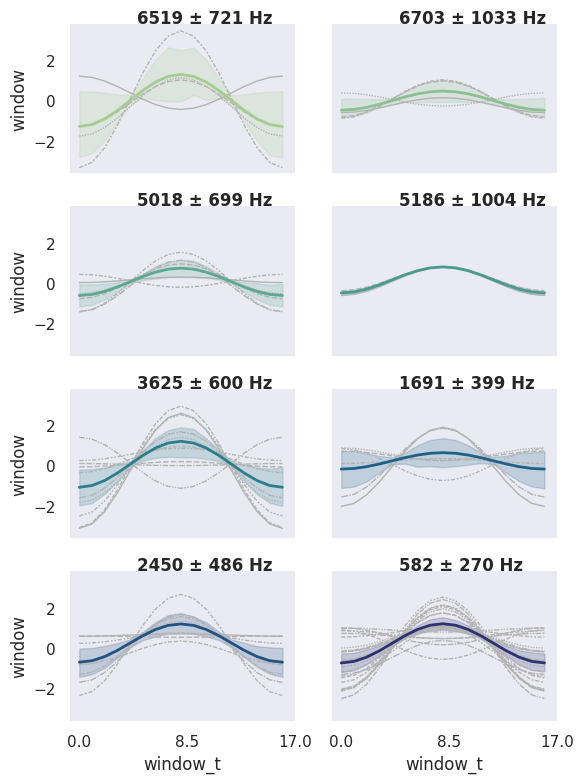

In [289]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


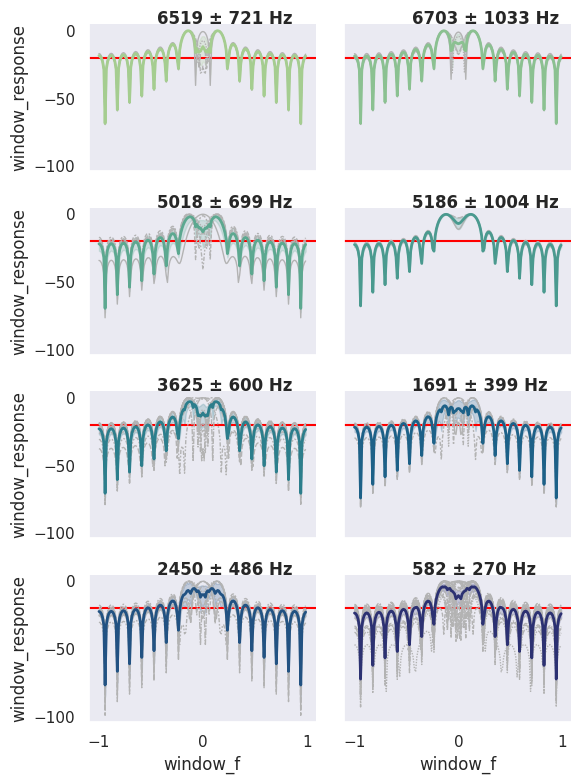

In [290]:
filtviz.visualize_filters(filter_domain='freq')

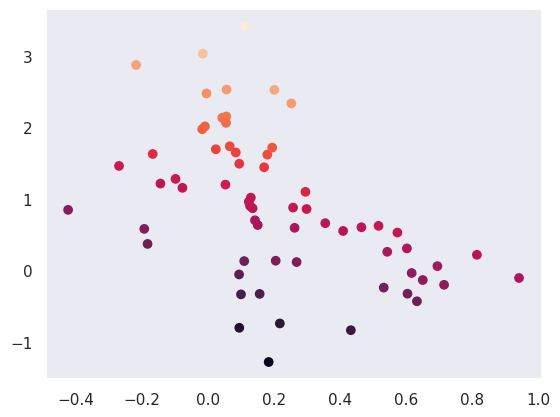

In [296]:
filtviz.visualize_window_params()

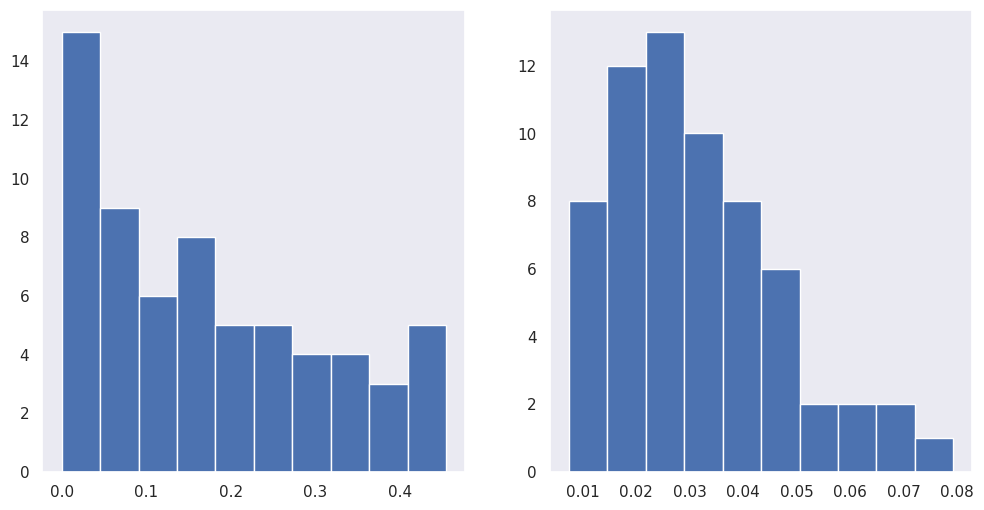

In [297]:
filtviz.visualize_bands()

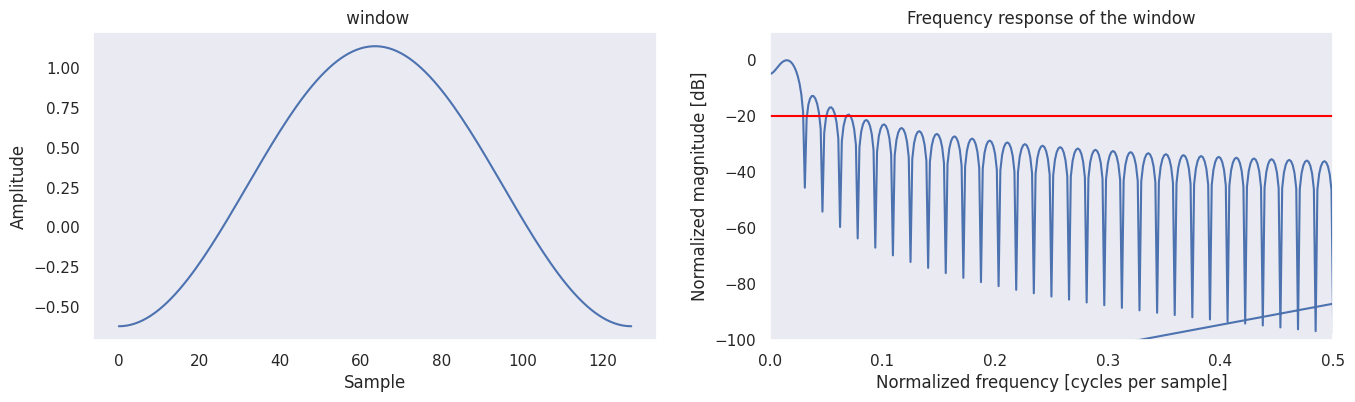

In [298]:
filtviz.visualize_one_window()

In [291]:
layer2 = model.fe_blocks.blocks[1].layer
downsample_factor = model.config.fe.stride[0]

In [292]:
[print(p.grad) for p in layer2.parameters() if p.requires_grad]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.1107e-17,  1.1164e-17,  3.2236e-18,  ..., -2.9728e-18,
         -8.1300e-18, -1.0932e-17],
        [ 4.1264e-20,  1.1871e-19,  9.1436e-20,  ..., -1.3565e-20,
         -7.2235e-20,  1.3059e-19],
        ...,
        [-1.7609e-22, -4.6339e-23, -9.4302e-23,  ..., -6.9978e-25,
         -2.1181e-23, -1.2635e-22],
        [-1.1295e-20,  1.4738e-20,  4.5038e-22,  ..., -4.3610e-22,
          7.0403e-22,  4.4280e-21],
        [-4.4540e-21,  5.4786e-20,  4.8064e-21,  ...,  2.1334e-20,
          3.2308e-20, -3.2553e-20]], device='cuda:0')
tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.9838e-18,  8.9029e-18,  7.7212e-19,  ..., -1.3667e-18,
         -7.9822e-19, -2.8249e-18],
        [-1.9321e-22,  1.5470e-21,  1.2653e-21,  ..., -2.0458e-22,
          1.7273e-23,  1.9850e-21],
        ...,
        [ 1.9271e-23,  5.9959

[None, None, None]

In [293]:
filtviz2 = visualize_model.FilterVisualizer(
    lowcut_bands = layer2.lowcut_bands, 
    bandwidths = layer2.bandwidths,
    window_params = layer2.window_params, 
    window_length = 64,
    sample_rate = sr // downsample_factor
)

Time domain: Filters' shapes vary by frequency bins


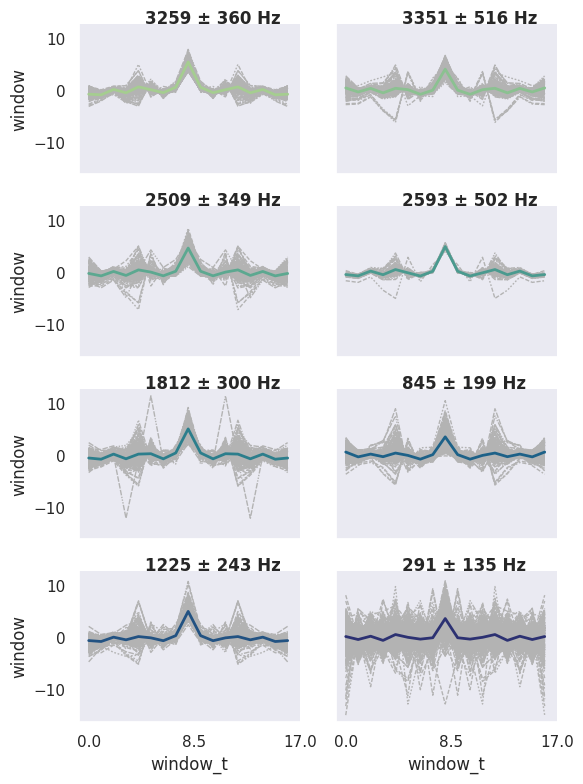

In [294]:
filtviz2.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


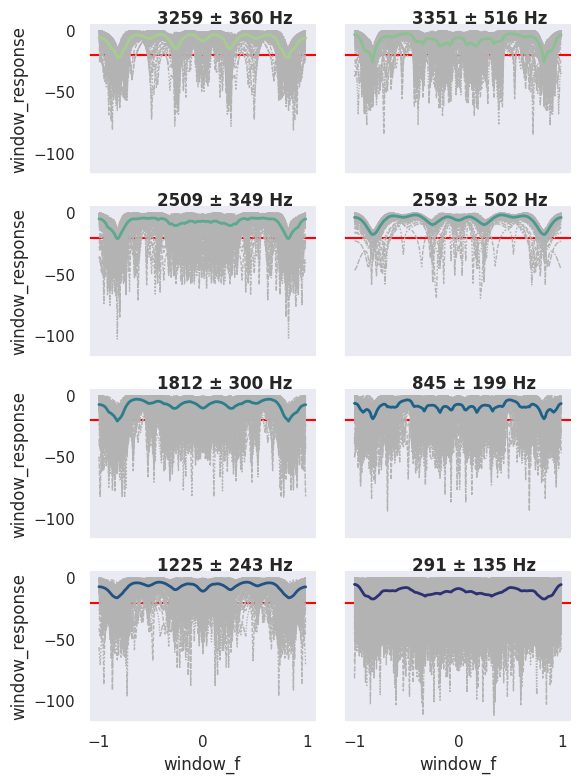

In [295]:
filtviz2.visualize_filters(filter_domain='freq')

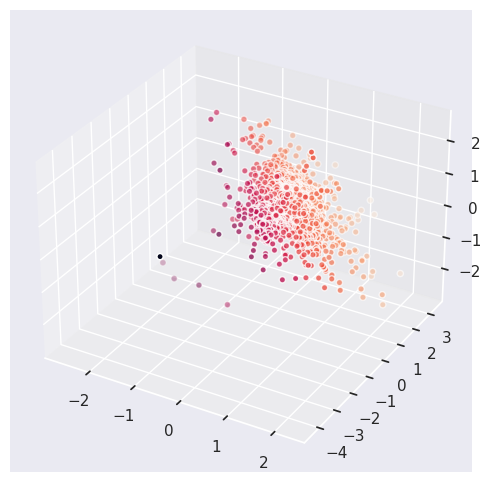

In [299]:
filtviz2.visualize_window_params()

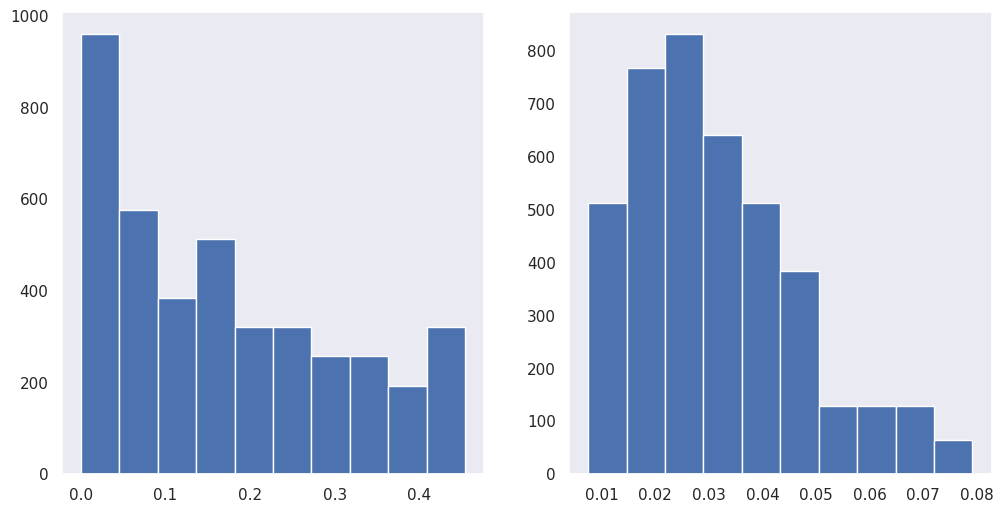

In [300]:
filtviz2.visualize_bands()

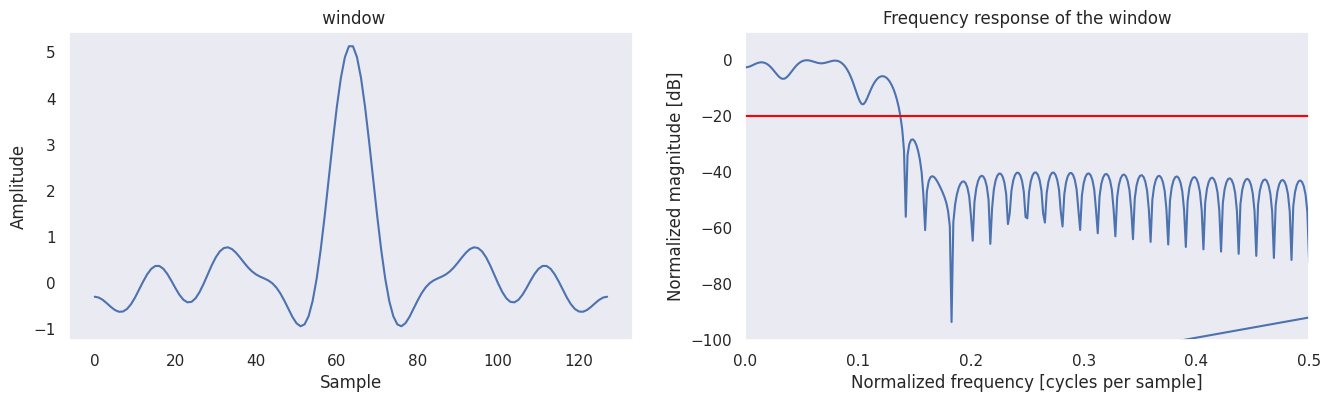

In [301]:
filtviz2.visualize_one_window()

In [302]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)

In [303]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1 + n_epoch + n_epoch2, n_epoch3 + n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02702702702702703/50 [00:00<29:26, 35.36s/it]

Train Epoch: 61 [0/913 (0%)]	Loss: 0.387679


  2%|█▌                                                                           | 0.9999999999999991/50 [00:13<10:05, 12.35s/it]


Test Epoch: 61	Accuracy: 182/229 (79%)



  2%|█▌                                                                            | 1.027027027027026/50 [00:14<10:34, 12.96s/it]

Train Epoch: 62 [0/913 (0%)]	Loss: 0.445203


  4%|███                                                                          | 1.9999999999999971/50 [00:27<09:45, 12.20s/it]


Test Epoch: 62	Accuracy: 178/229 (78%)



  4%|███▏                                                                          | 2.027027027027024/50 [00:27<10:22, 12.98s/it]

Train Epoch: 63 [0/913 (0%)]	Loss: 0.448813


  6%|████▋                                                                         | 3.000000000000003/50 [00:40<09:29, 12.11s/it]


Test Epoch: 63	Accuracy: 177/229 (77%)



  6%|████▋                                                                        | 3.0270270270270303/50 [00:40<10:08, 12.96s/it]

Train Epoch: 64 [0/913 (0%)]	Loss: 0.524564


  8%|██████▏                                                                       | 4.000000000000009/50 [00:53<09:13, 12.03s/it]


Test Epoch: 64	Accuracy: 183/229 (80%)



  8%|██████▎                                                                       | 4.027027027027036/50 [00:54<09:42, 12.68s/it]

Train Epoch: 65 [0/913 (0%)]	Loss: 0.630292


 10%|███████▊                                                                      | 5.000000000000015/50 [01:07<09:26, 12.58s/it]


Test Epoch: 65	Accuracy: 179/229 (78%)



 10%|███████▊                                                                      | 5.027027027027042/50 [01:07<09:47, 13.07s/it]

Train Epoch: 66 [0/913 (0%)]	Loss: 0.506359


 12%|█████████▎                                                                    | 6.000000000000021/50 [01:21<08:55, 12.18s/it]


Test Epoch: 66	Accuracy: 176/229 (77%)



 12%|█████████▎                                                                   | 6.0270270270270485/50 [01:21<09:34, 13.07s/it]

Train Epoch: 67 [0/913 (0%)]	Loss: 0.497688


 14%|██████████▊                                                                  | 7.0000000000000275/50 [01:34<08:40, 12.10s/it]


Test Epoch: 67	Accuracy: 183/229 (80%)



 14%|██████████▉                                                                   | 7.027027027027055/50 [01:35<09:10, 12.82s/it]

Train Epoch: 68 [0/913 (0%)]	Loss: 0.283886


 16%|████████████▍                                                                 | 8.000000000000034/50 [01:48<08:59, 12.83s/it]


Test Epoch: 68	Accuracy: 179/229 (78%)



 16%|████████████▋                                                                  | 8.02702702702706/50 [01:48<09:24, 13.45s/it]

Train Epoch: 69 [0/913 (0%)]	Loss: 0.472244


 18%|██████████████                                                                | 9.000000000000007/50 [02:01<08:20, 12.21s/it]


Test Epoch: 69	Accuracy: 180/229 (79%)



 18%|██████████████                                                                | 9.027027027027033/50 [02:02<08:50, 12.95s/it]

Train Epoch: 70 [0/913 (0%)]	Loss: 0.577370


 20%|███████████████▊                                                               | 9.99999999999998/50 [02:14<07:57, 11.94s/it]


Test Epoch: 70	Accuracy: 183/229 (80%)



 20%|███████████████▍                                                             | 10.027027027027007/50 [02:15<08:30, 12.78s/it]

Train Epoch: 71 [0/913 (0%)]	Loss: 0.581262


 22%|████████████████▉                                                            | 10.999999999999954/50 [02:28<07:48, 12.01s/it]


Test Epoch: 71	Accuracy: 178/229 (78%)



 22%|█████████████████▏                                                            | 11.02702702702698/50 [02:28<08:39, 13.33s/it]

Train Epoch: 72 [0/913 (0%)]	Loss: 0.444465


 24%|██████████████████▍                                                          | 11.999999999999927/50 [02:42<07:41, 12.13s/it]


Test Epoch: 72	Accuracy: 176/229 (77%)



 24%|██████████████████▌                                                          | 12.027027027026953/50 [02:42<08:12, 12.96s/it]

Train Epoch: 73 [0/913 (0%)]	Loss: 0.568762


 26%|████████████████████▌                                                          | 12.9999999999999/50 [02:55<07:23, 11.99s/it]


Test Epoch: 73	Accuracy: 171/229 (75%)



 26%|████████████████████                                                         | 13.027027027026927/50 [02:55<07:50, 12.72s/it]

Train Epoch: 74 [0/913 (0%)]	Loss: 0.413291


 28%|█████████████████████▌                                                       | 13.999999999999874/50 [03:08<07:14, 12.06s/it]


Test Epoch: 74	Accuracy: 180/229 (79%)



 28%|██████████████████████▏                                                        | 14.0270270270269/50 [03:09<07:51, 13.11s/it]

Train Epoch: 75 [0/913 (0%)]	Loss: 0.318004


 30%|███████████████████████                                                      | 14.999999999999847/50 [03:21<06:55, 11.88s/it]


Test Epoch: 75	Accuracy: 179/229 (78%)



 30%|███████████████████████▏                                                     | 15.027027027026874/50 [03:22<07:25, 12.75s/it]

Train Epoch: 76 [0/913 (0%)]	Loss: 0.522985


 32%|████████████████████████▉                                                     | 15.99999999999982/50 [03:35<07:22, 13.00s/it]


Test Epoch: 76	Accuracy: 182/229 (79%)



 32%|████████████████████████▋                                                    | 16.027027027026847/50 [03:35<07:33, 13.36s/it]

Train Epoch: 77 [0/913 (0%)]	Loss: 0.424598


 34%|██████████████████████████▏                                                  | 16.999999999999858/50 [03:48<06:32, 11.89s/it]


Test Epoch: 77	Accuracy: 166/229 (72%)



 34%|██████████████████████████▏                                                  | 17.027027027026886/50 [03:48<06:55, 12.61s/it]

Train Epoch: 78 [0/913 (0%)]	Loss: 0.393037


 36%|███████████████████████████▋                                                 | 17.999999999999897/50 [04:01<06:29, 12.17s/it]


Test Epoch: 78	Accuracy: 176/229 (77%)



 36%|███████████████████████████▊                                                 | 18.027027027026925/50 [04:01<06:49, 12.81s/it]

Train Epoch: 79 [0/913 (0%)]	Loss: 0.504863


 38%|█████████████████████████████▎                                               | 18.999999999999936/50 [04:14<06:09, 11.93s/it]


Test Epoch: 79	Accuracy: 183/229 (80%)



 38%|█████████████████████████████▎                                               | 19.027027027026964/50 [04:15<06:34, 12.72s/it]

Train Epoch: 80 [0/913 (0%)]	Loss: 0.553654


 40%|██████████████████████████████▊                                              | 19.999999999999975/50 [04:28<05:56, 11.90s/it]


Test Epoch: 80	Accuracy: 179/229 (78%)



 40%|██████████████████████████████▊                                              | 20.027027027027003/50 [04:28<06:19, 12.65s/it]

Train Epoch: 81 [0/913 (0%)]	Loss: 0.449697


 42%|████████████████████████████████▎                                            | 21.000000000000014/50 [04:41<05:47, 11.98s/it]


Test Epoch: 81	Accuracy: 181/229 (79%)



 42%|████████████████████████████████▍                                            | 21.027027027027042/50 [04:41<06:08, 12.70s/it]

Train Epoch: 82 [0/913 (0%)]	Loss: 0.307017


 44%|█████████████████████████████████▉                                           | 22.000000000000053/50 [04:54<05:30, 11.80s/it]


Test Epoch: 82	Accuracy: 180/229 (79%)



 44%|██████████████████████████████████▎                                           | 22.02702702702708/50 [04:54<05:50, 12.53s/it]

Train Epoch: 83 [0/913 (0%)]	Loss: 0.367161


 46%|███████████████████████████████████▍                                         | 23.000000000000092/50 [05:07<05:20, 11.88s/it]


Test Epoch: 83	Accuracy: 180/229 (79%)



 46%|███████████████████████████████████▉                                          | 23.02702702702712/50 [05:07<05:40, 12.64s/it]

Train Epoch: 84 [0/913 (0%)]	Loss: 0.524003


 48%|█████████████████████████████████████▍                                        | 24.00000000000013/50 [05:20<05:14, 12.12s/it]


Test Epoch: 84	Accuracy: 180/229 (79%)



 48%|█████████████████████████████████████▍                                        | 24.02702702702716/50 [05:20<05:34, 12.89s/it]

Train Epoch: 85 [0/913 (0%)]	Loss: 0.368822


 50%|███████████████████████████████████████                                       | 25.00000000000017/50 [05:33<05:08, 12.35s/it]


Test Epoch: 85	Accuracy: 177/229 (77%)



 50%|███████████████████████████████████████▌                                       | 25.0270270270272/50 [05:34<05:23, 12.94s/it]

Train Epoch: 86 [0/913 (0%)]	Loss: 0.449534


 52%|████████████████████████████████████████▌                                     | 26.00000000000021/50 [05:47<04:51, 12.14s/it]


Test Epoch: 86	Accuracy: 178/229 (78%)



 52%|████████████████████████████████████████                                     | 26.027027027027238/50 [05:47<05:04, 12.70s/it]

Train Epoch: 87 [0/913 (0%)]	Loss: 0.384069


 54%|██████████████████████████████████████████                                    | 27.00000000000025/50 [06:00<04:34, 11.93s/it]


Test Epoch: 87	Accuracy: 182/229 (79%)



 54%|█████████████████████████████████████████▌                                   | 27.027027027027277/50 [06:00<04:49, 12.58s/it]

Train Epoch: 88 [0/913 (0%)]	Loss: 0.662344


 56%|███████████████████████████████████████████                                  | 28.000000000000288/50 [06:13<04:24, 12.03s/it]


Test Epoch: 88	Accuracy: 163/229 (71%)



 56%|███████████████████████████████████████████▏                                 | 28.027027027027316/50 [06:13<04:40, 12.75s/it]

Train Epoch: 89 [0/913 (0%)]	Loss: 0.442890


 58%|████████████████████████████████████████████▋                                | 29.000000000000327/50 [06:26<04:13, 12.09s/it]


Test Epoch: 89	Accuracy: 183/229 (80%)



 58%|████████████████████████████████████████████▋                                | 29.027027027027355/50 [06:26<04:27, 12.77s/it]

Train Epoch: 90 [0/913 (0%)]	Loss: 0.484268


 60%|██████████████████████████████████████████████▏                              | 30.000000000000366/50 [06:39<04:00, 12.04s/it]


Test Epoch: 90	Accuracy: 181/229 (79%)



 60%|██████████████████████████████████████████████▏                              | 30.027027027027394/50 [06:39<04:16, 12.84s/it]

Train Epoch: 91 [0/913 (0%)]	Loss: 0.591979


 62%|███████████████████████████████████████████████▋                             | 31.000000000000405/50 [06:53<03:45, 11.89s/it]


Test Epoch: 91	Accuracy: 181/229 (79%)



 62%|███████████████████████████████████████████████▊                             | 31.027027027027433/50 [06:53<04:05, 12.94s/it]

Train Epoch: 92 [0/913 (0%)]	Loss: 0.385125


 64%|█████████████████████████████████████████████████▉                            | 32.00000000000044/50 [07:06<03:39, 12.17s/it]


Test Epoch: 92	Accuracy: 186/229 (81%)



 64%|█████████████████████████████████████████████████▎                           | 32.027027027027465/50 [07:06<03:52, 12.93s/it]

Train Epoch: 93 [0/913 (0%)]	Loss: 0.457112


 66%|███████████████████████████████████████████████████▍                          | 33.00000000000035/50 [07:19<03:25, 12.08s/it]


Test Epoch: 93	Accuracy: 179/229 (78%)



 66%|███████████████████████████████████████████████████▌                          | 33.02702702702737/50 [07:20<03:36, 12.74s/it]

Train Epoch: 94 [0/913 (0%)]	Loss: 0.472807


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000256/50 [07:33<03:12, 12.05s/it]


Test Epoch: 94	Accuracy: 182/229 (79%)



 68%|█████████████████████████████████████████████████████                         | 34.02702702702728/50 [07:33<03:27, 12.96s/it]

Train Epoch: 95 [0/913 (0%)]	Loss: 0.380176


 70%|██████████████████████████████████████████████████████▌                       | 35.00000000000016/50 [07:46<02:58, 11.90s/it]


Test Epoch: 95	Accuracy: 185/229 (81%)



 70%|██████████████████████████████████████████████████████▋                       | 35.02702702702719/50 [07:46<03:10, 12.72s/it]

Train Epoch: 96 [0/913 (0%)]	Loss: 0.401310


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000007/50 [07:59<02:46, 11.88s/it]


Test Epoch: 96	Accuracy: 188/229 (82%)



 72%|███████████████████████████████████████████████████████▍                     | 36.027027027027096/50 [08:00<02:57, 12.70s/it]

Train Epoch: 97 [0/913 (0%)]	Loss: 0.436690


 74%|█████████████████████████████████████████████████████████▋                    | 36.99999999999998/50 [08:13<02:34, 11.91s/it]


Test Epoch: 97	Accuracy: 182/229 (79%)



 74%|███████████████████████████████████████████████████████████▏                    | 37.027027027027/50 [08:13<02:44, 12.69s/it]

Train Epoch: 98 [0/913 (0%)]	Loss: 0.473851


 76%|██████████████████████████████████████████████████████████▌                  | 37.999999999999886/50 [08:26<02:23, 11.96s/it]


Test Epoch: 98	Accuracy: 186/229 (81%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.02702702702691/50 [08:26<02:32, 12.71s/it]

Train Epoch: 99 [0/913 (0%)]	Loss: 0.467859


 78%|████████████████████████████████████████████████████████████                 | 38.999999999999794/50 [08:39<02:12, 12.05s/it]


Test Epoch: 99	Accuracy: 179/229 (78%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02702702702682/50 [08:39<02:21, 12.90s/it]

Train Epoch: 100 [0/913 (0%)]	Loss: 0.281840


 80%|███████████████████████████████████████████████████████████████▏               | 39.9999999999997/50 [08:52<02:13, 13.32s/it]


Test Epoch: 100	Accuracy: 186/229 (81%)



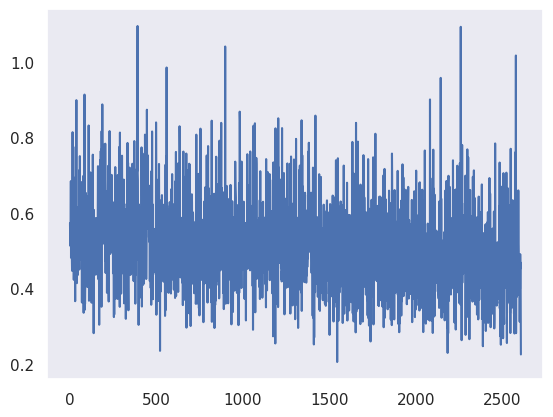

In [304]:
plt.plot(train_losses)

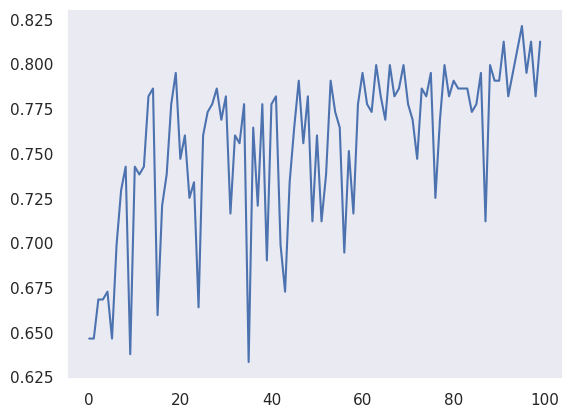

In [305]:
plt.plot(test_accuracy)

In [306]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    # if data.shape != torch.Size([64,1,20000]):
    #         continue
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 186/229 (0.8122)
tensor([[ 42,  39],
        [  4, 144]], device='cuda:0')


In [307]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
n_epoch4 = 50
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(101, 101 + n_epoch4):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02702702702702703/50 [00:00<12:37, 15.16s/it]

Train Epoch: 101 [0/913 (0%)]	Loss: 0.470566


  2%|█▌                                                                           | 0.9999999999999991/50 [00:13<09:53, 12.11s/it]


Test Epoch: 101	Accuracy: 187/229 (82%)



  2%|█▌                                                                            | 1.027027027027026/50 [00:13<10:38, 13.03s/it]

Train Epoch: 102 [0/913 (0%)]	Loss: 0.443941


  4%|███                                                                          | 1.9999999999999971/50 [00:27<09:50, 12.30s/it]


Test Epoch: 102	Accuracy: 186/229 (81%)



  4%|███▏                                                                          | 2.027027027027024/50 [00:27<10:22, 12.97s/it]

Train Epoch: 103 [0/913 (0%)]	Loss: 0.277271


  6%|████▋                                                                         | 3.000000000000003/50 [00:40<09:23, 12.00s/it]


Test Epoch: 103	Accuracy: 185/229 (81%)



  6%|████▋                                                                        | 3.0270270270270303/50 [00:40<10:01, 12.81s/it]

Train Epoch: 104 [0/913 (0%)]	Loss: 0.525840


  8%|██████▏                                                                       | 4.000000000000009/50 [00:53<09:18, 12.15s/it]


Test Epoch: 104	Accuracy: 186/229 (81%)



  8%|██████▎                                                                       | 4.027027027027036/50 [00:54<09:58, 13.03s/it]

Train Epoch: 105 [0/913 (0%)]	Loss: 0.290235


 10%|███████▊                                                                      | 5.000000000000015/50 [01:06<08:59, 11.99s/it]


Test Epoch: 105	Accuracy: 186/229 (81%)



 10%|███████▊                                                                      | 5.027027027027042/50 [01:07<09:46, 13.03s/it]

Train Epoch: 106 [0/913 (0%)]	Loss: 0.424920


 12%|█████████▎                                                                    | 6.000000000000021/50 [01:20<09:02, 12.33s/it]


Test Epoch: 106	Accuracy: 187/229 (82%)



 12%|█████████▎                                                                   | 6.0270270270270485/50 [01:20<09:39, 13.17s/it]

Train Epoch: 107 [0/913 (0%)]	Loss: 0.497013


 14%|██████████▊                                                                  | 7.0000000000000275/50 [01:33<08:53, 12.41s/it]


Test Epoch: 107	Accuracy: 185/229 (81%)



 14%|██████████▉                                                                   | 7.027027027027055/50 [01:34<09:20, 13.04s/it]

Train Epoch: 108 [0/913 (0%)]	Loss: 0.668254


 16%|████████████▍                                                                 | 8.000000000000034/50 [01:47<08:28, 12.10s/it]


Test Epoch: 108	Accuracy: 186/229 (81%)



 16%|████████████▋                                                                  | 8.02702702702706/50 [01:47<09:04, 12.98s/it]

Train Epoch: 109 [0/913 (0%)]	Loss: 0.458437


 18%|██████████████                                                                | 9.000000000000007/50 [02:00<08:15, 12.08s/it]


Test Epoch: 109	Accuracy: 186/229 (81%)



 18%|██████████████                                                                | 9.027027027027033/50 [02:00<08:46, 12.84s/it]

Train Epoch: 110 [0/913 (0%)]	Loss: 0.414826


 20%|███████████████▊                                                               | 9.99999999999998/50 [02:13<08:02, 12.06s/it]


Test Epoch: 110	Accuracy: 186/229 (81%)



 20%|███████████████▍                                                             | 10.027027027027007/50 [02:14<08:38, 12.98s/it]

Train Epoch: 111 [0/913 (0%)]	Loss: 0.570380


 22%|████████████████▉                                                            | 10.999999999999954/50 [02:27<07:54, 12.16s/it]


Test Epoch: 111	Accuracy: 188/229 (82%)



 22%|█████████████████▏                                                            | 11.02702702702698/50 [02:27<08:23, 12.91s/it]

Train Epoch: 112 [0/913 (0%)]	Loss: 0.533098


 24%|██████████████████▍                                                          | 11.999999999999927/50 [02:40<07:55, 12.52s/it]


Test Epoch: 112	Accuracy: 186/229 (81%)



 24%|██████████████████▌                                                          | 12.027027027026953/50 [02:41<08:23, 13.25s/it]

Train Epoch: 113 [0/913 (0%)]	Loss: 0.420122


 26%|████████████████████▌                                                          | 12.9999999999999/50 [02:54<07:31, 12.20s/it]


Test Epoch: 113	Accuracy: 186/229 (81%)



 26%|████████████████████                                                         | 13.027027027026927/50 [02:54<08:08, 13.23s/it]

Train Epoch: 114 [0/913 (0%)]	Loss: 0.392304


 28%|█████████████████████▌                                                       | 13.999999999999874/50 [03:08<07:28, 12.46s/it]


Test Epoch: 114	Accuracy: 187/229 (82%)



 28%|██████████████████████▏                                                        | 14.0270270270269/50 [03:08<07:52, 13.14s/it]

Train Epoch: 115 [0/913 (0%)]	Loss: 0.479544


 30%|███████████████████████                                                      | 14.999999999999847/50 [03:21<07:03, 12.10s/it]


Test Epoch: 115	Accuracy: 185/229 (81%)



 30%|███████████████████████▏                                                     | 15.027027027026874/50 [03:21<07:29, 12.85s/it]

Train Epoch: 116 [0/913 (0%)]	Loss: 0.336592


 32%|████████████████████████▉                                                     | 15.99999999999982/50 [03:35<07:29, 13.23s/it]


Test Epoch: 116	Accuracy: 189/229 (83%)



 32%|████████████████████████▋                                                    | 16.027027027026847/50 [03:35<07:45, 13.70s/it]

Train Epoch: 117 [0/913 (0%)]	Loss: 0.582142


 34%|██████████████████████████▏                                                  | 16.999999999999858/50 [03:48<06:45, 12.28s/it]


Test Epoch: 117	Accuracy: 186/229 (81%)



 34%|██████████████████████████▏                                                  | 17.027027027026886/50 [03:49<07:17, 13.26s/it]

Train Epoch: 118 [0/913 (0%)]	Loss: 0.385738


 36%|███████████████████████████▋                                                 | 17.999999999999897/50 [04:02<06:22, 11.95s/it]


Test Epoch: 118	Accuracy: 185/229 (81%)



 36%|███████████████████████████▊                                                 | 18.027027027026925/50 [04:02<06:48, 12.77s/it]

Train Epoch: 119 [0/913 (0%)]	Loss: 0.318576


 38%|█████████████████████████████▎                                               | 18.999999999999936/50 [04:15<06:28, 12.52s/it]


Test Epoch: 119	Accuracy: 189/229 (83%)



 38%|█████████████████████████████▎                                               | 19.027027027026964/50 [04:15<06:48, 13.19s/it]

Train Epoch: 120 [0/913 (0%)]	Loss: 0.378355


 40%|██████████████████████████████▊                                              | 19.999999999999975/50 [04:29<06:07, 12.26s/it]


Test Epoch: 120	Accuracy: 186/229 (81%)



 40%|██████████████████████████████▊                                              | 20.027027027027003/50 [04:29<06:27, 12.93s/it]

Train Epoch: 121 [0/913 (0%)]	Loss: 0.325763


 42%|████████████████████████████████▎                                            | 21.000000000000014/50 [04:42<05:52, 12.17s/it]


Test Epoch: 121	Accuracy: 186/229 (81%)



 42%|████████████████████████████████▍                                            | 21.027027027027042/50 [04:42<06:15, 12.97s/it]

Train Epoch: 122 [0/913 (0%)]	Loss: 0.534514


 44%|█████████████████████████████████▉                                           | 22.000000000000053/50 [04:56<05:40, 12.15s/it]


Test Epoch: 122	Accuracy: 187/229 (82%)



 44%|██████████████████████████████████▎                                           | 22.02702702702708/50 [04:56<06:01, 12.92s/it]

Train Epoch: 123 [0/913 (0%)]	Loss: 0.416858


 46%|███████████████████████████████████▍                                         | 23.000000000000092/50 [05:09<05:30, 12.25s/it]


Test Epoch: 123	Accuracy: 188/229 (82%)



 46%|███████████████████████████████████▉                                          | 23.02702702702712/50 [05:10<05:51, 13.03s/it]

Train Epoch: 124 [0/913 (0%)]	Loss: 0.296963


 48%|█████████████████████████████████████▍                                        | 24.00000000000013/50 [05:23<05:21, 12.35s/it]


Test Epoch: 124	Accuracy: 189/229 (83%)



 48%|█████████████████████████████████████▍                                        | 24.02702702702716/50 [05:23<05:37, 12.98s/it]

Train Epoch: 125 [0/913 (0%)]	Loss: 0.433099


 50%|███████████████████████████████████████                                       | 25.00000000000017/50 [05:36<05:04, 12.20s/it]


Test Epoch: 125	Accuracy: 187/229 (82%)



 50%|███████████████████████████████████████▌                                       | 25.0270270270272/50 [05:37<05:27, 13.10s/it]

Train Epoch: 126 [0/913 (0%)]	Loss: 0.257493


 52%|████████████████████████████████████████▌                                     | 26.00000000000021/50 [05:50<05:06, 12.77s/it]


Test Epoch: 126	Accuracy: 187/229 (82%)



 52%|████████████████████████████████████████                                     | 26.027027027027238/50 [05:51<05:40, 14.22s/it]

Train Epoch: 127 [0/913 (0%)]	Loss: 0.403583


 54%|██████████████████████████████████████████                                    | 27.00000000000025/50 [06:04<04:37, 12.06s/it]


Test Epoch: 127	Accuracy: 186/229 (81%)



 54%|█████████████████████████████████████████▌                                   | 27.027027027027277/50 [06:04<04:55, 12.88s/it]

Train Epoch: 128 [0/913 (0%)]	Loss: 0.318382


 56%|███████████████████████████████████████████                                  | 28.000000000000288/50 [06:17<04:26, 12.09s/it]


Test Epoch: 128	Accuracy: 187/229 (82%)



 56%|███████████████████████████████████████████▏                                 | 28.027027027027316/50 [06:18<04:41, 12.83s/it]

Train Epoch: 129 [0/913 (0%)]	Loss: 0.638660


 58%|████████████████████████████████████████████▋                                | 29.000000000000327/50 [06:31<04:15, 12.17s/it]


Test Epoch: 129	Accuracy: 188/229 (82%)



 58%|████████████████████████████████████████████▋                                | 29.027027027027355/50 [06:32<04:33, 13.03s/it]

Train Epoch: 130 [0/913 (0%)]	Loss: 0.590803


 60%|██████████████████████████████████████████████▏                              | 30.000000000000366/50 [06:45<04:03, 12.17s/it]


Test Epoch: 130	Accuracy: 187/229 (82%)



 60%|██████████████████████████████████████████████▏                              | 30.027027027027394/50 [06:45<04:20, 13.03s/it]

Train Epoch: 131 [0/913 (0%)]	Loss: 0.301859


 62%|███████████████████████████████████████████████▋                             | 31.000000000000405/50 [06:58<03:55, 12.39s/it]


Test Epoch: 131	Accuracy: 187/229 (82%)



 62%|███████████████████████████████████████████████▊                             | 31.027027027027433/50 [06:59<04:08, 13.12s/it]

Train Epoch: 132 [0/913 (0%)]	Loss: 0.432658


 64%|█████████████████████████████████████████████████▉                            | 32.00000000000044/50 [07:12<03:39, 12.21s/it]


Test Epoch: 132	Accuracy: 189/229 (83%)



 64%|█████████████████████████████████████████████████▎                           | 32.027027027027465/50 [07:12<03:53, 12.97s/it]

Train Epoch: 133 [0/913 (0%)]	Loss: 0.426054


 66%|███████████████████████████████████████████████████▍                          | 33.00000000000035/50 [07:26<03:38, 12.87s/it]


Test Epoch: 133	Accuracy: 188/229 (82%)



 66%|███████████████████████████████████████████████████▌                          | 33.02702702702737/50 [07:26<03:46, 13.33s/it]

Train Epoch: 134 [0/913 (0%)]	Loss: 0.190689


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000256/50 [07:40<03:17, 12.32s/it]


Test Epoch: 134	Accuracy: 188/229 (82%)



 68%|█████████████████████████████████████████████████████                         | 34.02702702702728/50 [07:41<03:29, 13.09s/it]

Train Epoch: 135 [0/913 (0%)]	Loss: 0.302063


 70%|██████████████████████████████████████████████████████▌                       | 35.00000000000016/50 [07:54<03:09, 12.62s/it]


Test Epoch: 135	Accuracy: 189/229 (83%)



 70%|██████████████████████████████████████████████████████▋                       | 35.02702702702719/50 [07:54<03:18, 13.28s/it]

Train Epoch: 136 [0/913 (0%)]	Loss: 0.458201


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000007/50 [08:07<02:53, 12.42s/it]


Test Epoch: 136	Accuracy: 187/229 (82%)



 72%|███████████████████████████████████████████████████████▍                     | 36.027027027027096/50 [08:08<03:03, 13.15s/it]

Train Epoch: 137 [0/913 (0%)]	Loss: 0.322705


 74%|█████████████████████████████████████████████████████████▋                    | 36.99999999999998/50 [08:21<02:41, 12.45s/it]


Test Epoch: 137	Accuracy: 187/229 (82%)



 74%|███████████████████████████████████████████████████████████▏                    | 37.027027027027/50 [08:21<02:50, 13.16s/it]

Train Epoch: 138 [0/913 (0%)]	Loss: 0.334880


 76%|██████████████████████████████████████████████████████████▌                  | 37.999999999999886/50 [08:34<02:27, 12.29s/it]


Test Epoch: 138	Accuracy: 186/229 (81%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.02702702702691/50 [08:35<02:36, 13.07s/it]

Train Epoch: 139 [0/913 (0%)]	Loss: 0.513221


 78%|████████████████████████████████████████████████████████████                 | 38.999999999999794/50 [08:48<02:17, 12.48s/it]


Test Epoch: 139	Accuracy: 187/229 (82%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02702702702682/50 [08:48<02:23, 13.08s/it]

Train Epoch: 140 [0/913 (0%)]	Loss: 0.477327


 80%|███████████████████████████████████████████████████████████████▏               | 39.9999999999997/50 [09:01<02:02, 12.28s/it]


Test Epoch: 140	Accuracy: 185/229 (81%)



 80%|█████████████████████████████████████████████████████████████▋               | 40.027027027026726/50 [09:02<02:10, 13.10s/it]

Train Epoch: 141 [0/913 (0%)]	Loss: 0.436485


 82%|███████████████████████████████████████████████████████████████▉              | 40.99999999999961/50 [09:15<01:49, 12.15s/it]


Test Epoch: 141	Accuracy: 188/229 (82%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.027027027026634/50 [09:15<01:56, 13.01s/it]

Train Epoch: 142 [0/913 (0%)]	Loss: 0.409169


 84%|█████████████████████████████████████████████████████████████████▌            | 41.99999999999952/50 [09:28<01:40, 12.52s/it]


Test Epoch: 142	Accuracy: 189/229 (83%)



 84%|█████████████████████████████████████████████████████████████████▌            | 42.02702702702654/50 [09:28<01:44, 13.15s/it]

Train Epoch: 143 [0/913 (0%)]	Loss: 0.478012


 86%|██████████████████████████████████████████████████████████████████▏          | 42.999999999999424/50 [09:42<01:25, 12.25s/it]


Test Epoch: 143	Accuracy: 187/229 (82%)



 86%|███████████████████████████████████████████████████████████████████           | 43.02702702702645/50 [09:42<01:30, 12.91s/it]

Train Epoch: 144 [0/913 (0%)]	Loss: 0.405175


 88%|████████████████████████████████████████████████████████████████████▋         | 43.99999999999933/50 [09:55<01:12, 12.08s/it]


Test Epoch: 144	Accuracy: 189/229 (83%)



 88%|████████████████████████████████████████████████████████████████████▋         | 44.02702702702636/50 [09:56<01:17, 12.91s/it]

Train Epoch: 145 [0/913 (0%)]	Loss: 0.247586


 90%|██████████████████████████████████████████████████████████████████████▏       | 44.99999999999924/50 [10:09<01:01, 12.21s/it]


Test Epoch: 145	Accuracy: 189/229 (83%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 45.027027027026264/50 [10:09<01:03, 12.84s/it]

Train Epoch: 146 [0/913 (0%)]	Loss: 0.436730


 92%|███████████████████████████████████████████████████████████████████████▊      | 45.99999999999915/50 [10:23<00:50, 12.66s/it]


Test Epoch: 146	Accuracy: 189/229 (83%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.02702702702617/50 [10:23<00:53, 13.40s/it]

Train Epoch: 147 [0/913 (0%)]	Loss: 0.447435


 94%|████████████████████████████████████████████████████████████████████████▍    | 46.999999999999055/50 [10:36<00:37, 12.60s/it]


Test Epoch: 147	Accuracy: 187/229 (82%)



 94%|█████████████████████████████████████████████████████████████████████████▎    | 47.02702702702608/50 [10:37<00:39, 13.22s/it]

Train Epoch: 148 [0/913 (0%)]	Loss: 0.357167


 96%|██████████████████████████████████████████████████████████████████████████▉   | 47.99999999999896/50 [10:50<00:25, 12.78s/it]


Test Epoch: 148	Accuracy: 188/229 (82%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02702702702599/50 [10:50<00:26, 13.41s/it]

Train Epoch: 149 [0/913 (0%)]	Loss: 0.427847


 98%|████████████████████████████████████████████████████████████████████████████▍ | 48.99999999999887/50 [11:05<00:14, 14.03s/it]


Test Epoch: 149	Accuracy: 188/229 (82%)



 98%|███████████████████████████████████████████████████████████████████████████▌ | 49.027027027025895/50 [11:05<00:14, 14.73s/it]

Train Epoch: 150 [0/913 (0%)]	Loss: 0.407956


100%|█████████████████████████████████████████████████████████████████████████████▉| 49.99999999999878/50 [11:19<00:00, 13.60s/it]


Test Epoch: 150	Accuracy: 186/229 (81%)



In [336]:
torch.autograd.set_detect_anomaly(True)

In [362]:
model = M10(config=model_config,
           n_input=1, n_output=2)
model

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): SincWinConv()
        (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (layer): Linear(in_features=64, out_features=256, bias=True)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (layer): Linear(in_features=256, out_features=256, bias=True)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (act): ReLU()
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [363]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [364]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▏                                                                           | 0.02702702702702703/10 [00:00<02:48, 16.91s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.675871


 10%|███████▋                                                                     | 0.9999999999999991/10 [00:15<02:01, 13.55s/it]


Test Epoch: 1	Accuracy: 172/229 (75%)



 10%|████████                                                                      | 1.027027027027026/10 [00:15<02:11, 14.61s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.643156


 20%|███████████████▍                                                             | 1.9999999999999971/10 [00:30<01:50, 13.81s/it]


Test Epoch: 2	Accuracy: 182/229 (79%)



 20%|███████████████▊                                                              | 2.027027027027024/10 [00:31<01:57, 14.72s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.648397


 30%|███████████████████████▍                                                      | 3.000000000000003/10 [00:46<01:35, 13.57s/it]


Test Epoch: 3	Accuracy: 169/229 (74%)



 30%|███████████████████████▎                                                     | 3.0270270270270303/10 [00:46<01:40, 14.45s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.565310


 40%|███████████████████████████████▏                                              | 4.000000000000009/10 [01:01<01:22, 13.83s/it]


Test Epoch: 4	Accuracy: 147/229 (64%)



 40%|███████████████████████████████▍                                              | 4.027027027027036/10 [01:02<01:27, 14.71s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.669019


 50%|███████████████████████████████████████                                       | 5.000000000000015/10 [01:17<01:10, 14.10s/it]


Test Epoch: 5	Accuracy: 163/229 (71%)



 50%|███████████████████████████████████████▏                                      | 5.027027027027042/10 [01:17<01:13, 14.82s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.420139


 60%|██████████████████████████████████████████████▊                               | 6.000000000000021/10 [01:32<00:53, 13.44s/it]


Test Epoch: 6	Accuracy: 180/229 (79%)



 60%|██████████████████████████████████████████████▍                              | 6.0270270270270485/10 [01:32<00:56, 14.34s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.527538


 70%|█████████████████████████████████████████████████████▉                       | 7.0000000000000275/10 [01:47<00:41, 13.72s/it]


Test Epoch: 7	Accuracy: 184/229 (80%)



 70%|██████████████████████████████████████████████████████▊                       | 7.027027027027055/10 [01:48<00:45, 15.46s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.548708


 80%|██████████████████████████████████████████████████████████████▍               | 8.000000000000034/10 [02:03<00:27, 13.65s/it]


Test Epoch: 8	Accuracy: 182/229 (79%)



 80%|███████████████████████████████████████████████████████████████▍               | 8.02702702702706/10 [02:03<00:28, 14.60s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.400508


 90%|██████████████████████████████████████████████████████████████████████▏       | 9.000000000000007/10 [02:18<00:13, 13.68s/it]


Test Epoch: 9	Accuracy: 180/229 (79%)



 90%|██████████████████████████████████████████████████████████████████████▍       | 9.027027027027033/10 [02:19<00:14, 14.67s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.427233


100%|██████████████████████████████████████████████████████████████████████████████▉| 9.99999999999998/10 [02:34<00:00, 15.45s/it]


Test Epoch: 10	Accuracy: 171/229 (75%)



In [365]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 171/229 (0.7467)
tensor([[ 23,  58],
        [  0, 148]], device='cuda:0')


In [366]:
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[-0.0000e+00],
        [ 6.2626e-02],
        [-5.3323e-02],
        [-1.9073e-03],
        [-8.6536e-03],
        [-8.3630e-03],
        [ 1.1394e-02],
        [ 2.5480e-03],
        [-3.3627e-02],
        [-5.1696e-02],
        [ 1.8898e-05],
        [ 6.3545e-03],
        [ 7.7038e-03],
        [-1.2940e-01],
        [ 9.8725e-02],
        [-3.0662e-02],
        [ 0.0000e+00],
        [ 1.0454e-01],
        [ 1.3761e-02],
        [ 2.8150e-02],
        [-3.8706e-04],
        [-6.4796e-02],
        [-6.9981e-03],
        [ 7.8067e-03],
        [ 2.4355e-02],
        [ 2.1589e-02],
        [-2.5547e-03],
        [ 3.1866e-02],
        [-1.5821e-02],
        [ 2.2727e-01],
        [ 2.3190e-02],
        [ 2.6065e-01],
        [ 0.0000e+00],
        [-8.0626e-04],
        [ 7.0762e-04],
        [ 1.0498e-03],
        [ 1.0855e-02],
        [-2.8299e-04],
        [-8.7275e-03],
        [ 1.9505e-03],
        [-1.0758e-01],
        [ 3.8388e-02],
        [ 1.1064e-03],
        [-9

[None, None, None]

In [367]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)

Time domain: Filters' shapes vary by frequency bins


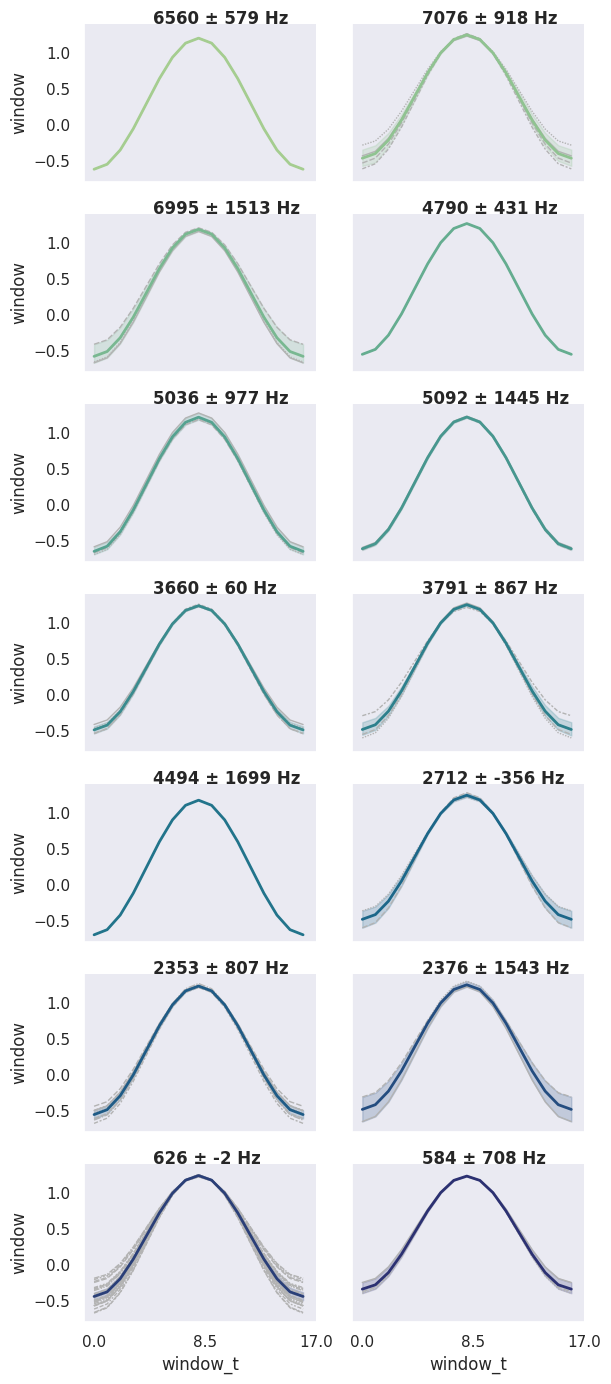

In [368]:
filtviz.visualize_filters(filter_domain='time')

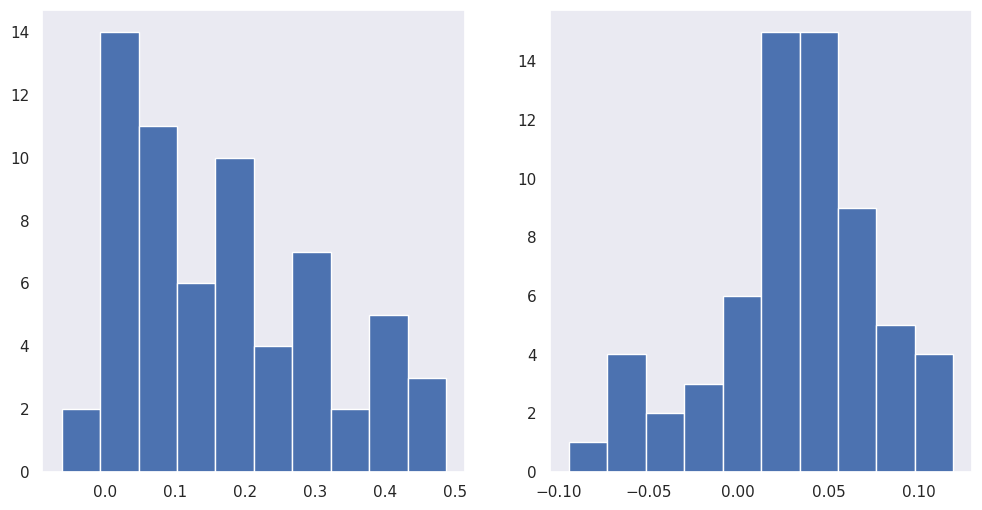

In [370]:
filtviz.visualize_bands()

In [371]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)

In [372]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1 + n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02702702702702703/50 [00:00<14:54, 17.89s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.368612


  2%|█▌                                                                           | 0.9999999999999991/50 [00:15<11:12, 13.71s/it]


Test Epoch: 11	Accuracy: 167/229 (73%)



  2%|█▌                                                                            | 1.027027027027026/50 [00:15<11:53, 14.57s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.489010


  4%|███                                                                          | 1.9999999999999971/50 [00:30<11:07, 13.90s/it]


Test Epoch: 12	Accuracy: 186/229 (81%)



  4%|███▏                                                                          | 2.027027027027024/50 [00:31<11:49, 14.78s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.597466


  6%|████▋                                                                         | 3.000000000000003/50 [00:46<10:47, 13.78s/it]


Test Epoch: 13	Accuracy: 182/229 (79%)



  6%|████▋                                                                        | 3.0270270270270303/50 [00:46<11:25, 14.60s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.602889


  8%|██████▏                                                                       | 4.000000000000009/50 [01:02<10:55, 14.25s/it]


Test Epoch: 14	Accuracy: 181/229 (79%)



  8%|██████▎                                                                       | 4.027027027027036/50 [01:02<11:32, 15.06s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.358708


 10%|███████▊                                                                      | 5.000000000000015/50 [01:17<10:15, 13.69s/it]


Test Epoch: 15	Accuracy: 172/229 (75%)



 10%|███████▊                                                                      | 5.027027027027042/50 [01:17<10:59, 14.66s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.412400


 12%|█████████▎                                                                    | 6.000000000000021/50 [01:32<10:09, 13.86s/it]


Test Epoch: 16	Accuracy: 187/229 (82%)



 12%|█████████▎                                                                   | 6.0270270270270485/50 [01:33<10:44, 14.65s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.434882


 14%|██████████▊                                                                  | 7.0000000000000275/50 [01:48<09:53, 13.81s/it]


Test Epoch: 17	Accuracy: 183/229 (80%)



 14%|██████████▉                                                                   | 7.027027027027055/50 [01:48<10:29, 14.64s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.435659


 16%|████████████▍                                                                 | 8.000000000000034/50 [02:03<09:25, 13.46s/it]


Test Epoch: 18	Accuracy: 180/229 (79%)



 16%|████████████▋                                                                  | 8.02702702702706/50 [02:04<10:16, 14.68s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.677436


 18%|██████████████                                                                | 9.000000000000007/50 [02:19<10:16, 15.03s/it]


Test Epoch: 19	Accuracy: 161/229 (70%)



 18%|██████████████                                                                | 9.027027027027033/50 [02:19<10:32, 15.43s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.480165


 20%|███████████████▊                                                               | 9.99999999999998/50 [02:34<10:52, 16.30s/it]


Test Epoch: 20	Accuracy: 181/229 (79%)



 20%|███████████████▍                                                             | 10.027027027027007/50 [02:35<10:53, 16.34s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.478744


 22%|████████████████▉                                                            | 10.999999999999954/50 [02:50<09:06, 14.02s/it]


Test Epoch: 21	Accuracy: 171/229 (75%)



 22%|█████████████████▏                                                            | 11.02702702702698/50 [02:50<09:39, 14.87s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.541605


 24%|██████████████████▍                                                          | 11.999999999999927/50 [03:05<08:50, 13.97s/it]


Test Epoch: 22	Accuracy: 179/229 (78%)



 24%|██████████████████▌                                                          | 12.027027027026953/50 [03:06<09:18, 14.71s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.449438


 26%|████████████████████▌                                                          | 12.9999999999999/50 [03:22<08:35, 13.92s/it]


Test Epoch: 23	Accuracy: 154/229 (67%)



 26%|████████████████████                                                         | 13.027027027026927/50 [03:22<09:03, 14.71s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.541573


 28%|█████████████████████▌                                                       | 13.999999999999874/50 [03:38<08:15, 13.76s/it]


Test Epoch: 24	Accuracy: 178/229 (78%)



 28%|██████████████████████▏                                                        | 14.0270270270269/50 [03:38<08:47, 14.67s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.607425


 30%|███████████████████████                                                      | 14.999999999999847/50 [03:54<08:16, 14.19s/it]


Test Epoch: 25	Accuracy: 172/229 (75%)



 30%|███████████████████████▏                                                     | 15.027027027026874/50 [03:54<08:42, 14.95s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.699097


 32%|████████████████████████▉                                                     | 15.99999999999982/50 [04:09<07:36, 13.42s/it]


Test Epoch: 26	Accuracy: 182/229 (79%)



 32%|████████████████████████▋                                                    | 16.027027027026847/50 [04:09<08:07, 14.36s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.564536


 34%|██████████████████████████▏                                                  | 16.999999999999858/50 [04:24<07:38, 13.89s/it]


Test Epoch: 27	Accuracy: 178/229 (78%)



 34%|██████████████████████████▏                                                  | 17.027027027026886/50 [04:25<08:04, 14.71s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.482466


 36%|███████████████████████████▋                                                 | 17.999999999999897/50 [04:40<07:15, 13.60s/it]


Test Epoch: 28	Accuracy: 179/229 (78%)



 36%|███████████████████████████▊                                                 | 18.027027027026925/50 [04:40<07:45, 14.57s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.608413


 38%|█████████████████████████████▎                                               | 18.999999999999936/50 [04:55<07:05, 13.74s/it]


Test Epoch: 29	Accuracy: 178/229 (78%)



 38%|█████████████████████████████▎                                               | 19.027027027026964/50 [04:56<07:34, 14.68s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.531596


 40%|██████████████████████████████▊                                              | 19.999999999999975/50 [05:11<06:56, 13.88s/it]


Test Epoch: 30	Accuracy: 179/229 (78%)



 40%|██████████████████████████████▊                                              | 20.027027027027003/50 [05:12<07:18, 14.64s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.644753


 42%|████████████████████████████████▎                                            | 21.000000000000014/50 [05:27<06:37, 13.72s/it]


Test Epoch: 31	Accuracy: 175/229 (76%)



 42%|████████████████████████████████▍                                            | 21.027027027027042/50 [05:27<07:01, 14.56s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.456103


 44%|█████████████████████████████████▉                                           | 22.000000000000053/50 [05:42<06:21, 13.63s/it]


Test Epoch: 32	Accuracy: 178/229 (78%)



 44%|██████████████████████████████████▎                                           | 22.02702702702708/50 [05:43<06:50, 14.67s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.360102


 46%|███████████████████████████████████▍                                         | 23.000000000000092/50 [05:58<06:13, 13.84s/it]


Test Epoch: 33	Accuracy: 180/229 (79%)



 46%|███████████████████████████████████▉                                          | 23.02702702702712/50 [05:58<06:34, 14.62s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.435217


 48%|█████████████████████████████████████▍                                        | 24.00000000000013/50 [06:13<05:46, 13.33s/it]


Test Epoch: 34	Accuracy: 161/229 (70%)



 48%|█████████████████████████████████████▍                                        | 24.02702702702716/50 [06:14<06:14, 14.43s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.565361


 50%|███████████████████████████████████████                                       | 25.00000000000017/50 [06:29<05:42, 13.69s/it]


Test Epoch: 35	Accuracy: 161/229 (70%)



 50%|███████████████████████████████████████▌                                       | 25.0270270270272/50 [06:29<06:06, 14.66s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.454830


 52%|████████████████████████████████████████▌                                     | 26.00000000000021/50 [06:44<05:28, 13.67s/it]


Test Epoch: 36	Accuracy: 181/229 (79%)



 52%|████████████████████████████████████████                                     | 26.027027027027238/50 [06:45<05:50, 14.60s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.535944


 54%|██████████████████████████████████████████                                    | 27.00000000000025/50 [07:00<05:11, 13.55s/it]


Test Epoch: 37	Accuracy: 181/229 (79%)



 54%|█████████████████████████████████████████▌                                   | 27.027027027027277/50 [07:00<05:33, 14.52s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.575123


 56%|███████████████████████████████████████████                                  | 28.000000000000288/50 [07:15<05:00, 13.66s/it]


Test Epoch: 38	Accuracy: 179/229 (78%)



 56%|███████████████████████████████████████████▏                                 | 28.027027027027316/50 [07:16<05:27, 14.92s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.367087


 58%|████████████████████████████████████████████▋                                | 29.000000000000327/50 [07:31<04:48, 13.76s/it]


Test Epoch: 39	Accuracy: 184/229 (80%)



 58%|████████████████████████████████████████████▋                                | 29.027027027027355/50 [07:31<05:09, 14.75s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.695278


 60%|██████████████████████████████████████████████▏                              | 30.000000000000366/50 [07:47<04:34, 13.72s/it]


Test Epoch: 40	Accuracy: 179/229 (78%)



 60%|██████████████████████████████████████████████▏                              | 30.027027027027394/50 [07:47<04:53, 14.69s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.363061


 62%|███████████████████████████████████████████████▋                             | 31.000000000000405/50 [08:03<04:25, 13.97s/it]


Test Epoch: 41	Accuracy: 182/229 (79%)



 62%|███████████████████████████████████████████████▊                             | 31.027027027027433/50 [08:03<04:39, 14.73s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.397518


 64%|█████████████████████████████████████████████████▉                            | 32.00000000000044/50 [08:18<04:04, 13.59s/it]


Test Epoch: 42	Accuracy: 181/229 (79%)



 64%|█████████████████████████████████████████████████▎                           | 32.027027027027465/50 [08:19<04:25, 14.77s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.581549


 66%|███████████████████████████████████████████████████▍                          | 33.00000000000035/50 [08:34<03:49, 13.50s/it]


Test Epoch: 43	Accuracy: 179/229 (78%)



 66%|███████████████████████████████████████████████████▌                          | 33.02702702702737/50 [08:34<04:03, 14.35s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.559668


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000256/50 [08:50<03:37, 13.58s/it]


Test Epoch: 44	Accuracy: 161/229 (70%)



 68%|█████████████████████████████████████████████████████                         | 34.02702702702728/50 [08:50<03:50, 14.41s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.394398


 70%|██████████████████████████████████████████████████████▌                       | 35.00000000000016/50 [09:05<03:30, 14.04s/it]


Test Epoch: 45	Accuracy: 181/229 (79%)



 70%|██████████████████████████████████████████████████████▋                       | 35.02702702702719/50 [09:05<03:42, 14.84s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.533498


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000007/50 [09:21<03:18, 14.17s/it]


Test Epoch: 46	Accuracy: 179/229 (78%)



 72%|███████████████████████████████████████████████████████▍                     | 36.027027027027096/50 [09:21<03:28, 14.94s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.676315


 74%|█████████████████████████████████████████████████████████▋                    | 36.99999999999998/50 [09:37<02:55, 13.51s/it]


Test Epoch: 47	Accuracy: 154/229 (67%)



 74%|███████████████████████████████████████████████████████████▏                    | 37.027027027027/50 [09:37<03:08, 14.51s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.586167


 76%|██████████████████████████████████████████████████████████▌                  | 37.999999999999886/50 [09:52<02:47, 14.00s/it]


Test Epoch: 48	Accuracy: 183/229 (80%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.02702702702691/50 [09:53<02:56, 14.77s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.470753


 78%|████████████████████████████████████████████████████████████                 | 38.999999999999794/50 [10:08<02:34, 14.06s/it]


Test Epoch: 49	Accuracy: 169/229 (74%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02702702702682/50 [10:09<02:42, 14.85s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.401821


 80%|███████████████████████████████████████████████████████████████▏               | 39.9999999999997/50 [10:24<02:15, 13.52s/it]


Test Epoch: 50	Accuracy: 181/229 (79%)



 80%|█████████████████████████████████████████████████████████████▋               | 40.027027027026726/50 [10:25<02:28, 14.94s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.530773


 82%|███████████████████████████████████████████████████████████████▉              | 40.99999999999961/50 [10:42<02:04, 13.86s/it]


Test Epoch: 51	Accuracy: 177/229 (77%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.027027027026634/50 [10:43<02:11, 14.64s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.291417


 84%|█████████████████████████████████████████████████████████████████▌            | 41.99999999999952/50 [10:58<01:52, 14.12s/it]


Test Epoch: 52	Accuracy: 181/229 (79%)



 84%|█████████████████████████████████████████████████████████████████▌            | 42.02702702702654/50 [10:59<01:58, 14.83s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.685520


 86%|██████████████████████████████████████████████████████████████████▏          | 42.999999999999424/50 [11:14<01:35, 13.62s/it]


Test Epoch: 53	Accuracy: 184/229 (80%)



 86%|███████████████████████████████████████████████████████████████████           | 43.02702702702645/50 [11:14<01:41, 14.57s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.474258


 88%|████████████████████████████████████████████████████████████████████▋         | 43.99999999999933/50 [11:29<01:21, 13.60s/it]


Test Epoch: 54	Accuracy: 170/229 (74%)



 88%|████████████████████████████████████████████████████████████████████▋         | 44.02702702702636/50 [11:29<01:26, 14.52s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.380668


 90%|██████████████████████████████████████████████████████████████████████▏       | 44.99999999999924/50 [11:45<01:09, 13.82s/it]


Test Epoch: 55	Accuracy: 163/229 (71%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 45.027027027026264/50 [11:45<01:12, 14.66s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.295825


 92%|███████████████████████████████████████████████████████████████████████▊      | 45.99999999999915/50 [12:01<00:55, 13.88s/it]


Test Epoch: 56	Accuracy: 161/229 (70%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.02702702702617/50 [12:01<00:58, 14.67s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.545419


 94%|████████████████████████████████████████████████████████████████████████▍    | 46.999999999999055/50 [12:16<00:41, 13.70s/it]


Test Epoch: 57	Accuracy: 172/229 (75%)



 94%|█████████████████████████████████████████████████████████████████████████▎    | 47.02702702702608/50 [12:17<00:43, 14.60s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.575841


 96%|██████████████████████████████████████████████████████████████████████████▉   | 47.99999999999896/50 [12:32<00:27, 13.60s/it]


Test Epoch: 58	Accuracy: 159/229 (69%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02702702702599/50 [12:32<00:28, 14.55s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.525594


 98%|████████████████████████████████████████████████████████████████████████████▍ | 48.99999999999887/50 [12:48<00:13, 13.62s/it]


Test Epoch: 59	Accuracy: 179/229 (78%)



 98%|███████████████████████████████████████████████████████████████████████████▌ | 49.027027027025895/50 [12:48<00:14, 14.71s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.564380


100%|█████████████████████████████████████████████████████████████████████████████▉| 49.99999999999878/50 [13:03<00:00, 15.67s/it]


Test Epoch: 60	Accuracy: 175/229 (76%)



In [373]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 175/229 (0.7642)
tensor([[ 31,  50],
        [  4, 144]], device='cuda:0')


In [374]:
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-1.8303e-02],
        [-2.3764e-02],
        [-5.9278e-04],
        [-1.4855e-01],
        [-6.8920e-04],
        [-2.4083e-01],
        [ 9.0504e-05],
        [-1.5905e-02],
        [-2.9638e-04],
        [ 2.4496e-03],
        [ 1.5355e-03],
        [ 7.2618e-04],
        [-2.2504e-03],
        [-6.1493e-04],
        [ 9.8791e-04],
        [ 0.0000e+00],
        [-2.6361e-02],
        [-9.9395e-02],
        [-4.4957e-04],
        [-6.2834e-01],
        [-1.4469e-03],
        [-4.6506e-04],
        [-1.5374e-01],
        [-2.2278e-01],
        [ 1.9602e-03],
        [-5.2450e-02],
        [-4.0727e-04],
        [ 4.8555e-04],
        [ 1.6847e-03],
        [-6.0708e-04],
        [-8.4257e-04],
        [ 0.0000e+00],
        [-8.0562e-04],
        [ 1.0435e-01],
        [ 4.9284e-04],
        [-1.5977e-03],
        [ 9.8568e-04],
        [ 1.6389e-03],
        [-2.4264e-05],
        [-8.5831e-03],
        [ 5.5297e-04],
        [-1.2559e-03],
        [ 4

[None, None, None]

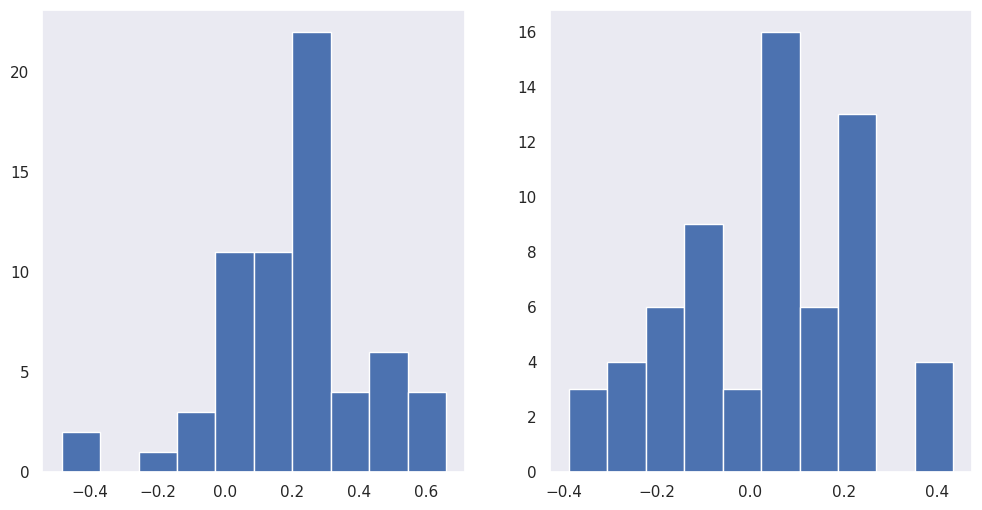

In [375]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


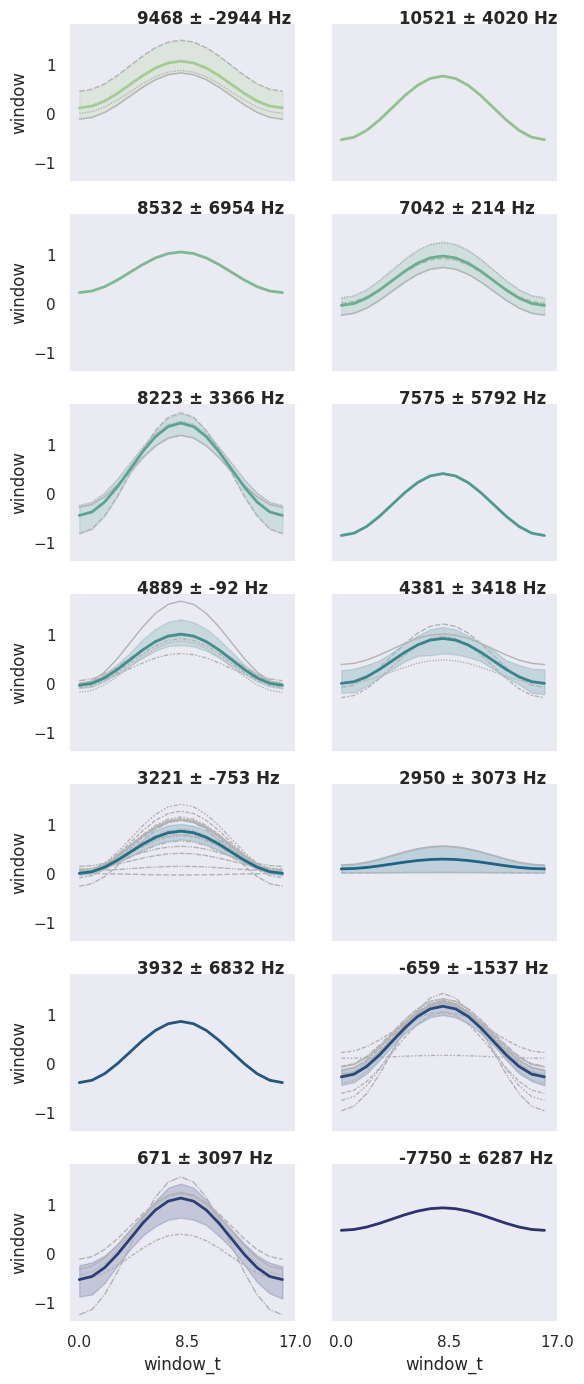

In [376]:
filtviz.visualize_filters(filter_domain='time')

In [381]:
del model
gc.collect()

44717

In [382]:
model = M10(config=model_config,
           n_input=1, n_output=2)
model

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): SincWinConv()
        (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (layer): Linear(in_features=64, out_features=256, bias=True)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (layer): Linear(in_features=256, out_features=256, bias=True)
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (act): ReLU()
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [383]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [384]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1 + n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02702702702702703/50 [00:00<13:45, 16.52s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.889083


  2%|█▌                                                                           | 0.9999999999999991/50 [00:15<11:21, 13.91s/it]


Test Epoch: 11	Accuracy: 182/229 (79%)



  2%|█▌                                                                            | 1.027027027027026/50 [00:16<12:16, 15.04s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.643937


  4%|███                                                                          | 1.9999999999999971/50 [00:31<11:32, 14.42s/it]


Test Epoch: 12	Accuracy: 171/229 (75%)



  4%|███▏                                                                          | 2.027027027027024/50 [00:32<12:03, 15.09s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.749854


  6%|████▋                                                                         | 3.000000000000003/50 [00:47<10:47, 13.78s/it]


Test Epoch: 13	Accuracy: 180/229 (79%)



  6%|████▋                                                                        | 3.0270270270270303/50 [00:47<11:39, 14.89s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.518578


  8%|██████▏                                                                       | 4.000000000000009/50 [01:03<10:27, 13.64s/it]


Test Epoch: 14	Accuracy: 182/229 (79%)



  8%|██████▎                                                                       | 4.027027027027036/50 [01:03<11:11, 14.60s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.686333


 10%|███████▊                                                                      | 5.000000000000015/50 [01:18<10:31, 14.04s/it]


Test Epoch: 15	Accuracy: 177/229 (77%)



 10%|███████▊                                                                      | 5.027027027027042/50 [01:19<11:18, 15.09s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.371228


 12%|█████████▎                                                                    | 6.000000000000021/50 [01:34<09:59, 13.62s/it]


Test Epoch: 16	Accuracy: 179/229 (78%)



 12%|█████████▎                                                                   | 6.0270270270270485/50 [01:34<10:43, 14.63s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.363335


 14%|██████████▊                                                                  | 7.0000000000000275/50 [01:50<10:06, 14.10s/it]


Test Epoch: 17	Accuracy: 183/229 (80%)



 14%|██████████▉                                                                   | 7.027027027027055/50 [01:50<10:43, 14.98s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.633809


 16%|████████████▍                                                                 | 8.000000000000034/50 [02:05<09:55, 14.18s/it]


Test Epoch: 18	Accuracy: 183/229 (80%)



 16%|████████████▋                                                                  | 8.02702702702706/50 [02:06<11:03, 15.81s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.393655


 18%|██████████████                                                                | 9.000000000000007/50 [02:22<09:29, 13.88s/it]


Test Epoch: 19	Accuracy: 177/229 (77%)



 18%|██████████████                                                                | 9.027027027027033/50 [02:22<10:08, 14.85s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.353262


 20%|███████████████▊                                                               | 9.99999999999998/50 [02:37<09:04, 13.62s/it]


Test Epoch: 20	Accuracy: 180/229 (79%)



 20%|███████████████▍                                                             | 10.027027027027007/50 [02:38<09:45, 14.64s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.403807


 22%|████████████████▉                                                            | 10.999999999999954/50 [02:53<08:54, 13.71s/it]


Test Epoch: 21	Accuracy: 157/229 (69%)



 22%|█████████████████▏                                                            | 11.02702702702698/50 [02:53<09:29, 14.60s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.532498


 24%|██████████████████▍                                                          | 11.999999999999927/50 [03:08<09:00, 14.23s/it]


Test Epoch: 22	Accuracy: 183/229 (80%)



 24%|██████████████████▌                                                          | 12.027027027026953/50 [03:09<09:38, 15.24s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.502905


 26%|████████████████████▌                                                          | 12.9999999999999/50 [03:24<08:23, 13.60s/it]


Test Epoch: 23	Accuracy: 167/229 (73%)



 26%|████████████████████                                                         | 13.027027027026927/50 [03:24<08:53, 14.44s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.443079


 28%|█████████████████████▌                                                       | 13.999999999999874/50 [03:40<08:10, 13.63s/it]


Test Epoch: 24	Accuracy: 174/229 (76%)



 28%|██████████████████████▏                                                        | 14.0270270270269/50 [03:40<08:41, 14.49s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.567275


 30%|███████████████████████                                                      | 14.999999999999847/50 [03:56<08:17, 14.21s/it]


Test Epoch: 25	Accuracy: 183/229 (80%)



 30%|███████████████████████▏                                                     | 15.027027027026874/50 [03:56<09:11, 15.78s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.457338


 32%|████████████████████████▉                                                     | 15.99999999999982/50 [04:12<07:49, 13.82s/it]


Test Epoch: 26	Accuracy: 180/229 (79%)



 32%|████████████████████████▋                                                    | 16.027027027026847/50 [04:12<08:28, 14.95s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.682797


 34%|██████████████████████████▏                                                  | 16.999999999999858/50 [04:27<07:29, 13.62s/it]


Test Epoch: 27	Accuracy: 157/229 (69%)



 34%|██████████████████████████▏                                                  | 17.027027027026886/50 [04:28<08:00, 14.56s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.760160


 36%|███████████████████████████▋                                                 | 17.999999999999897/50 [04:43<07:23, 13.85s/it]


Test Epoch: 28	Accuracy: 182/229 (79%)



 36%|███████████████████████████▊                                                 | 18.027027027026925/50 [04:44<07:51, 14.76s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.350332


 38%|█████████████████████████████▎                                               | 18.999999999999936/50 [04:59<07:08, 13.83s/it]


Test Epoch: 29	Accuracy: 169/229 (74%)



 38%|█████████████████████████████▎                                               | 19.027027027026964/50 [04:59<07:36, 14.74s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.450339


 40%|██████████████████████████████▊                                              | 19.999999999999975/50 [05:15<06:55, 13.83s/it]


Test Epoch: 30	Accuracy: 181/229 (79%)



 40%|██████████████████████████████▊                                              | 20.027027027027003/50 [05:15<07:34, 15.15s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.594165


 42%|████████████████████████████████▎                                            | 21.000000000000014/50 [05:30<06:35, 13.65s/it]


Test Epoch: 31	Accuracy: 177/229 (77%)



 42%|████████████████████████████████▍                                            | 21.027027027027042/50 [05:31<07:12, 14.93s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.668229


 44%|█████████████████████████████████▉                                           | 22.000000000000053/50 [05:46<06:26, 13.82s/it]


Test Epoch: 32	Accuracy: 173/229 (76%)



 44%|██████████████████████████████████▎                                           | 22.02702702702708/50 [05:47<06:53, 14.80s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.374240


 46%|███████████████████████████████████▍                                         | 23.000000000000092/50 [06:02<06:21, 14.11s/it]


Test Epoch: 33	Accuracy: 152/229 (66%)



 46%|███████████████████████████████████▉                                          | 23.02702702702712/50 [06:02<06:44, 14.98s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.519802


 48%|█████████████████████████████████████▍                                        | 24.00000000000013/50 [06:18<06:00, 13.87s/it]


Test Epoch: 34	Accuracy: 168/229 (73%)



 48%|█████████████████████████████████████▍                                        | 24.02702702702716/50 [06:18<06:25, 14.84s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.642928


 50%|███████████████████████████████████████                                       | 25.00000000000017/50 [06:34<05:57, 14.31s/it]


Test Epoch: 35	Accuracy: 180/229 (79%)



 50%|███████████████████████████████████████▌                                       | 25.0270270270272/50 [06:34<06:20, 15.26s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.649589


 52%|████████████████████████████████████████▌                                     | 26.00000000000021/50 [06:49<05:26, 13.61s/it]


Test Epoch: 36	Accuracy: 165/229 (72%)



 52%|████████████████████████████████████████                                     | 26.027027027027238/50 [06:50<05:48, 14.54s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.526660


 54%|██████████████████████████████████████████                                    | 27.00000000000025/50 [07:05<05:13, 13.61s/it]


Test Epoch: 37	Accuracy: 171/229 (75%)



 54%|█████████████████████████████████████████▌                                   | 27.027027027027277/50 [07:05<05:37, 14.69s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.684730


 56%|███████████████████████████████████████████                                  | 28.000000000000288/50 [07:21<05:29, 14.96s/it]


Test Epoch: 38	Accuracy: 164/229 (72%)



 56%|███████████████████████████████████████████▏                                 | 28.027027027027316/50 [07:21<05:47, 15.80s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.370536


 58%|████████████████████████████████████████████▋                                | 29.000000000000327/50 [07:37<04:52, 13.91s/it]


Test Epoch: 39	Accuracy: 172/229 (75%)



 58%|████████████████████████████████████████████▋                                | 29.027027027027355/50 [07:37<05:22, 15.36s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.685731


 60%|██████████████████████████████████████████████▏                              | 30.000000000000366/50 [07:52<04:32, 13.62s/it]


Test Epoch: 40	Accuracy: 168/229 (73%)



 60%|██████████████████████████████████████████████▏                              | 30.027027027027394/50 [07:53<04:55, 14.80s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.618152


 62%|███████████████████████████████████████████████▋                             | 31.000000000000405/50 [08:08<04:20, 13.69s/it]


Test Epoch: 41	Accuracy: 167/229 (73%)



 62%|███████████████████████████████████████████████▊                             | 31.027027027027433/50 [08:08<04:39, 14.75s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.591743


 64%|█████████████████████████████████████████████████▉                            | 32.00000000000044/50 [08:24<04:14, 14.14s/it]


Test Epoch: 42	Accuracy: 174/229 (76%)



 64%|█████████████████████████████████████████████████▎                           | 32.027027027027465/50 [08:24<04:32, 15.17s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.672971


 66%|███████████████████████████████████████████████████▍                          | 33.00000000000035/50 [08:40<04:04, 14.39s/it]


Test Epoch: 43	Accuracy: 148/229 (65%)



 66%|███████████████████████████████████████████████████▌                          | 33.02702702702737/50 [08:40<04:16, 15.10s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.730037


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000256/50 [08:55<03:48, 14.29s/it]


Test Epoch: 44	Accuracy: 148/229 (65%)



 68%|█████████████████████████████████████████████████████                         | 34.02702702702728/50 [08:56<04:19, 16.23s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.603492


 70%|██████████████████████████████████████████████████████▌                       | 35.00000000000016/50 [09:14<03:26, 13.78s/it]


Test Epoch: 45	Accuracy: 168/229 (73%)



 70%|██████████████████████████████████████████████████████▋                       | 35.02702702702719/50 [09:15<03:40, 14.71s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.605394


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000007/50 [09:30<03:12, 13.76s/it]


Test Epoch: 46	Accuracy: 148/229 (65%)



 72%|███████████████████████████████████████████████████████▍                     | 36.027027027027096/50 [09:30<03:28, 14.92s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.692672


 74%|█████████████████████████████████████████████████████████▋                    | 36.99999999999998/50 [09:45<02:58, 13.75s/it]


Test Epoch: 47	Accuracy: 154/229 (67%)



 74%|███████████████████████████████████████████████████████████▏                    | 37.027027027027/50 [09:46<03:10, 14.67s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.595600


 76%|██████████████████████████████████████████████████████████▌                  | 37.999999999999886/50 [10:01<02:49, 14.10s/it]


Test Epoch: 48	Accuracy: 164/229 (72%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.02702702702691/50 [10:01<03:03, 15.29s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.653302


 78%|████████████████████████████████████████████████████████████                 | 38.999999999999794/50 [10:17<02:32, 13.85s/it]


Test Epoch: 49	Accuracy: 132/229 (58%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02702702702682/50 [10:17<02:41, 14.75s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.635929


 80%|███████████████████████████████████████████████████████████████▏               | 39.9999999999997/50 [10:32<02:17, 13.79s/it]


Test Epoch: 50	Accuracy: 148/229 (65%)



 80%|█████████████████████████████████████████████████████████████▋               | 40.027027027026726/50 [10:33<02:26, 14.68s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.592612


 82%|███████████████████████████████████████████████████████████████▉              | 40.99999999999961/50 [10:48<02:02, 13.63s/it]


Test Epoch: 51	Accuracy: 169/229 (74%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.027027027026634/50 [10:48<02:10, 14.56s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.583982


 84%|█████████████████████████████████████████████████████████████████▌            | 41.99999999999952/50 [11:03<01:49, 13.68s/it]


Test Epoch: 52	Accuracy: 148/229 (65%)



 84%|█████████████████████████████████████████████████████████████████▌            | 42.02702702702654/50 [11:04<01:59, 14.96s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.746216


 86%|██████████████████████████████████████████████████████████████████▏          | 42.999999999999424/50 [11:19<01:37, 13.91s/it]


Test Epoch: 53	Accuracy: 148/229 (65%)



 86%|███████████████████████████████████████████████████████████████████           | 43.02702702702645/50 [11:20<01:44, 14.96s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.456701


 88%|████████████████████████████████████████████████████████████████████▋         | 43.99999999999933/50 [11:35<01:28, 14.78s/it]


Test Epoch: 54	Accuracy: 148/229 (65%)



 88%|████████████████████████████████████████████████████████████████████▋         | 44.02702702702636/50 [11:35<01:32, 15.49s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.880320


 90%|██████████████████████████████████████████████████████████████████████▏       | 44.99999999999924/50 [11:51<01:07, 13.57s/it]


Test Epoch: 55	Accuracy: 148/229 (65%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 45.027027027026264/50 [11:51<01:12, 14.49s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.691618


 92%|███████████████████████████████████████████████████████████████████████▊      | 45.99999999999915/50 [12:06<00:56, 14.10s/it]


Test Epoch: 56	Accuracy: 148/229 (65%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.02702702702617/50 [12:06<00:59, 14.93s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.595471


 94%|████████████████████████████████████████████████████████████████████████▍    | 46.999999999999055/50 [12:22<00:40, 13.66s/it]


Test Epoch: 57	Accuracy: 148/229 (65%)



 94%|█████████████████████████████████████████████████████████████████████████▎    | 47.02702702702608/50 [12:22<00:43, 14.74s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.557251


 96%|██████████████████████████████████████████████████████████████████████████▉   | 47.99999999999896/50 [12:37<00:27, 13.65s/it]


Test Epoch: 58	Accuracy: 148/229 (65%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02702702702599/50 [12:38<00:28, 14.59s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.598255


 98%|████████████████████████████████████████████████████████████████████████████▍ | 48.99999999999887/50 [12:53<00:13, 13.58s/it]


Test Epoch: 59	Accuracy: 148/229 (65%)



 98%|███████████████████████████████████████████████████████████████████████████▌ | 49.027027027025895/50 [12:53<00:14, 14.68s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.622445


100%|█████████████████████████████████████████████████████████████████████████████▉| 49.99999999999878/50 [13:08<00:00, 15.78s/it]


Test Epoch: 60	Accuracy: 148/229 (65%)



In [385]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 148/229 (0.6463)
tensor([[  0,  81],
        [  0, 148]], device='cuda:0')


In [387]:
model.train()
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [-0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')
tensor([[0.],
        [-0.],
        [-0.],
        [-0.],
        [-0

[None, None, None]

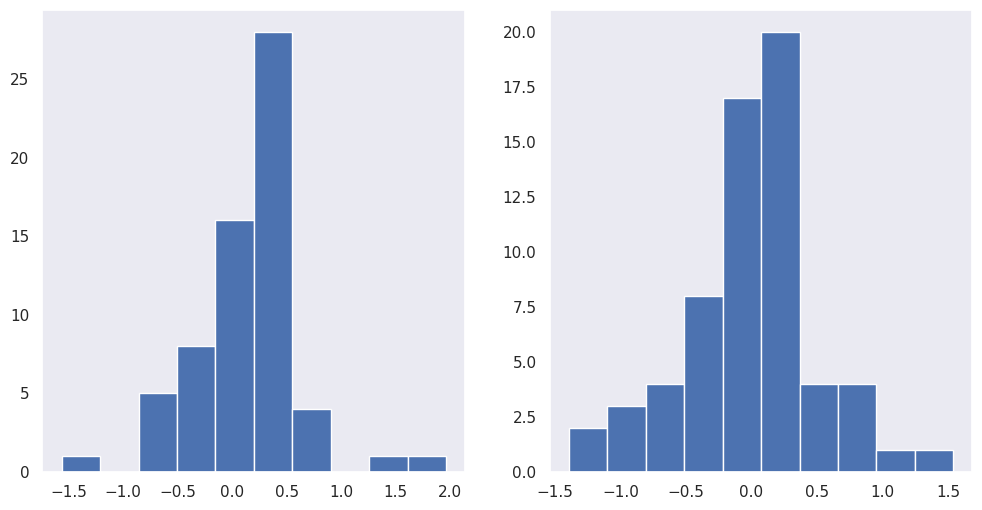

In [388]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

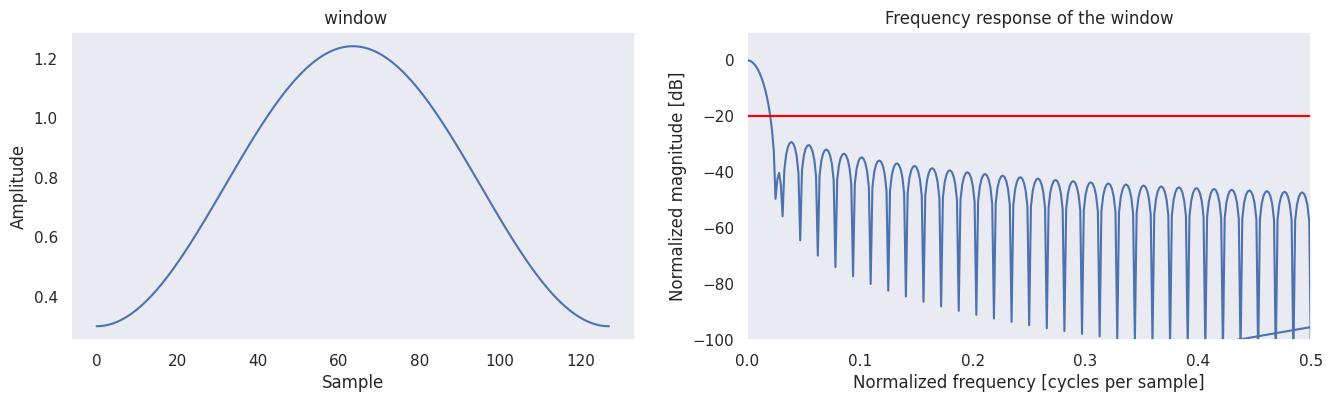

In [389]:
filtviz.visualize_one_window()

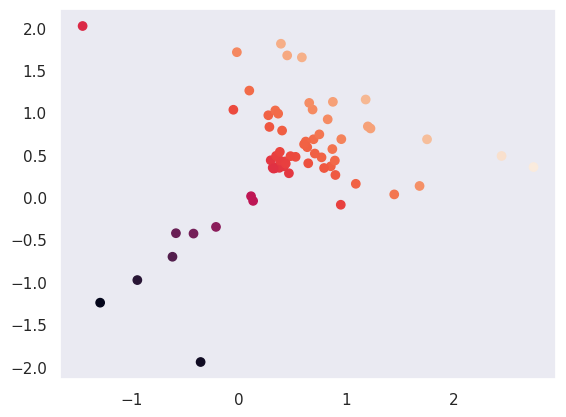

In [390]:
filtviz.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


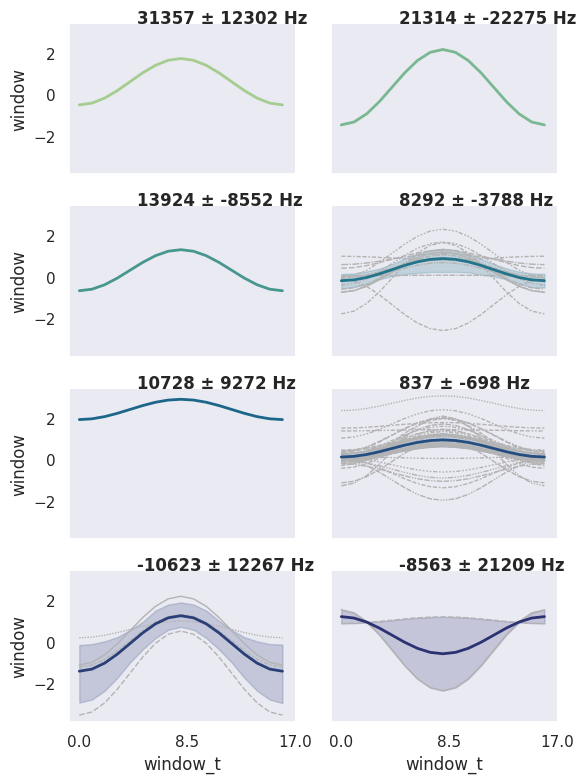

In [391]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


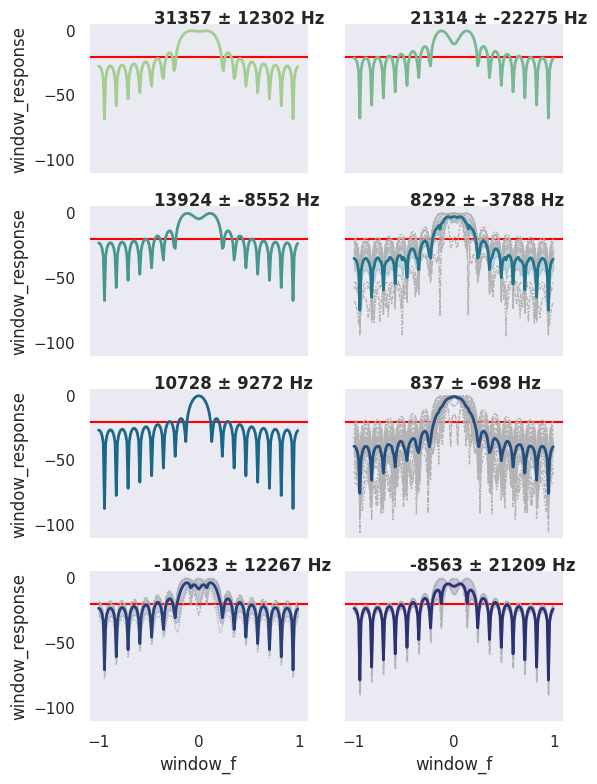

In [392]:
filtviz.visualize_filters(filter_domain='freq')

In [424]:
del model
gc.collect()

61

In [425]:
model = M10(config=model_config,
           n_input=1, n_output=2)
model

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirWinConv()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [426]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [427]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▏                                                                           | 0.02702702702702703/10 [00:00<03:16, 19.72s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.692976


 10%|███████▋                                                                     | 0.9999999999999991/10 [00:17<02:10, 14.52s/it]


Test Epoch: 1	Accuracy: 148/229 (65%)



 10%|████████                                                                      | 1.027027027027026/10 [00:17<02:21, 15.73s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.655905


 20%|███████████████▍                                                             | 1.9999999999999971/10 [00:34<01:56, 14.62s/it]


Test Epoch: 2	Accuracy: 148/229 (65%)



 20%|███████████████▊                                                              | 2.027027027027024/10 [00:34<02:05, 15.74s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.673029


 30%|███████████████████████▍                                                      | 3.000000000000003/10 [00:51<01:41, 14.49s/it]


Test Epoch: 3	Accuracy: 155/229 (68%)



 30%|███████████████████████▎                                                     | 3.0270270270270303/10 [00:52<01:49, 15.68s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.557718


 40%|███████████████████████████████▏                                              | 4.000000000000009/10 [01:08<01:28, 14.67s/it]


Test Epoch: 4	Accuracy: 155/229 (68%)



 40%|███████████████████████████████▍                                              | 4.027027027027036/10 [01:09<01:34, 15.82s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.554568


 50%|███████████████████████████████████████                                       | 5.000000000000015/10 [01:26<01:12, 14.46s/it]


Test Epoch: 5	Accuracy: 165/229 (72%)



 50%|███████████████████████████████████████▏                                      | 5.027027027027042/10 [01:27<01:18, 15.85s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.598609


 60%|██████████████████████████████████████████████▊                               | 6.000000000000021/10 [01:43<00:57, 14.47s/it]


Test Epoch: 6	Accuracy: 172/229 (75%)



 60%|██████████████████████████████████████████████▍                              | 6.0270270270270485/10 [01:44<01:02, 15.69s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.453822


 70%|█████████████████████████████████████████████████████▉                       | 7.0000000000000275/10 [02:01<00:44, 14.67s/it]


Test Epoch: 7	Accuracy: 165/229 (72%)



 70%|██████████████████████████████████████████████████████▊                       | 7.027027027027055/10 [02:01<00:46, 15.74s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.445166


 80%|██████████████████████████████████████████████████████████████▍               | 8.000000000000034/10 [02:18<00:29, 14.70s/it]


Test Epoch: 8	Accuracy: 177/229 (77%)



 80%|███████████████████████████████████████████████████████████████▍               | 8.02702702702706/10 [02:18<00:31, 15.79s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.263150


 90%|██████████████████████████████████████████████████████████████████████▏       | 9.000000000000007/10 [02:35<00:14, 14.68s/it]


Test Epoch: 9	Accuracy: 174/229 (76%)



 90%|██████████████████████████████████████████████████████████████████████▍       | 9.027027027027033/10 [02:36<00:15, 16.20s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.522685


100%|██████████████████████████████████████████████████████████████████████████████▉| 9.99999999999998/10 [02:52<00:00, 17.29s/it]


Test Epoch: 10	Accuracy: 171/229 (75%)



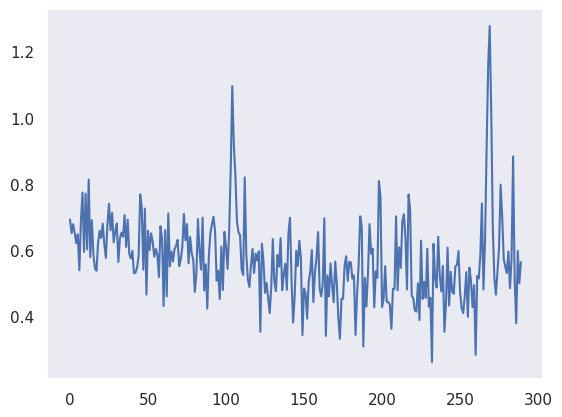

In [428]:
plt.plot(train_losses)

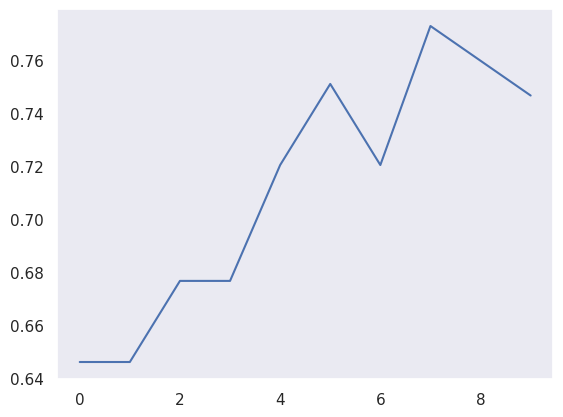

In [429]:
plt.plot(test_accuracy)

In [430]:
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 5.5078e-15],
        [-1.5602e-17],
        [ 1.6069e-17],
        [-1.2813e-17],
        [ 4.1181e-18],
        [ 9.8895e-16],
        [-1.1870e-15],
        [-2.9069e-16],
        [ 1.7271e-16],
        [ 4.0667e-17],
        [-2.7829e-17],
        [ 3.8607e-18],
        [-1.1204e-17],
        [ 3.2264e-18],
        [ 6.2277e-19],
        [ 0.0000e+00],
        [ 1.9734e-16],
        [ 3.0155e-16],
        [-2.1309e-17],
        [-4.0113e-17],
        [ 6.2610e-18],
        [ 4.1586e-17],
        [ 1.4607e-17],
        [ 6.1348e-17],
        [ 3.9710e-16],
        [-4.5017e-17],
        [ 6.2681e-19],
        [ 1.1360e-16],
        [-2.3214e-18],
        [ 8.8177e-19],
        [-2.6164e-18],
        [ 0.0000e+00],
        [ 6.2547e-16],
        [-1.0875e-17],
        [ 2.4644e-16],
        [-5.4801e-15],
        [-7.5367e-17],
        [-5.0456e-16],
        [-7.5053e-17],
        [-1.5490e-17],
        [ 4.2381e-17],
        [-6.2556e-17],
        [-1

[None, None, None]

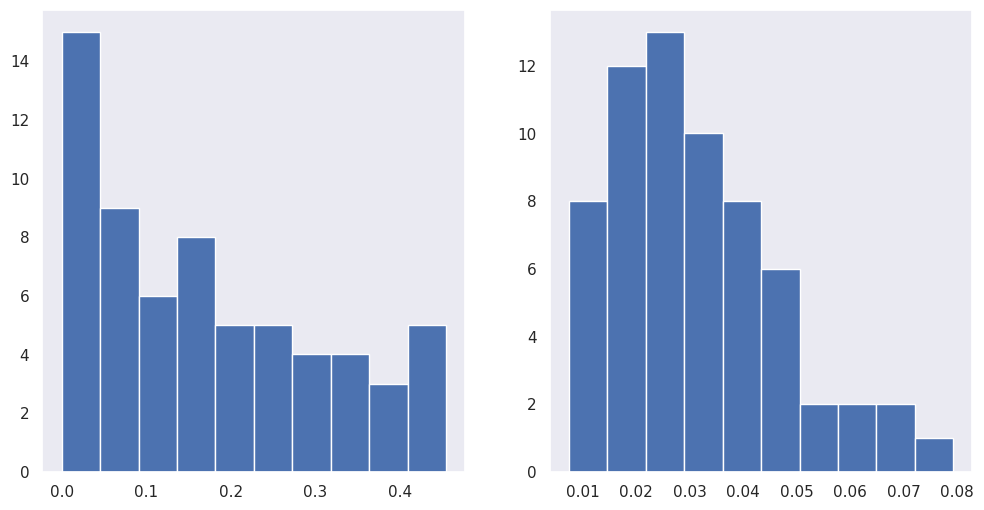

In [431]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

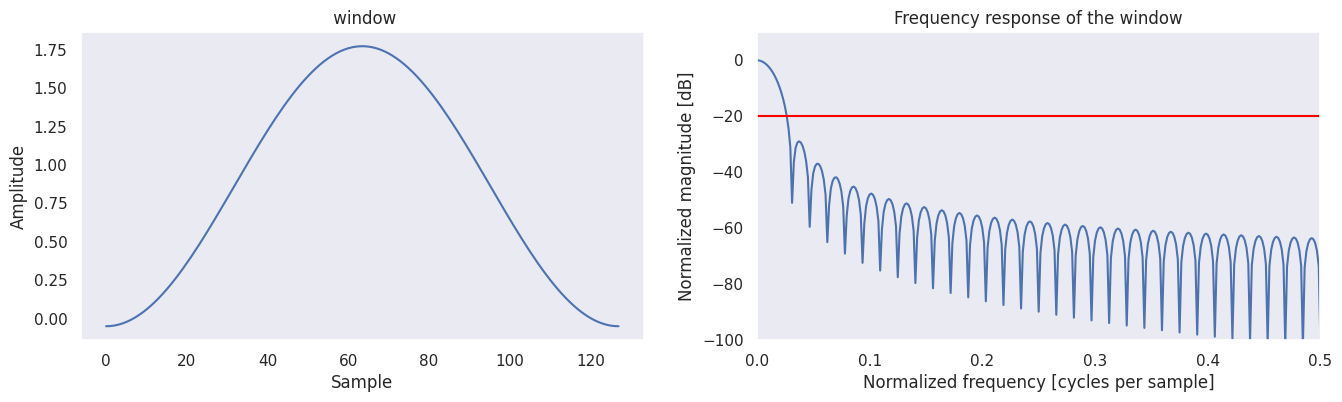

In [432]:
filtviz.visualize_one_window(n_inp=0,n_out=10)

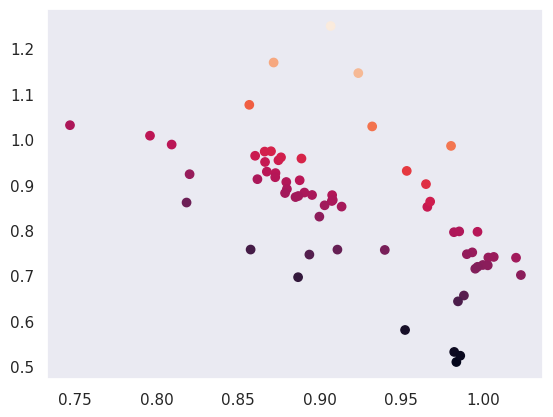

In [433]:
filtviz.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


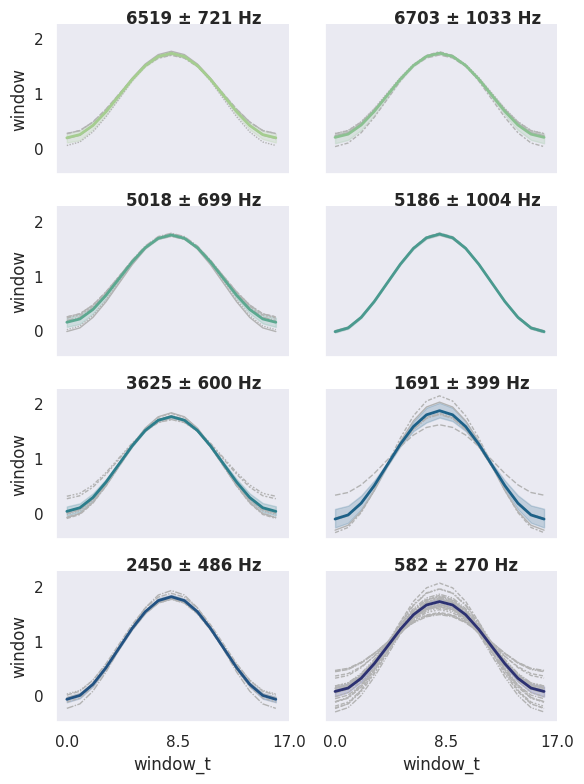

In [434]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


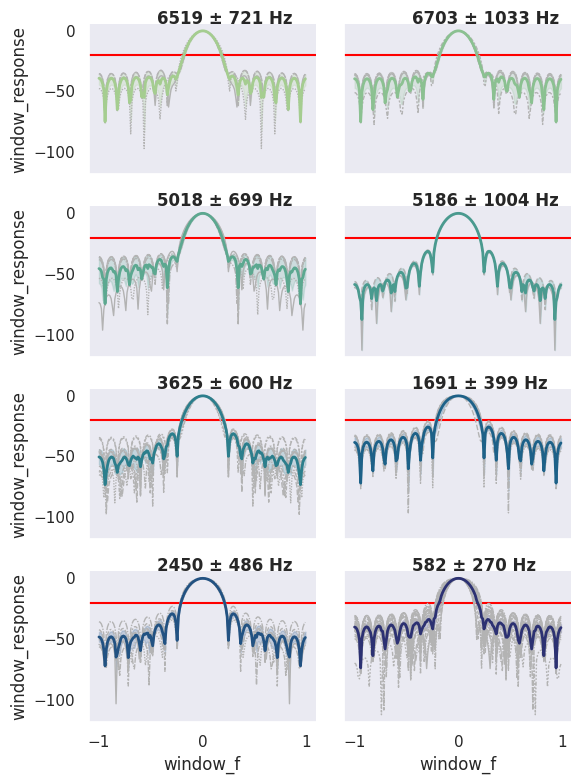

In [435]:
filtviz.visualize_filters(filter_domain='freq')

In [436]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 171/229 (0.7467)
tensor([[ 40,  41],
        [ 17, 131]], device='cuda:0')


In [438]:
n_epoch = 10
n_epoch2 = 50
optimizer = optim.RAdam(model.parameters(), lr=0.00001)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch4) as pbar:
    for epoch in range(11, 11 + n_epoch2):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        # scheduler.step()

  0%|                                                                            | 0.02702702702702703/50 [00:00<15:43, 18.89s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.564206


  2%|█▌                                                                           | 0.9999999999999991/50 [00:17<12:46, 15.64s/it]


Test Epoch: 11	Accuracy: 172/229 (75%)



  2%|█▌                                                                            | 1.027027027027026/50 [00:18<13:27, 16.49s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.549323


  4%|███                                                                          | 1.9999999999999971/50 [00:34<11:51, 14.83s/it]


Test Epoch: 12	Accuracy: 172/229 (75%)



  4%|███▏                                                                          | 2.027027027027024/50 [00:35<12:37, 15.80s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.497045


  6%|████▋                                                                         | 3.000000000000003/50 [00:52<11:37, 14.85s/it]


Test Epoch: 13	Accuracy: 172/229 (75%)



  6%|████▋                                                                        | 3.0270270270270303/50 [00:53<12:38, 16.14s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.578519


  8%|██████▏                                                                       | 4.000000000000009/50 [01:10<11:32, 15.05s/it]


Test Epoch: 14	Accuracy: 174/229 (76%)



  8%|██████▎                                                                       | 4.027027027027036/50 [01:10<12:26, 16.25s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.413832


 10%|███████▊                                                                      | 5.000000000000015/50 [01:27<10:57, 14.61s/it]


Test Epoch: 15	Accuracy: 173/229 (76%)



 10%|███████▊                                                                      | 5.027027027027042/50 [01:28<11:57, 15.96s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.441226


 12%|█████████▎                                                                    | 6.000000000000021/50 [01:45<10:57, 14.94s/it]


Test Epoch: 16	Accuracy: 172/229 (75%)



 12%|█████████▎                                                                   | 6.0270270270270485/50 [01:45<11:42, 15.97s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.539737


 14%|██████████▊                                                                  | 7.0000000000000275/50 [02:02<10:44, 14.98s/it]


Test Epoch: 17	Accuracy: 171/229 (75%)



 14%|██████████▉                                                                   | 7.027027027027055/50 [02:02<11:33, 16.13s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.614554


 16%|████████████▍                                                                 | 8.000000000000034/50 [02:20<10:08, 14.49s/it]


Test Epoch: 18	Accuracy: 173/229 (76%)



 16%|████████████▋                                                                  | 8.02702702702706/50 [02:20<10:58, 15.69s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.403577


 18%|██████████████                                                                | 9.000000000000007/50 [02:37<10:01, 14.68s/it]


Test Epoch: 19	Accuracy: 173/229 (76%)



 18%|██████████████                                                                | 9.027027027027033/50 [02:38<10:58, 16.07s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.543320


 20%|███████████████▊                                                               | 9.99999999999998/50 [02:55<09:51, 14.80s/it]


Test Epoch: 20	Accuracy: 172/229 (75%)



 20%|███████████████▍                                                             | 10.027027027027007/50 [02:55<10:38, 15.98s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.480055


 22%|████████████████▉                                                            | 10.999999999999954/50 [03:12<09:33, 14.72s/it]


Test Epoch: 21	Accuracy: 173/229 (76%)



 22%|█████████████████▏                                                            | 11.02702702702698/50 [03:13<10:18, 15.87s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.617525


 24%|██████████████████▍                                                          | 11.999999999999927/50 [03:29<09:19, 14.73s/it]


Test Epoch: 22	Accuracy: 174/229 (76%)



 24%|██████████████████▌                                                          | 12.027027027026953/50 [03:30<10:04, 15.92s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.471049


 26%|████████████████████▌                                                          | 12.9999999999999/50 [03:47<08:56, 14.49s/it]


Test Epoch: 23	Accuracy: 174/229 (76%)



 26%|████████████████████                                                         | 13.027027027026927/50 [03:47<09:40, 15.70s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.559575


 28%|█████████████████████▌                                                       | 13.999999999999874/50 [04:04<08:42, 14.51s/it]


Test Epoch: 24	Accuracy: 174/229 (76%)



 28%|██████████████████████▏                                                        | 14.0270270270269/50 [04:04<09:28, 15.81s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.390390


 30%|███████████████████████                                                      | 14.999999999999847/50 [04:22<08:32, 14.63s/it]


Test Epoch: 25	Accuracy: 174/229 (76%)



 30%|███████████████████████▏                                                     | 15.027027027026874/50 [04:22<09:08, 15.69s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.547613


 32%|████████████████████████▉                                                     | 15.99999999999982/50 [04:39<08:17, 14.62s/it]


Test Epoch: 26	Accuracy: 174/229 (76%)



 32%|████████████████████████▋                                                    | 16.027027027026847/50 [04:39<09:02, 15.97s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.411624


 34%|██████████████████████████▏                                                  | 16.999999999999858/50 [04:57<08:09, 14.83s/it]


Test Epoch: 27	Accuracy: 175/229 (76%)



 34%|██████████████████████████▏                                                  | 17.027027027026886/50 [04:57<08:41, 15.81s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.519205


 36%|███████████████████████████▋                                                 | 17.999999999999897/50 [05:14<07:47, 14.60s/it]


Test Epoch: 28	Accuracy: 175/229 (76%)



 36%|███████████████████████████▊                                                 | 18.027027027026925/50 [05:15<08:27, 15.87s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.598599


 38%|█████████████████████████████▎                                               | 18.999999999999936/50 [05:31<07:30, 14.53s/it]


Test Epoch: 29	Accuracy: 174/229 (76%)



 38%|█████████████████████████████▎                                               | 19.027027027026964/50 [05:32<08:09, 15.81s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.557540


 40%|██████████████████████████████▊                                              | 19.999999999999975/50 [05:49<07:12, 14.43s/it]


Test Epoch: 30	Accuracy: 174/229 (76%)



 40%|██████████████████████████████▊                                              | 20.027027027027003/50 [05:49<07:53, 15.81s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.470141


 42%|████████████████████████████████▎                                            | 21.000000000000014/50 [06:06<07:01, 14.53s/it]


Test Epoch: 31	Accuracy: 174/229 (76%)



 42%|████████████████████████████████▍                                            | 21.027027027027042/50 [06:06<07:34, 15.69s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.439166


 44%|█████████████████████████████████▉                                           | 22.000000000000053/50 [06:24<06:53, 14.77s/it]


Test Epoch: 32	Accuracy: 174/229 (76%)



 44%|██████████████████████████████████▎                                           | 22.02702702702708/50 [06:25<07:31, 16.13s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.519042


 46%|███████████████████████████████████▍                                         | 23.000000000000092/50 [06:42<06:39, 14.78s/it]


Test Epoch: 33	Accuracy: 174/229 (76%)



 46%|███████████████████████████████████▉                                          | 23.02702702702712/50 [06:43<07:19, 16.28s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.606094


 48%|█████████████████████████████████████▍                                        | 24.00000000000013/50 [07:00<06:22, 14.73s/it]


Test Epoch: 34	Accuracy: 174/229 (76%)



 48%|█████████████████████████████████████▍                                        | 24.02702702702716/50 [07:00<07:04, 16.35s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.443812


 50%|███████████████████████████████████████                                       | 25.00000000000017/50 [07:17<06:20, 15.23s/it]


Test Epoch: 35	Accuracy: 174/229 (76%)



 50%|███████████████████████████████████████▌                                       | 25.0270270270272/50 [07:18<06:52, 16.50s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.548883


 52%|████████████████████████████████████████▌                                     | 26.00000000000021/50 [07:35<06:02, 15.11s/it]


Test Epoch: 36	Accuracy: 174/229 (76%)



 52%|████████████████████████████████████████                                     | 26.027027027027238/50 [07:35<06:30, 16.31s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.469219


 54%|██████████████████████████████████████████                                    | 27.00000000000025/50 [07:52<05:38, 14.73s/it]


Test Epoch: 37	Accuracy: 174/229 (76%)



 54%|█████████████████████████████████████████▌                                   | 27.027027027027277/50 [07:53<06:05, 15.91s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.435049


 56%|███████████████████████████████████████████                                  | 28.000000000000288/50 [08:10<05:17, 14.43s/it]


Test Epoch: 38	Accuracy: 174/229 (76%)



 56%|███████████████████████████████████████████▏                                 | 28.027027027027316/50 [08:10<05:47, 15.80s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.446938


 58%|████████████████████████████████████████████▋                                | 29.000000000000327/50 [08:27<05:09, 14.75s/it]


Test Epoch: 39	Accuracy: 174/229 (76%)



 58%|████████████████████████████████████████████▋                                | 29.027027027027355/50 [08:27<05:35, 15.99s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.571591


 60%|██████████████████████████████████████████████▏                              | 30.000000000000366/50 [08:44<04:52, 14.64s/it]


Test Epoch: 40	Accuracy: 174/229 (76%)



 60%|██████████████████████████████████████████████▏                              | 30.027027027027394/50 [08:45<05:15, 15.81s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.552064


 62%|███████████████████████████████████████████████▋                             | 31.000000000000405/50 [09:03<04:37, 14.60s/it]


Test Epoch: 41	Accuracy: 173/229 (76%)



 62%|███████████████████████████████████████████████▊                             | 31.027027027027433/50 [09:04<05:00, 15.85s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.618086


 64%|█████████████████████████████████████████████████▉                            | 32.00000000000044/50 [09:21<04:28, 14.91s/it]


Test Epoch: 42	Accuracy: 173/229 (76%)



 64%|█████████████████████████████████████████████████▎                           | 32.027027027027465/50 [09:21<04:49, 16.11s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.423887


 66%|███████████████████████████████████████████████████▍                          | 33.00000000000035/50 [09:38<04:08, 14.62s/it]


Test Epoch: 43	Accuracy: 173/229 (76%)



 66%|███████████████████████████████████████████████████▌                          | 33.02702702702737/50 [09:39<04:29, 15.89s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.477256


 68%|████████████████████████████████████████████████████▎                        | 34.000000000000256/50 [09:56<03:51, 14.47s/it]


Test Epoch: 44	Accuracy: 173/229 (76%)



 68%|█████████████████████████████████████████████████████                         | 34.02702702702728/50 [09:56<04:10, 15.67s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.359641


 70%|██████████████████████████████████████████████████████▌                       | 35.00000000000016/50 [10:13<03:39, 14.61s/it]


Test Epoch: 45	Accuracy: 173/229 (76%)



 70%|██████████████████████████████████████████████████████▋                       | 35.02702702702719/50 [10:14<03:59, 16.03s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.455925


 72%|████████████████████████████████████████████████████████▏                     | 36.00000000000007/50 [10:31<03:25, 14.65s/it]


Test Epoch: 46	Accuracy: 173/229 (76%)



 72%|███████████████████████████████████████████████████████▍                     | 36.027027027027096/50 [10:31<03:46, 16.19s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.510538


 74%|█████████████████████████████████████████████████████████▋                    | 36.99999999999998/50 [10:48<03:12, 14.79s/it]


Test Epoch: 47	Accuracy: 173/229 (76%)



 74%|███████████████████████████████████████████████████████████▏                    | 37.027027027027/50 [10:48<03:28, 16.11s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.506373


 76%|██████████████████████████████████████████████████████████▌                  | 37.999999999999886/50 [11:05<02:55, 14.62s/it]


Test Epoch: 48	Accuracy: 174/229 (76%)



 76%|███████████████████████████████████████████████████████████▎                  | 38.02702702702691/50 [11:06<03:10, 15.88s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.466510


 78%|████████████████████████████████████████████████████████████                 | 38.999999999999794/50 [11:23<02:41, 14.71s/it]


Test Epoch: 49	Accuracy: 174/229 (76%)



 78%|████████████████████████████████████████████████████████████▉                 | 39.02702702702682/50 [11:23<02:53, 15.79s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.514031


 80%|███████████████████████████████████████████████████████████████▏               | 39.9999999999997/50 [11:41<02:27, 14.78s/it]


Test Epoch: 50	Accuracy: 173/229 (76%)



 80%|█████████████████████████████████████████████████████████████▋               | 40.027027027026726/50 [11:41<02:40, 16.06s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.433718


 82%|███████████████████████████████████████████████████████████████▉              | 40.99999999999961/50 [11:58<02:14, 14.94s/it]


Test Epoch: 51	Accuracy: 173/229 (76%)



 82%|███████████████████████████████████████████████████████████████▏             | 41.027027027026634/50 [11:59<02:24, 16.07s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 0.523152


 84%|█████████████████████████████████████████████████████████████████▌            | 41.99999999999952/50 [12:16<01:57, 14.70s/it]


Test Epoch: 52	Accuracy: 173/229 (76%)



 84%|█████████████████████████████████████████████████████████████████▌            | 42.02702702702654/50 [12:16<02:07, 16.04s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.475880


 86%|██████████████████████████████████████████████████████████████████▏          | 42.999999999999424/50 [12:33<01:43, 14.84s/it]


Test Epoch: 53	Accuracy: 173/229 (76%)



 86%|███████████████████████████████████████████████████████████████████           | 43.02702702702645/50 [12:34<01:51, 15.93s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.421704


 88%|████████████████████████████████████████████████████████████████████▋         | 43.99999999999933/50 [12:51<01:28, 14.75s/it]


Test Epoch: 54	Accuracy: 173/229 (76%)



 88%|████████████████████████████████████████████████████████████████████▋         | 44.02702702702636/50 [12:52<01:35, 15.99s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.423479


 90%|██████████████████████████████████████████████████████████████████████▏       | 44.99999999999924/50 [13:09<01:14, 14.96s/it]


Test Epoch: 55	Accuracy: 173/229 (76%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 45.027027027026264/50 [13:09<01:19, 16.03s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.454622


 92%|███████████████████████████████████████████████████████████████████████▊      | 45.99999999999915/50 [13:26<01:05, 16.38s/it]


Test Epoch: 56	Accuracy: 173/229 (76%)



 92%|███████████████████████████████████████████████████████████████████████▊      | 46.02702702702617/50 [13:27<01:07, 17.05s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.483891


 94%|████████████████████████████████████████████████████████████████████████▍    | 46.999999999999055/50 [13:44<00:44, 14.80s/it]


Test Epoch: 57	Accuracy: 173/229 (76%)



 94%|█████████████████████████████████████████████████████████████████████████▎    | 47.02702702702608/50 [13:45<00:48, 16.38s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.556207


 96%|██████████████████████████████████████████████████████████████████████████▉   | 47.99999999999896/50 [14:02<00:29, 14.71s/it]


Test Epoch: 58	Accuracy: 173/229 (76%)



 96%|██████████████████████████████████████████████████████████████████████████▉   | 48.02702702702599/50 [14:02<00:31, 15.90s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.467485


 98%|████████████████████████████████████████████████████████████████████████████▍ | 48.99999999999887/50 [14:19<00:14, 14.53s/it]


Test Epoch: 59	Accuracy: 173/229 (76%)



 98%|███████████████████████████████████████████████████████████████████████████▌ | 49.027027027025895/50 [14:20<00:15, 15.71s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.451721


100%|█████████████████████████████████████████████████████████████████████████████▉| 49.99999999999878/50 [14:37<00:00, 17.54s/it]


Test Epoch: 60	Accuracy: 174/229 (76%)



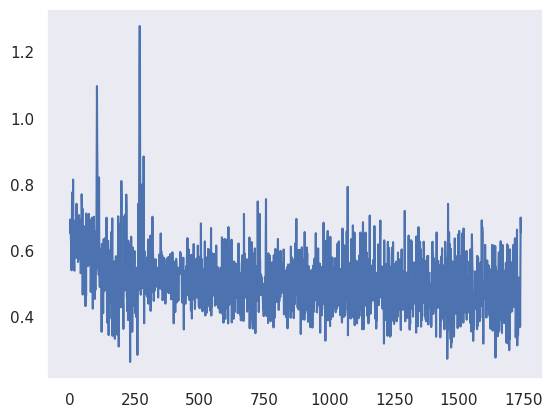

In [439]:
plt.plot(train_losses)

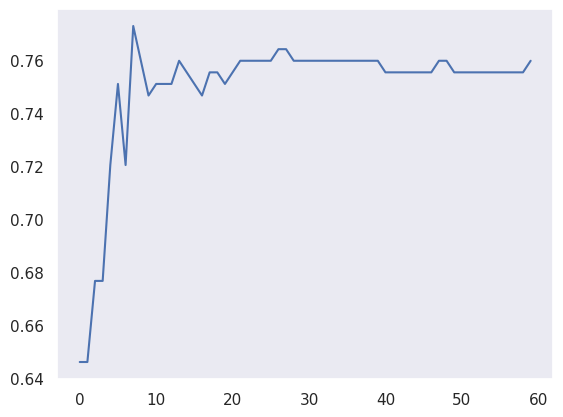

In [440]:
plt.plot(test_accuracy)

In [441]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 174/229 (0.7598)
tensor([[ 31,  50],
        [  5, 143]], device='cuda:0')


In [442]:
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-9.1688e-15],
        [ 2.1305e-17],
        [ 3.5218e-18],
        [ 2.7414e-18],
        [-2.0196e-16],
        [-6.9207e-16],
        [ 5.7099e-16],
        [ 1.6564e-16],
        [-6.5533e-17],
        [-1.6369e-17],
        [ 1.4323e-17],
        [ 2.0033e-18],
        [ 3.6811e-18],
        [-1.5093e-18],
        [-5.8176e-19],
        [ 0.0000e+00],
        [ 6.1773e-15],
        [ 8.3445e-16],
        [ 1.7732e-17],
        [ 4.4706e-17],
        [-4.6021e-18],
        [-2.2972e-17],
        [-4.0633e-18],
        [-4.3975e-17],
        [-1.7211e-16],
        [ 1.9439e-17],
        [-6.8508e-19],
        [-4.1286e-17],
        [ 2.2139e-18],
        [-1.4913e-18],
        [ 2.2311e-18],
        [ 0.0000e+00],
        [-5.7879e-16],
        [ 6.5802e-18],
        [-1.4007e-16],
        [ 5.2484e-15],
        [-5.0707e-16],
        [ 2.1638e-16],
        [ 4.2315e-17],
        [ 6.5866e-18],
        [-1.9801e-17],
        [ 2.5722e-17],
        [ 4

[None, None, None]

In [458]:
b0 = layer.lowcut_bands.detach().cpu().numpy().flatten()
b0_grad = layer.lowcut_bands.grad.detach().cpu().numpy().flatten()

In [462]:
b0[b0_grad==0]

array([0., 0., 0., 0.], dtype=float32)

In [463]:
bw0 = layer.bandwidths.detach().cpu().numpy().flatten()
bw0_grad = layer.bandwidths.grad.detach().cpu().numpy().flatten()
bw0[bw0_grad==0]

array([], dtype=float32)

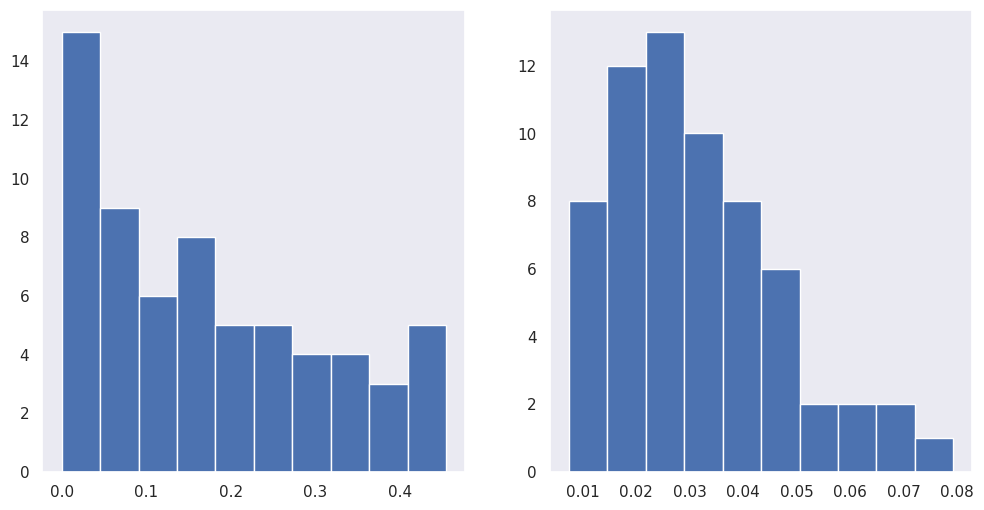

In [465]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

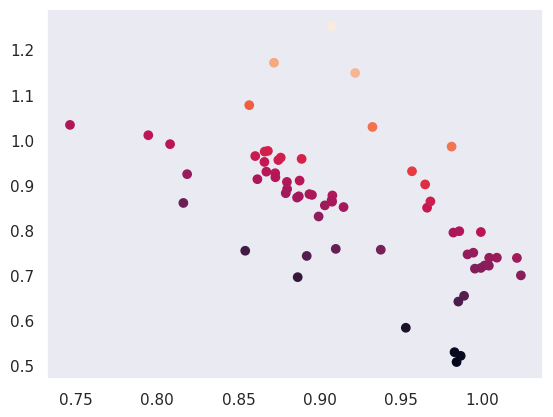

In [466]:
filtviz.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


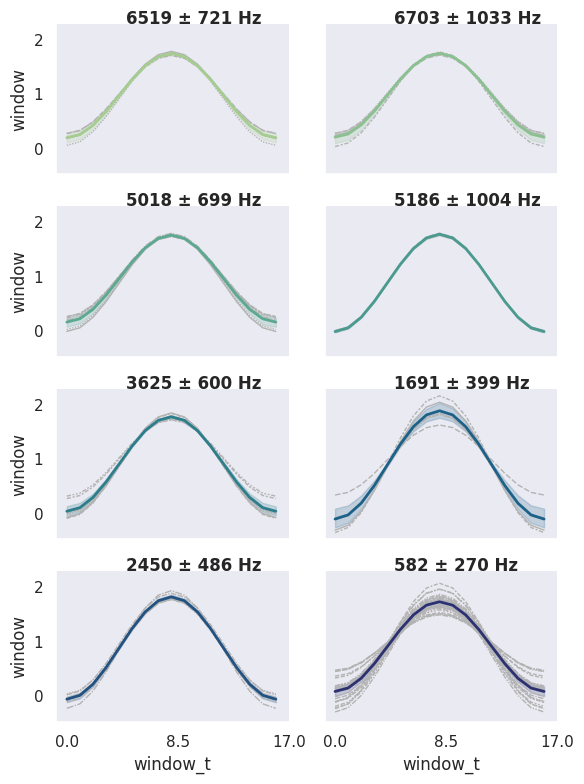

In [467]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


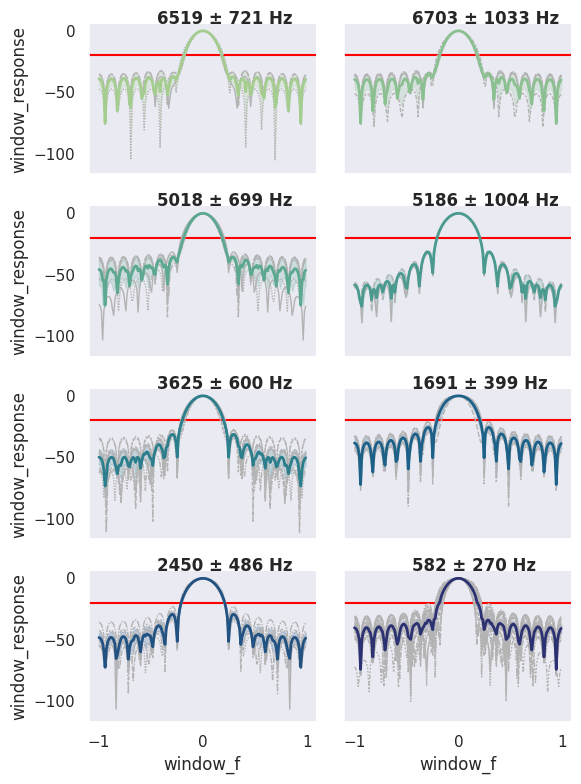

In [468]:
filtviz.visualize_filters(filter_domain='freq')

In [469]:
n_epoch = 10
n_epoch2 = 50
n_epoch3 = 40
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch3)
with tqdm(total=n_epoch3) as pbar:
    for epoch in range(1 + n_epoch + n_epoch2, 1 + n_epoch + n_epoch2 + n_epoch3):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                            | 0.02702702702702703/40 [00:00<13:23, 20.09s/it]

Train Epoch: 61 [0/913 (0%)]	Loss: 0.389008


  2%|█▉                                                                           | 0.9999999999999991/40 [00:17<10:01, 15.42s/it]


Test Epoch: 61	Accuracy: 174/229 (76%)



  3%|██                                                                            | 1.027027027027026/40 [00:18<10:44, 16.55s/it]

Train Epoch: 62 [0/913 (0%)]	Loss: 0.503221


  5%|███▊                                                                         | 1.9999999999999971/40 [00:35<09:25, 14.87s/it]


Test Epoch: 62	Accuracy: 179/229 (78%)



  5%|███▉                                                                          | 2.027027027027024/40 [00:36<10:04, 15.93s/it]

Train Epoch: 63 [0/913 (0%)]	Loss: 0.553295


  8%|█████▊                                                                        | 3.000000000000003/40 [00:53<09:10, 14.88s/it]


Test Epoch: 63	Accuracy: 176/229 (77%)



  8%|█████▊                                                                       | 3.0270270270270303/40 [00:53<09:54, 16.07s/it]

Train Epoch: 64 [0/913 (0%)]	Loss: 0.432924


 10%|███████▊                                                                      | 4.000000000000009/40 [01:10<08:53, 14.82s/it]


Test Epoch: 64	Accuracy: 179/229 (78%)



 10%|███████▊                                                                      | 4.027027027027036/40 [01:11<09:31, 15.90s/it]

Train Epoch: 65 [0/913 (0%)]	Loss: 0.334962


 13%|█████████▊                                                                    | 5.000000000000015/40 [01:28<08:36, 14.75s/it]


Test Epoch: 65	Accuracy: 172/229 (75%)



 13%|█████████▊                                                                    | 5.027027027027042/40 [01:28<09:14, 15.85s/it]

Train Epoch: 66 [0/913 (0%)]	Loss: 0.489765


 15%|███████████▋                                                                  | 6.000000000000021/40 [01:45<08:42, 15.36s/it]


Test Epoch: 66	Accuracy: 166/229 (72%)



 15%|███████████▌                                                                 | 6.0270270270270485/40 [01:46<09:12, 16.27s/it]

Train Epoch: 67 [0/913 (0%)]	Loss: 0.412586


 18%|█████████████▍                                                               | 7.0000000000000275/40 [02:03<08:11, 14.89s/it]


Test Epoch: 67	Accuracy: 167/229 (73%)



 18%|█████████████▋                                                                | 7.027027027027055/40 [02:03<08:44, 15.92s/it]

Train Epoch: 68 [0/913 (0%)]	Loss: 0.538444


 20%|███████████████▌                                                              | 8.000000000000034/40 [02:20<08:35, 16.10s/it]


Test Epoch: 68	Accuracy: 181/229 (79%)



 20%|███████████████▊                                                               | 8.02702702702706/40 [02:21<09:02, 16.98s/it]

Train Epoch: 69 [0/913 (0%)]	Loss: 0.439545


 23%|█████████████████▌                                                            | 9.000000000000007/40 [02:40<07:56, 15.39s/it]


Test Epoch: 69	Accuracy: 172/229 (75%)



 23%|█████████████████▌                                                            | 9.027027027027033/40 [02:40<08:26, 16.35s/it]

Train Epoch: 70 [0/913 (0%)]	Loss: 0.497627


 25%|███████████████████▋                                                           | 9.99999999999998/40 [02:57<07:28, 14.94s/it]


Test Epoch: 70	Accuracy: 171/229 (75%)



 25%|███████████████████▎                                                         | 10.027027027027007/40 [02:58<07:59, 15.98s/it]

Train Epoch: 71 [0/913 (0%)]	Loss: 0.444070


 27%|█████████████████████▏                                                       | 10.999999999999954/40 [03:15<07:08, 14.76s/it]


Test Epoch: 71	Accuracy: 177/229 (77%)



 28%|█████████████████████▌                                                        | 11.02702702702698/40 [03:15<07:45, 16.07s/it]

Train Epoch: 72 [0/913 (0%)]	Loss: 0.528021


 30%|███████████████████████                                                      | 11.999999999999927/40 [03:32<06:51, 14.71s/it]


Test Epoch: 72	Accuracy: 165/229 (72%)



 30%|███████████████████████▏                                                     | 12.027027027026953/40 [03:33<07:36, 16.31s/it]

Train Epoch: 73 [0/913 (0%)]	Loss: 0.472598


 32%|█████████████████████████▋                                                     | 12.9999999999999/40 [03:50<06:31, 14.51s/it]


Test Epoch: 73	Accuracy: 172/229 (75%)



 33%|█████████████████████████                                                    | 13.027027027026927/40 [03:50<07:08, 15.88s/it]

Train Epoch: 74 [0/913 (0%)]	Loss: 0.376557


 35%|██████████████████████████▉                                                  | 13.999999999999874/40 [04:07<06:23, 14.77s/it]


Test Epoch: 74	Accuracy: 175/229 (76%)



 35%|███████████████████████████▋                                                   | 14.0270270270269/40 [04:07<06:53, 15.91s/it]

Train Epoch: 75 [0/913 (0%)]	Loss: 0.459112


 37%|████████████████████████████▊                                                | 14.999999999999847/40 [04:24<06:15, 15.02s/it]


Test Epoch: 75	Accuracy: 164/229 (72%)



 38%|████████████████████████████▉                                                | 15.027027027026874/40 [04:25<06:41, 16.09s/it]

Train Epoch: 76 [0/913 (0%)]	Loss: 0.570475


 40%|███████████████████████████████▏                                              | 15.99999999999982/40 [04:42<05:52, 14.71s/it]


Test Epoch: 76	Accuracy: 169/229 (74%)



 40%|██████████████████████████████▊                                              | 16.027027027026847/40 [04:43<06:30, 16.29s/it]

Train Epoch: 77 [0/913 (0%)]	Loss: 0.568592


 42%|████████████████████████████████▋                                            | 16.999999999999858/40 [04:59<05:49, 15.21s/it]


Test Epoch: 77	Accuracy: 162/229 (71%)



 43%|████████████████████████████████▊                                            | 17.027027027026886/40 [05:00<06:13, 16.26s/it]

Train Epoch: 78 [0/913 (0%)]	Loss: 0.945246


 45%|██████████████████████████████████▋                                          | 17.999999999999897/40 [05:17<05:22, 14.67s/it]


Test Epoch: 78	Accuracy: 180/229 (79%)



 45%|██████████████████████████████████▋                                          | 18.027027027026925/40 [05:17<05:54, 16.15s/it]

Train Epoch: 79 [0/913 (0%)]	Loss: 0.383457


 47%|████████████████████████████████████▌                                        | 18.999999999999936/40 [05:34<05:14, 14.97s/it]


Test Epoch: 79	Accuracy: 182/229 (79%)



 48%|████████████████████████████████████▋                                        | 19.027027027026964/40 [05:35<05:36, 16.06s/it]

Train Epoch: 80 [0/913 (0%)]	Loss: 0.348460


 50%|██████████████████████████████████████▍                                      | 19.999999999999975/40 [05:52<04:54, 14.73s/it]


Test Epoch: 80	Accuracy: 172/229 (75%)



 50%|██████████████████████████████████████▌                                      | 20.027027027027003/40 [05:52<05:16, 15.83s/it]

Train Epoch: 81 [0/913 (0%)]	Loss: 0.589210


 53%|████████████████████████████████████████▍                                    | 21.000000000000014/40 [06:09<04:42, 14.89s/it]


Test Epoch: 81	Accuracy: 180/229 (79%)



 53%|████████████████████████████████████████▍                                    | 21.027027027027042/40 [06:10<05:08, 16.28s/it]

Train Epoch: 82 [0/913 (0%)]	Loss: 0.389669


 55%|██████████████████████████████████████████▎                                  | 22.000000000000053/40 [06:27<04:36, 15.36s/it]


Test Epoch: 82	Accuracy: 171/229 (75%)



 55%|██████████████████████████████████████████▉                                   | 22.02702702702708/40 [06:28<04:59, 16.65s/it]

Train Epoch: 83 [0/913 (0%)]	Loss: 0.670746


 58%|████████████████████████████████████████████▎                                | 23.000000000000092/40 [06:45<04:14, 14.98s/it]


Test Epoch: 83	Accuracy: 173/229 (76%)



 58%|████████████████████████████████████████████▉                                 | 23.02702702702712/40 [06:45<04:32, 16.05s/it]

Train Epoch: 84 [0/913 (0%)]	Loss: 0.505085


 60%|██████████████████████████████████████████████▊                               | 24.00000000000013/40 [07:02<04:04, 15.31s/it]


Test Epoch: 84	Accuracy: 170/229 (74%)



 60%|██████████████████████████████████████████████▊                               | 24.02702702702716/40 [07:03<04:27, 16.76s/it]

Train Epoch: 85 [0/913 (0%)]	Loss: 0.464510


 63%|████████████████████████████████████████████████▊                             | 25.00000000000017/40 [07:20<03:40, 14.71s/it]


Test Epoch: 85	Accuracy: 176/229 (77%)



 63%|█████████████████████████████████████████████████▍                             | 25.0270270270272/40 [07:20<03:58, 15.91s/it]

Train Epoch: 86 [0/913 (0%)]	Loss: 0.362075


 65%|██████████████████████████████████████████████████▋                           | 26.00000000000021/40 [07:38<03:28, 14.89s/it]


Test Epoch: 86	Accuracy: 174/229 (76%)



 65%|██████████████████████████████████████████████████                           | 26.027027027027238/40 [07:38<03:44, 16.07s/it]

Train Epoch: 87 [0/913 (0%)]	Loss: 0.368182


 68%|████████████████████████████████████████████████████▋                         | 27.00000000000025/40 [07:56<03:20, 15.41s/it]


Test Epoch: 87	Accuracy: 145/229 (63%)



 68%|████████████████████████████████████████████████████                         | 27.027027027027277/40 [07:56<03:37, 16.80s/it]

Train Epoch: 88 [0/913 (0%)]	Loss: 0.757797


 70%|█████████████████████████████████████████████████████▉                       | 28.000000000000288/40 [08:13<02:57, 14.82s/it]


Test Epoch: 88	Accuracy: 185/229 (81%)



 70%|█████████████████████████████████████████████████████▉                       | 28.027027027027316/40 [08:14<03:13, 16.15s/it]

Train Epoch: 89 [0/913 (0%)]	Loss: 0.528147


 73%|███████████████████████████████████████████████████████▊                     | 29.000000000000327/40 [08:31<02:44, 14.91s/it]


Test Epoch: 89	Accuracy: 154/229 (67%)



 73%|███████████████████████████████████████████████████████▉                     | 29.027027027027355/40 [08:31<02:56, 16.10s/it]

Train Epoch: 90 [0/913 (0%)]	Loss: 0.567925


 75%|█████████████████████████████████████████████████████████▊                   | 30.000000000000366/40 [08:48<02:27, 14.71s/it]


Test Epoch: 90	Accuracy: 186/229 (81%)



 75%|█████████████████████████████████████████████████████████▊                   | 30.027027027027394/40 [08:49<02:40, 16.04s/it]

Train Epoch: 91 [0/913 (0%)]	Loss: 0.402350


 78%|███████████████████████████████████████████████████████████▋                 | 31.000000000000405/40 [09:06<02:19, 15.54s/it]


Test Epoch: 91	Accuracy: 165/229 (72%)



 78%|███████████████████████████████████████████████████████████▋                 | 31.027027027027433/40 [09:07<02:28, 16.52s/it]

Train Epoch: 92 [0/913 (0%)]	Loss: 0.479663


 80%|██████████████████████████████████████████████████████████████▍               | 32.00000000000044/40 [09:24<01:58, 14.75s/it]


Test Epoch: 92	Accuracy: 185/229 (81%)



 80%|█████████████████████████████████████████████████████████████▋               | 32.027027027027465/40 [09:25<02:08, 16.14s/it]

Train Epoch: 93 [0/913 (0%)]	Loss: 0.343755


 83%|████████████████████████████████████████████████████████████████▎             | 33.00000000000035/40 [09:42<01:42, 14.65s/it]


Test Epoch: 93	Accuracy: 164/229 (72%)



 83%|████████████████████████████████████████████████████████████████▍             | 33.02702702702737/40 [09:42<01:51, 15.98s/it]

Train Epoch: 94 [0/913 (0%)]	Loss: 0.593802


 85%|█████████████████████████████████████████████████████████████████▍           | 34.000000000000256/40 [10:00<01:29, 14.89s/it]


Test Epoch: 94	Accuracy: 181/229 (79%)



 85%|██████████████████████████████████████████████████████████████████▎           | 34.02702702702728/40 [10:00<01:36, 16.10s/it]

Train Epoch: 95 [0/913 (0%)]	Loss: 0.391199


 88%|████████████████████████████████████████████████████████████████████▎         | 35.00000000000016/40 [10:17<01:13, 14.74s/it]


Test Epoch: 95	Accuracy: 170/229 (74%)



 88%|████████████████████████████████████████████████████████████████████▎         | 35.02702702702719/40 [10:18<01:19, 16.08s/it]

Train Epoch: 96 [0/913 (0%)]	Loss: 0.425980


 90%|██████████████████████████████████████████████████████████████████████▏       | 36.00000000000007/40 [10:35<00:59, 14.82s/it]


Test Epoch: 96	Accuracy: 179/229 (78%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 36.027027027027096/40 [10:36<01:03, 16.03s/it]

Train Epoch: 97 [0/913 (0%)]	Loss: 0.408810


 92%|████████████████████████████████████████████████████████████████████████▏     | 36.99999999999998/40 [10:53<00:44, 14.85s/it]


Test Epoch: 97	Accuracy: 185/229 (81%)



 93%|██████████████████████████████████████████████████████████████████████████      | 37.027027027027/40 [10:54<00:47, 16.10s/it]

Train Epoch: 98 [0/913 (0%)]	Loss: 0.426577


 95%|█████████████████████████████████████████████████████████████████████████▏   | 37.999999999999886/40 [11:11<00:29, 14.75s/it]


Test Epoch: 98	Accuracy: 164/229 (72%)



 95%|██████████████████████████████████████████████████████████████████████████▏   | 38.02702702702691/40 [11:11<00:31, 15.99s/it]

Train Epoch: 99 [0/913 (0%)]	Loss: 0.313341


 97%|███████████████████████████████████████████████████████████████████████████  | 38.999999999999794/40 [11:28<00:14, 14.55s/it]


Test Epoch: 99	Accuracy: 133/229 (58%)



 98%|████████████████████████████████████████████████████████████████████████████  | 39.02702702702682/40 [11:29<00:15, 16.01s/it]

Train Epoch: 100 [0/913 (0%)]	Loss: 1.593420


100%|██████████████████████████████████████████████████████████████████████████████▉| 39.9999999999997/40 [11:46<00:00, 17.67s/it]


Test Epoch: 100	Accuracy: 183/229 (80%)



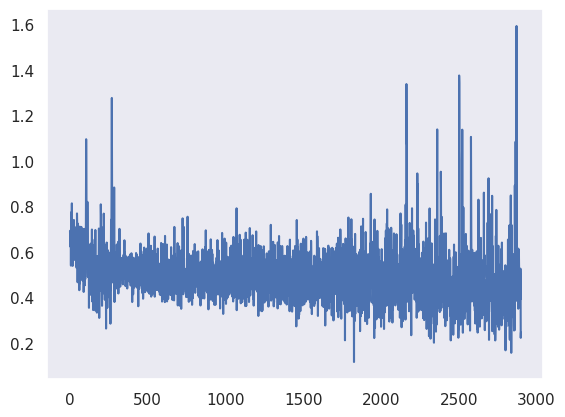

In [470]:
plt.plot(train_losses)

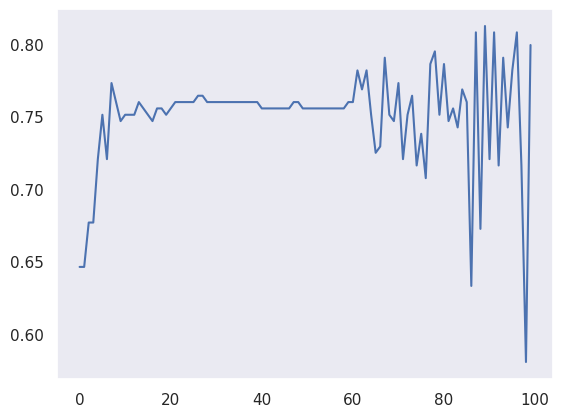

In [471]:
plt.plot(test_accuracy)

In [472]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 183/229 (0.7991)
tensor([[ 37,  44],
        [  2, 146]], device='cuda:0')


In [473]:
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [-1.5102e-14],
        [ 1.4966e-16],
        [ 1.7226e-17],
        [ 7.9047e-18],
        [ 1.5239e-16],
        [-1.1606e-15],
        [ 1.1581e-15],
        [ 3.8529e-16],
        [ 6.9741e-16],
        [ 8.2676e-18],
        [ 4.0420e-17],
        [ 2.5590e-17],
        [-1.6918e-17],
        [ 2.9282e-18],
        [-2.8630e-18],
        [ 0.0000e+00],
        [ 3.4415e-14],
        [ 1.1467e-14],
        [ 1.6425e-15],
        [-4.8753e-17],
        [-1.0063e-16],
        [-1.8273e-18],
        [-3.9445e-18],
        [-9.5490e-17],
        [ 1.8866e-16],
        [ 2.6517e-17],
        [-1.8285e-18],
        [ 7.6476e-17],
        [ 1.5820e-17],
        [-7.3918e-18],
        [ 1.7193e-17],
        [ 0.0000e+00],
        [-7.9061e-15],
        [-2.7219e-18],
        [-6.1914e-16],
        [ 3.8209e-15],
        [ 2.5216e-14],
        [-1.7454e-16],
        [ 3.9123e-17],
        [-9.7108e-18],
        [-1.6523e-17],
        [-1.7676e-17],
        [-9

[None, None, None]

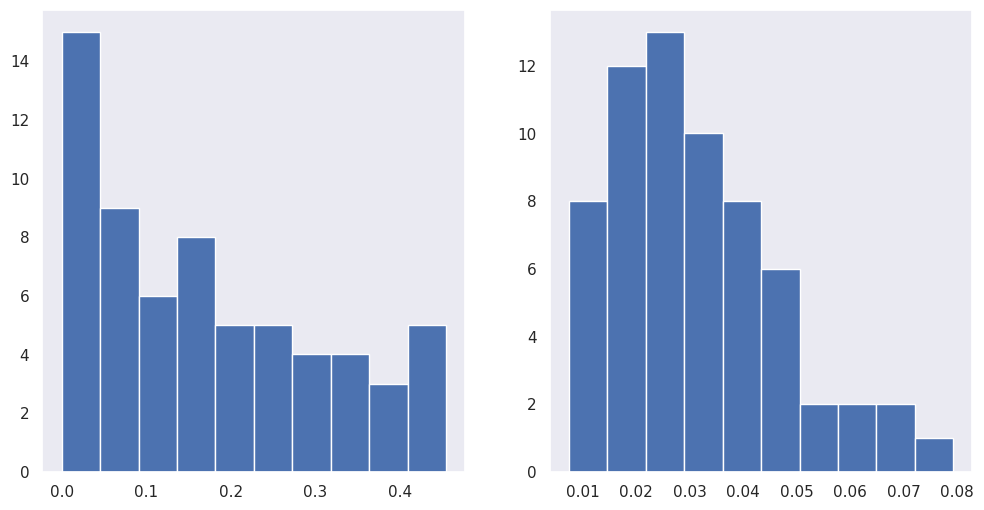

In [474]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

Time domain: Filters' shapes vary by frequency bins


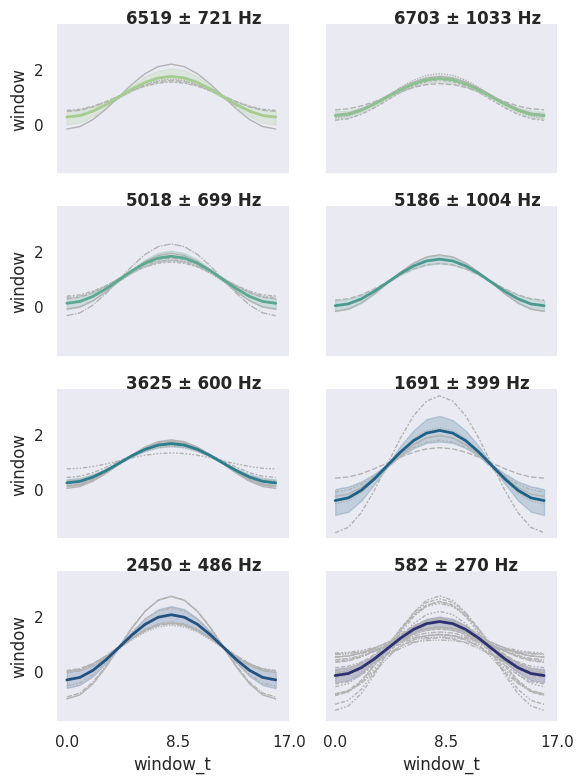

In [475]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


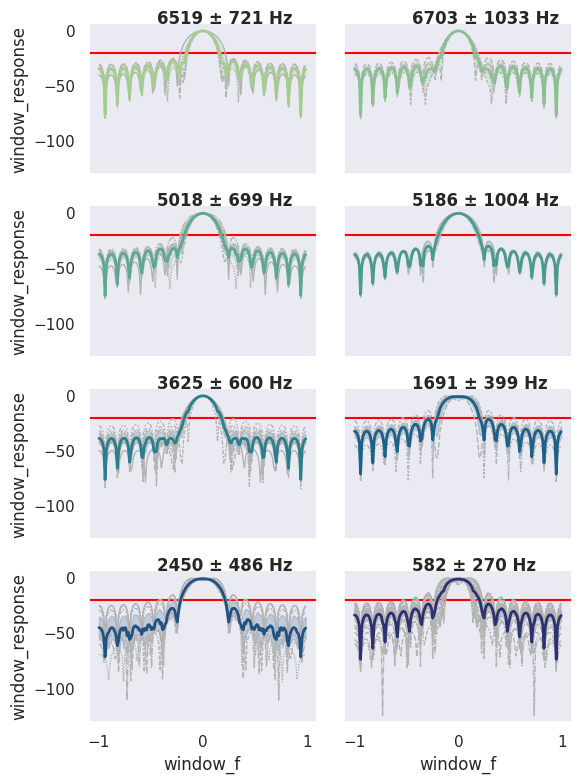

In [476]:
filtviz.visualize_filters(filter_domain='freq')

In [477]:
del model
gc.collect()

9133

In [478]:
model = M10(config=model_config,
           n_input=1, n_output=2)
model

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirWinConv()
        (norm): CustomNormLayer(
          (layer): GroupNorm(2, 64, eps=1e-05, affine=True)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [479]:
n_epoch = 100
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [480]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                                                           | 0.02702702702702703/100 [00:00<29:59, 18.00s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.694683


  1%|▊                                                                           | 0.9999999999999991/100 [00:16<24:04, 14.59s/it]


Test Epoch: 1	Accuracy: 148/229 (65%)



  1%|▊                                                                            | 1.027027027027026/100 [00:16<26:12, 15.89s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.794156


  2%|█▌                                                                          | 1.9999999999999971/100 [00:32<23:49, 14.59s/it]


Test Epoch: 2	Accuracy: 149/229 (65%)



  2%|█▌                                                                           | 2.027027027027024/100 [00:33<25:26, 15.58s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.619153


  3%|██▎                                                                          | 3.000000000000003/100 [00:49<24:00, 14.85s/it]


Test Epoch: 3	Accuracy: 149/229 (65%)



  3%|██▎                                                                         | 3.0270270270270303/100 [00:49<25:15, 15.63s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.417003


  4%|███                                                                          | 4.000000000000009/100 [01:05<23:39, 14.78s/it]


Test Epoch: 4	Accuracy: 148/229 (65%)



  4%|███                                                                          | 4.027027027027036/100 [01:06<25:00, 15.63s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.532741


  5%|███▊                                                                         | 5.000000000000015/100 [01:22<22:41, 14.33s/it]


Test Epoch: 5	Accuracy: 159/229 (69%)



  5%|███▊                                                                         | 5.027027027027042/100 [01:22<24:13, 15.30s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.438994


  6%|████▌                                                                        | 6.000000000000021/100 [01:38<22:38, 14.46s/it]


Test Epoch: 6	Accuracy: 164/229 (72%)



  6%|████▌                                                                       | 6.0270270270270485/100 [01:39<31:40, 20.22s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.503927


  7%|█████▎                                                                      | 7.0000000000000275/100 [01:55<22:34, 14.56s/it]


Test Epoch: 7	Accuracy: 159/229 (69%)



  7%|█████▍                                                                       | 7.027027027027055/100 [01:56<24:01, 15.50s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.508243


  8%|██████▏                                                                      | 8.000000000000034/100 [02:12<22:45, 14.84s/it]


Test Epoch: 8	Accuracy: 156/229 (68%)



  8%|██████▎                                                                       | 8.02702702702706/100 [02:13<24:02, 15.68s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.565765


  9%|██████▉                                                                      | 9.000000000000007/100 [02:29<21:59, 14.50s/it]


Test Epoch: 9	Accuracy: 165/229 (72%)



  9%|██████▉                                                                      | 9.027027027027033/100 [02:29<23:19, 15.38s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.492777


 10%|███████▊                                                                      | 9.99999999999998/100 [02:45<21:51, 14.57s/it]


Test Epoch: 10	Accuracy: 165/229 (72%)



 10%|███████▌                                                                    | 10.027027027027007/100 [02:46<23:13, 15.49s/it]

Train Epoch: 11 [0/913 (0%)]	Loss: 0.485302


 11%|████████▎                                                                   | 10.999999999999954/100 [03:02<21:26, 14.46s/it]


Test Epoch: 11	Accuracy: 172/229 (75%)



 11%|████████▍                                                                    | 11.02702702702698/100 [03:02<22:50, 15.40s/it]

Train Epoch: 12 [0/913 (0%)]	Loss: 0.692017


 12%|█████████                                                                   | 11.999999999999927/100 [03:20<26:12, 17.87s/it]


Test Epoch: 12	Accuracy: 165/229 (72%)



 12%|█████████▏                                                                  | 12.027027027026953/100 [03:20<26:01, 17.75s/it]

Train Epoch: 13 [0/913 (0%)]	Loss: 0.518817


 13%|██████████▏                                                                   | 12.9999999999999/100 [03:36<21:04, 14.54s/it]


Test Epoch: 13	Accuracy: 174/229 (76%)



 13%|█████████▉                                                                  | 13.027027027026927/100 [03:37<22:32, 15.55s/it]

Train Epoch: 14 [0/913 (0%)]	Loss: 0.738367


 14%|██████████▋                                                                 | 13.999999999999874/100 [03:53<20:46, 14.50s/it]


Test Epoch: 14	Accuracy: 170/229 (74%)



 14%|██████████▉                                                                   | 14.0270270270269/100 [03:54<22:37, 15.79s/it]

Train Epoch: 15 [0/913 (0%)]	Loss: 0.278659


 15%|███████████▍                                                                | 14.999999999999847/100 [04:10<20:53, 14.75s/it]


Test Epoch: 15	Accuracy: 181/229 (79%)



 15%|███████████▍                                                                | 15.027027027026874/100 [04:11<22:06, 15.61s/it]

Train Epoch: 16 [0/913 (0%)]	Loss: 0.435823


 16%|████████████▎                                                                | 15.99999999999982/100 [04:27<20:12, 14.43s/it]


Test Epoch: 16	Accuracy: 183/229 (80%)



 16%|████████████▏                                                               | 16.027027027026847/100 [04:27<21:39, 15.48s/it]

Train Epoch: 17 [0/913 (0%)]	Loss: 0.534622


 17%|████████████▉                                                               | 16.999999999999858/100 [04:44<20:35, 14.89s/it]


Test Epoch: 17	Accuracy: 182/229 (79%)



 17%|████████████▉                                                               | 17.027027027026886/100 [04:44<21:34, 15.61s/it]

Train Epoch: 18 [0/913 (0%)]	Loss: 0.394008


 18%|█████████████▋                                                              | 17.999999999999897/100 [05:00<20:04, 14.69s/it]


Test Epoch: 18	Accuracy: 162/229 (71%)



 18%|█████████████▋                                                              | 18.027027027026925/100 [05:01<21:08, 15.48s/it]

Train Epoch: 19 [0/913 (0%)]	Loss: 0.483350


 19%|██████████████▍                                                             | 18.999999999999936/100 [05:17<19:45, 14.63s/it]


Test Epoch: 19	Accuracy: 161/229 (70%)



 19%|██████████████▍                                                             | 19.027027027026964/100 [05:17<21:02, 15.59s/it]

Train Epoch: 20 [0/913 (0%)]	Loss: 0.732394


 20%|███████████████▏                                                            | 19.999999999999975/100 [05:34<19:25, 14.56s/it]


Test Epoch: 20	Accuracy: 174/229 (76%)



 20%|███████████████▏                                                            | 20.027027027027003/100 [05:34<20:31, 15.40s/it]

Train Epoch: 21 [0/913 (0%)]	Loss: 0.392602


 21%|███████████████▉                                                            | 21.000000000000014/100 [05:51<19:11, 14.57s/it]


Test Epoch: 21	Accuracy: 123/229 (54%)



 21%|███████████████▉                                                            | 21.027027027027042/100 [05:51<20:28, 15.55s/it]

Train Epoch: 22 [0/913 (0%)]	Loss: 0.848820


 22%|████████████████▋                                                           | 22.000000000000053/100 [06:08<20:51, 16.04s/it]


Test Epoch: 22	Accuracy: 189/229 (83%)



 22%|████████████████▉                                                            | 22.02702702702708/100 [06:08<21:20, 16.42s/it]

Train Epoch: 23 [0/913 (0%)]	Loss: 0.337239


 23%|█████████████████▍                                                          | 23.000000000000092/100 [06:24<18:41, 14.56s/it]


Test Epoch: 23	Accuracy: 164/229 (72%)



 23%|█████████████████▋                                                           | 23.02702702702712/100 [06:25<19:43, 15.37s/it]

Train Epoch: 24 [0/913 (0%)]	Loss: 0.665422


 24%|██████████████████▍                                                          | 24.00000000000013/100 [06:41<18:44, 14.80s/it]


Test Epoch: 24	Accuracy: 176/229 (77%)



 24%|██████████████████▌                                                          | 24.02702702702716/100 [06:42<19:49, 15.65s/it]

Train Epoch: 25 [0/913 (0%)]	Loss: 0.530886


 25%|███████████████████▎                                                         | 25.00000000000017/100 [06:58<18:02, 14.43s/it]


Test Epoch: 25	Accuracy: 151/229 (66%)



 25%|███████████████████▌                                                          | 25.0270270270272/100 [06:58<19:16, 15.42s/it]

Train Epoch: 26 [0/913 (0%)]	Loss: 0.716577


 26%|████████████████████                                                         | 26.00000000000021/100 [07:15<17:59, 14.59s/it]


Test Epoch: 26	Accuracy: 178/229 (78%)



 26%|███████████████████▊                                                        | 26.027027027027238/100 [07:16<19:05, 15.49s/it]

Train Epoch: 27 [0/913 (0%)]	Loss: 0.422798


 27%|████████████████████▊                                                        | 27.00000000000025/100 [07:32<17:36, 14.47s/it]


Test Epoch: 27	Accuracy: 180/229 (79%)



 27%|████████████████████▌                                                       | 27.027027027027277/100 [07:32<18:58, 15.61s/it]

Train Epoch: 28 [0/913 (0%)]	Loss: 0.429780


 28%|█████████████████████▎                                                      | 28.000000000000288/100 [07:49<17:27, 14.56s/it]


Test Epoch: 28	Accuracy: 183/229 (80%)



 28%|█████████████████████▎                                                      | 28.027027027027316/100 [07:49<18:32, 15.46s/it]

Train Epoch: 29 [0/913 (0%)]	Loss: 0.549478


 29%|██████████████████████                                                      | 29.000000000000327/100 [08:05<17:30, 14.80s/it]


Test Epoch: 29	Accuracy: 164/229 (72%)



 29%|██████████████████████                                                      | 29.027027027027355/100 [08:06<18:32, 15.67s/it]

Train Epoch: 30 [0/913 (0%)]	Loss: 0.371986


 30%|██████████████████████▊                                                     | 30.000000000000366/100 [08:22<17:07, 14.68s/it]


Test Epoch: 30	Accuracy: 184/229 (80%)



 30%|██████████████████████▊                                                     | 30.027027027027394/100 [08:23<18:09, 15.57s/it]

Train Epoch: 31 [0/913 (0%)]	Loss: 0.327617


 31%|███████████████████████▌                                                    | 31.000000000000405/100 [08:39<19:18, 16.79s/it]


Test Epoch: 31	Accuracy: 159/229 (69%)



 31%|███████████████████████▌                                                    | 31.027027027027433/100 [08:40<19:34, 17.03s/it]

Train Epoch: 32 [0/913 (0%)]	Loss: 0.715923


 32%|████████████████████████▋                                                    | 32.00000000000044/100 [08:56<16:20, 14.42s/it]


Test Epoch: 32	Accuracy: 181/229 (79%)



 32%|████████████████████████▎                                                   | 32.027027027027465/100 [08:57<17:24, 15.36s/it]

Train Epoch: 33 [0/913 (0%)]	Loss: 0.811090


 33%|█████████████████████████▍                                                   | 33.00000000000035/100 [09:13<16:27, 14.74s/it]


Test Epoch: 33	Accuracy: 171/229 (75%)



 33%|█████████████████████████▍                                                   | 33.02702702702737/100 [09:13<17:23, 15.58s/it]

Train Epoch: 34 [0/913 (0%)]	Loss: 0.525832


 34%|█████████████████████████▊                                                  | 34.000000000000256/100 [09:30<16:11, 14.73s/it]


Test Epoch: 34	Accuracy: 170/229 (74%)



 34%|██████████████████████████▏                                                  | 34.02702702702728/100 [09:30<17:08, 15.59s/it]

Train Epoch: 35 [0/913 (0%)]	Loss: 0.462987


 35%|██████████████████████████▉                                                  | 35.00000000000016/100 [09:46<15:46, 14.56s/it]


Test Epoch: 35	Accuracy: 181/229 (79%)



 35%|██████████████████████████▉                                                  | 35.02702702702719/100 [09:47<16:48, 15.52s/it]

Train Epoch: 36 [0/913 (0%)]	Loss: 0.425569


 36%|███████████████████████████▋                                                 | 36.00000000000007/100 [10:03<15:20, 14.38s/it]


Test Epoch: 36	Accuracy: 189/229 (83%)



 36%|███████████████████████████▍                                                | 36.027027027027096/100 [10:04<16:23, 15.37s/it]

Train Epoch: 37 [0/913 (0%)]	Loss: 0.246497


 37%|████████████████████████████▍                                                | 36.99999999999998/100 [10:20<15:01, 14.32s/it]


Test Epoch: 37	Accuracy: 174/229 (76%)



 37%|█████████████████████████████▎                                                 | 37.027027027027/100 [10:20<16:03, 15.31s/it]

Train Epoch: 38 [0/913 (0%)]	Loss: 0.336146


 38%|████████████████████████████▉                                               | 37.999999999999886/100 [10:37<14:50, 14.36s/it]


Test Epoch: 38	Accuracy: 173/229 (76%)



 38%|█████████████████████████████▎                                               | 38.02702702702691/100 [10:37<15:56, 15.44s/it]

Train Epoch: 39 [0/913 (0%)]	Loss: 0.820207


 39%|█████████████████████████████▋                                              | 38.999999999999794/100 [10:54<15:01, 14.78s/it]


Test Epoch: 39	Accuracy: 180/229 (79%)



 39%|██████████████████████████████                                               | 39.02702702702682/100 [10:54<15:52, 15.62s/it]

Train Epoch: 40 [0/913 (0%)]	Loss: 0.331211


 40%|███████████████████████████████▏                                              | 39.9999999999997/100 [11:11<16:13, 16.23s/it]


Test Epoch: 40	Accuracy: 188/229 (82%)



 40%|██████████████████████████████▍                                             | 40.027027027026726/100 [11:11<16:31, 16.53s/it]

Train Epoch: 41 [0/913 (0%)]	Loss: 0.398635


 41%|███████████████████████████████▌                                             | 40.99999999999961/100 [11:27<14:11, 14.43s/it]


Test Epoch: 41	Accuracy: 105/229 (46%)



 41%|███████████████████████████████▏                                            | 41.027027027026634/100 [11:28<15:10, 15.45s/it]

Train Epoch: 42 [0/913 (0%)]	Loss: 0.817943


 42%|████████████████████████████████▎                                            | 41.99999999999952/100 [11:44<14:23, 14.89s/it]


Test Epoch: 42	Accuracy: 193/229 (84%)



 42%|████████████████████████████████▎                                            | 42.02702702702654/100 [11:45<15:11, 15.72s/it]

Train Epoch: 43 [0/913 (0%)]	Loss: 0.375013


 43%|████████████████████████████████▋                                           | 42.999999999999424/100 [12:01<13:50, 14.57s/it]


Test Epoch: 43	Accuracy: 179/229 (78%)



 43%|█████████████████████████████████▏                                           | 43.02702702702645/100 [12:01<14:43, 15.51s/it]

Train Epoch: 44 [0/913 (0%)]	Loss: 0.318368


 44%|█████████████████████████████████▉                                           | 43.99999999999933/100 [12:17<13:33, 14.53s/it]


Test Epoch: 44	Accuracy: 165/229 (72%)



 44%|█████████████████████████████████▉                                           | 44.02702702702636/100 [12:18<14:33, 15.61s/it]

Train Epoch: 45 [0/913 (0%)]	Loss: 0.546671


 45%|██████████████████████████████████▋                                          | 44.99999999999924/100 [12:34<13:19, 14.54s/it]


Test Epoch: 45	Accuracy: 193/229 (84%)



 45%|██████████████████████████████████▏                                         | 45.027027027026264/100 [12:35<14:13, 15.53s/it]

Train Epoch: 46 [0/913 (0%)]	Loss: 0.366808


 46%|███████████████████████████████████▍                                         | 45.99999999999915/100 [12:51<13:03, 14.50s/it]


Test Epoch: 46	Accuracy: 194/229 (85%)



 46%|███████████████████████████████████▍                                         | 46.02702702702617/100 [12:51<13:53, 15.45s/it]

Train Epoch: 47 [0/913 (0%)]	Loss: 0.283064


 47%|███████████████████████████████████▋                                        | 46.999999999999055/100 [13:07<13:07, 14.86s/it]


Test Epoch: 47	Accuracy: 180/229 (79%)



 47%|████████████████████████████████████▏                                        | 47.02702702702608/100 [13:08<13:51, 15.69s/it]

Train Epoch: 48 [0/913 (0%)]	Loss: 0.435711


 48%|████████████████████████████████████▉                                        | 47.99999999999896/100 [13:24<12:34, 14.50s/it]


Test Epoch: 48	Accuracy: 175/229 (76%)



 48%|████████████████████████████████████▉                                        | 48.02702702702599/100 [13:25<13:16, 15.33s/it]

Train Epoch: 49 [0/913 (0%)]	Loss: 0.383175


 49%|█████████████████████████████████████▋                                       | 48.99999999999887/100 [13:41<13:46, 16.21s/it]


Test Epoch: 49	Accuracy: 156/229 (68%)



 49%|█████████████████████████████████████▎                                      | 49.027027027025895/100 [13:41<14:02, 16.53s/it]

Train Epoch: 50 [0/913 (0%)]	Loss: 0.795920


 50%|██████████████████████████████████████▍                                      | 49.99999999999878/100 [13:58<12:20, 14.80s/it]


Test Epoch: 50	Accuracy: 196/229 (86%)



 50%|███████████████████████████████████████                                       | 50.0270270270258/100 [13:58<13:01, 15.64s/it]

Train Epoch: 51 [0/913 (0%)]	Loss: 0.341401


 51%|██████████████████████████████████████▊                                     | 50.999999999998685/100 [14:15<12:15, 15.01s/it]


Test Epoch: 51	Accuracy: 96/229 (42%)



 51%|███████████████████████████████████████▎                                     | 51.02702702702571/100 [14:15<12:48, 15.68s/it]

Train Epoch: 52 [0/913 (0%)]	Loss: 1.504960


 52%|████████████████████████████████████████                                     | 51.99999999999859/100 [14:31<11:36, 14.50s/it]


Test Epoch: 52	Accuracy: 186/229 (81%)



 52%|████████████████████████████████████████                                     | 52.02702702702562/100 [14:32<12:20, 15.43s/it]

Train Epoch: 53 [0/913 (0%)]	Loss: 0.412287


 53%|█████████████████████████████████████████▎                                    | 52.9999999999985/100 [14:48<11:15, 14.38s/it]


Test Epoch: 53	Accuracy: 184/229 (80%)



 53%|████████████████████████████████████████▎                                   | 53.027027027025525/100 [14:48<12:02, 15.38s/it]

Train Epoch: 54 [0/913 (0%)]	Loss: 0.572656


 54%|█████████████████████████████████████████▌                                   | 53.99999999999841/100 [15:05<11:07, 14.50s/it]


Test Epoch: 54	Accuracy: 188/229 (82%)



 54%|█████████████████████████████████████████▌                                   | 54.02702702702543/100 [15:05<11:56, 15.59s/it]

Train Epoch: 55 [0/913 (0%)]	Loss: 0.323810


 55%|█████████████████████████████████████████▊                                  | 54.999999999998316/100 [15:22<10:54, 14.54s/it]


Test Epoch: 55	Accuracy: 180/229 (79%)



 55%|██████████████████████████████████████████▎                                  | 55.02702702702534/100 [15:22<11:52, 15.84s/it]

Train Epoch: 56 [0/913 (0%)]	Loss: 0.676524


 56%|██████████████████████████████████████████▌                                 | 55.999999999998224/100 [15:38<10:33, 14.40s/it]


Test Epoch: 56	Accuracy: 187/229 (82%)



 56%|███████████████████████████████████████████▏                                 | 56.02702702702525/100 [15:39<11:15, 15.37s/it]

Train Epoch: 57 [0/913 (0%)]	Loss: 0.249453


 57%|███████████████████████████████████████████▉                                 | 56.99999999999813/100 [15:55<10:21, 14.45s/it]


Test Epoch: 57	Accuracy: 169/229 (74%)



 57%|███████████████████████████████████████████▎                                | 57.027027027025156/100 [15:55<11:01, 15.39s/it]

Train Epoch: 58 [0/913 (0%)]	Loss: 0.311443


 58%|████████████████████████████████████████████▋                                | 57.99999999999804/100 [16:12<10:13, 14.60s/it]


Test Epoch: 58	Accuracy: 187/229 (82%)



 58%|████████████████████████████████████████████▋                                | 58.02702702702506/100 [16:12<10:59, 15.71s/it]

Train Epoch: 59 [0/913 (0%)]	Loss: 0.278807


 59%|█████████████████████████████████████████████▍                               | 58.99999999999795/100 [16:28<10:00, 14.65s/it]


Test Epoch: 59	Accuracy: 159/229 (69%)



 59%|█████████████████████████████████████████████▍                               | 59.02702702702497/100 [16:29<10:37, 15.57s/it]

Train Epoch: 60 [0/913 (0%)]	Loss: 0.710041


 60%|█████████████████████████████████████████████▌                              | 59.999999999997854/100 [16:45<09:37, 14.43s/it]


Test Epoch: 60	Accuracy: 179/229 (78%)



 60%|██████████████████████████████████████████████▏                              | 60.02702702702488/100 [16:46<10:23, 15.61s/it]

Train Epoch: 61 [0/913 (0%)]	Loss: 0.988713


 61%|██████████████████████████████████████████████▉                              | 60.99999999999776/100 [17:02<09:22, 14.42s/it]


Test Epoch: 61	Accuracy: 194/229 (85%)



 61%|██████████████████████████████████████████████▍                             | 61.027027027024786/100 [17:02<10:07, 15.58s/it]

Train Epoch: 62 [0/913 (0%)]	Loss: 0.320325


 62%|███████████████████████████████████████████████▋                             | 61.99999999999767/100 [17:19<09:11, 14.52s/it]


Test Epoch: 62	Accuracy: 170/229 (74%)



 62%|███████████████████████████████████████████████▏                            | 62.027027027024694/100 [17:19<09:47, 15.46s/it]

Train Epoch: 63 [0/913 (0%)]	Loss: 0.364792


 63%|████████████████████████████████████████████████▌                            | 62.99999999999758/100 [17:35<08:55, 14.48s/it]


Test Epoch: 63	Accuracy: 155/229 (68%)



 63%|█████████████████████████████████████████████████▏                            | 63.0270270270246/100 [17:36<09:32, 15.49s/it]

Train Epoch: 64 [0/913 (0%)]	Loss: 0.375325


 64%|████████████████████████████████████████████████▋                           | 63.999999999997485/100 [17:52<08:50, 14.72s/it]


Test Epoch: 64	Accuracy: 189/229 (83%)



 64%|█████████████████████████████████████████████████▎                           | 64.02702702702452/100 [17:53<09:21, 15.61s/it]

Train Epoch: 65 [0/913 (0%)]	Loss: 0.494540


 65%|██████████████████████████████████████████████████                           | 64.99999999999766/100 [18:09<08:33, 14.66s/it]


Test Epoch: 65	Accuracy: 184/229 (80%)



 65%|██████████████████████████████████████████████████                           | 65.02702702702469/100 [18:10<09:00, 15.45s/it]

Train Epoch: 66 [0/913 (0%)]	Loss: 0.358542


 66%|██████████████████████████████████████████████████▊                          | 65.99999999999783/100 [18:26<08:10, 14.42s/it]


Test Epoch: 66	Accuracy: 194/229 (85%)



 66%|██████████████████████████████████████████████████▊                          | 66.02702702702486/100 [18:26<08:43, 15.42s/it]

Train Epoch: 67 [0/913 (0%)]	Loss: 0.426967


 67%|████████████████████████████████████████████████████▉                          | 66.999999999998/100 [18:42<07:58, 14.51s/it]


Test Epoch: 67	Accuracy: 169/229 (74%)



 67%|███████████████████████████████████████████████████▌                         | 67.02702702702503/100 [18:43<08:29, 15.46s/it]

Train Epoch: 68 [0/913 (0%)]	Loss: 0.482458


 68%|████████████████████████████████████████████████████▎                        | 67.99999999999817/100 [18:59<07:44, 14.53s/it]


Test Epoch: 68	Accuracy: 128/229 (56%)



 68%|█████████████████████████████████████████████████████                         | 68.0270270270252/100 [19:00<08:16, 15.52s/it]

Train Epoch: 69 [0/913 (0%)]	Loss: 0.545180


 69%|█████████████████████████████████████████████████████▏                       | 68.99999999999834/100 [19:16<07:44, 14.99s/it]


Test Epoch: 69	Accuracy: 176/229 (77%)



 69%|█████████████████████████████████████████████████████▏                       | 69.02702702702537/100 [19:16<08:10, 15.83s/it]

Train Epoch: 70 [0/913 (0%)]	Loss: 0.367935


 70%|█████████████████████████████████████████████████████▉                       | 69.99999999999851/100 [19:33<07:21, 14.73s/it]


Test Epoch: 70	Accuracy: 161/229 (70%)



 70%|█████████████████████████████████████████████████████▉                       | 70.02702702702554/100 [19:33<07:44, 15.49s/it]

Train Epoch: 71 [0/913 (0%)]	Loss: 0.454608


 71%|██████████████████████████████████████████████████████▋                      | 70.99999999999868/100 [19:49<07:03, 14.62s/it]


Test Epoch: 71	Accuracy: 170/229 (74%)



 71%|██████████████████████████████████████████████████████▋                      | 71.02702702702571/100 [19:50<07:34, 15.67s/it]

Train Epoch: 72 [0/913 (0%)]	Loss: 1.163037


 72%|███████████████████████████████████████████████████████▍                     | 71.99999999999885/100 [20:06<06:46, 14.52s/it]


Test Epoch: 72	Accuracy: 150/229 (66%)



 72%|███████████████████████████████████████████████████████▍                     | 72.02702702702588/100 [20:07<07:09, 15.35s/it]

Train Epoch: 73 [0/913 (0%)]	Loss: 0.498128


 73%|████████████████████████████████████████████████████████▏                    | 72.99999999999902/100 [20:23<06:36, 14.67s/it]


Test Epoch: 73	Accuracy: 96/229 (42%)



 73%|████████████████████████████████████████████████████████▏                    | 73.02702702702605/100 [20:23<07:02, 15.67s/it]

Train Epoch: 74 [0/913 (0%)]	Loss: 2.634974


 74%|████████████████████████████████████████████████████████▉                    | 73.99999999999919/100 [20:40<06:22, 14.71s/it]


Test Epoch: 74	Accuracy: 186/229 (81%)



 74%|█████████████████████████████████████████████████████████                    | 74.02702702702622/100 [20:40<06:44, 15.59s/it]

Train Epoch: 75 [0/913 (0%)]	Loss: 0.411276


 75%|█████████████████████████████████████████████████████████▋                   | 74.99999999999936/100 [20:57<06:12, 14.92s/it]


Test Epoch: 75	Accuracy: 157/229 (69%)



 75%|█████████████████████████████████████████████████████████▊                   | 75.02702702702639/100 [20:57<06:30, 15.64s/it]

Train Epoch: 76 [0/913 (0%)]	Loss: 0.719804


 76%|██████████████████████████████████████████████████████████▌                  | 75.99999999999953/100 [21:13<05:47, 14.47s/it]


Test Epoch: 76	Accuracy: 194/229 (85%)



 76%|██████████████████████████████████████████████████████████▌                  | 76.02702702702656/100 [21:14<06:11, 15.50s/it]

Train Epoch: 77 [0/913 (0%)]	Loss: 0.450068


 77%|████████████████████████████████████████████████████████████                  | 76.9999999999997/100 [21:30<05:35, 14.57s/it]


Test Epoch: 77	Accuracy: 187/229 (82%)



 77%|███████████████████████████████████████████████████████████▎                 | 77.02702702702673/100 [21:30<05:57, 15.58s/it]

Train Epoch: 78 [0/913 (0%)]	Loss: 0.370329


 78%|████████████████████████████████████████████████████████████                 | 77.99999999999987/100 [21:47<05:55, 16.18s/it]


Test Epoch: 78	Accuracy: 164/229 (72%)



 78%|████████████████████████████████████████████████████████████▊                 | 78.0270270270269/100 [21:47<06:04, 16.60s/it]

Train Epoch: 79 [0/913 (0%)]	Loss: 0.549053


 79%|████████████████████████████████████████████████████████████▊                | 79.00000000000004/100 [22:03<05:05, 14.56s/it]


Test Epoch: 79	Accuracy: 182/229 (79%)



 79%|████████████████████████████████████████████████████████████▊                | 79.02702702702707/100 [22:04<05:23, 15.40s/it]

Train Epoch: 80 [0/913 (0%)]	Loss: 0.550361


 80%|█████████████████████████████████████████████████████████████▌               | 80.00000000000021/100 [22:20<04:51, 14.58s/it]


Test Epoch: 80	Accuracy: 180/229 (79%)



 80%|█████████████████████████████████████████████████████████████▌               | 80.02702702702724/100 [22:21<05:10, 15.53s/it]

Train Epoch: 81 [0/913 (0%)]	Loss: 0.456769


 81%|██████████████████████████████████████████████████████████████▎              | 81.00000000000038/100 [22:37<04:33, 14.42s/it]


Test Epoch: 81	Accuracy: 169/229 (74%)



 81%|██████████████████████████████████████████████████████████████▍              | 81.02702702702742/100 [22:37<04:55, 15.55s/it]

Train Epoch: 82 [0/913 (0%)]	Loss: 0.419027


 82%|███████████████████████████████████████████████████████████████▏             | 82.00000000000055/100 [22:54<04:18, 14.38s/it]


Test Epoch: 82	Accuracy: 177/229 (77%)



 82%|███████████████████████████████████████████████████████████████▏             | 82.02702702702759/100 [22:54<04:42, 15.74s/it]

Train Epoch: 83 [0/913 (0%)]	Loss: 0.724038


 83%|███████████████████████████████████████████████████████████████▉             | 83.00000000000072/100 [23:10<04:07, 14.56s/it]


Test Epoch: 83	Accuracy: 116/229 (51%)



 83%|███████████████████████████████████████████████████████████████▉             | 83.02702702702776/100 [23:11<04:23, 15.52s/it]

Train Epoch: 84 [0/913 (0%)]	Loss: 0.599074


 84%|█████████████████████████████████████████████████████████████████▌            | 84.0000000000009/100 [23:27<03:54, 14.65s/it]


Test Epoch: 84	Accuracy: 193/229 (84%)



 84%|████████████████████████████████████████████████████████████████▋            | 84.02702702702793/100 [23:28<04:06, 15.43s/it]

Train Epoch: 85 [0/913 (0%)]	Loss: 0.321115


 85%|█████████████████████████████████████████████████████████████████▍           | 85.00000000000107/100 [23:44<03:36, 14.46s/it]


Test Epoch: 85	Accuracy: 189/229 (83%)



 85%|██████████████████████████████████████████████████████████████████▎           | 85.0270270270281/100 [23:45<03:52, 15.52s/it]

Train Epoch: 86 [0/913 (0%)]	Loss: 0.428740


 86%|██████████████████████████████████████████████████████████████████▏          | 86.00000000000124/100 [24:01<03:20, 14.36s/it]


Test Epoch: 86	Accuracy: 147/229 (64%)



 86%|██████████████████████████████████████████████████████████████████▏          | 86.02702702702827/100 [24:02<03:34, 15.37s/it]

Train Epoch: 87 [0/913 (0%)]	Loss: 0.511359


 87%|███████████████████████████████████████████████████████████████████▊          | 87.0000000000014/100 [24:18<03:13, 14.86s/it]


Test Epoch: 87	Accuracy: 194/229 (85%)



 87%|███████████████████████████████████████████████████████████████████          | 87.02702702702844/100 [24:19<03:24, 15.75s/it]

Train Epoch: 88 [0/913 (0%)]	Loss: 0.328954


 88%|███████████████████████████████████████████████████████████████████▊         | 88.00000000000158/100 [24:35<02:52, 14.37s/it]


Test Epoch: 88	Accuracy: 191/229 (83%)



 88%|███████████████████████████████████████████████████████████████████▊         | 88.02702702702861/100 [24:35<03:04, 15.45s/it]

Train Epoch: 89 [0/913 (0%)]	Loss: 0.470087


 89%|████████████████████████████████████████████████████████████████████▌        | 89.00000000000175/100 [24:52<02:38, 14.42s/it]


Test Epoch: 89	Accuracy: 144/229 (63%)



 89%|████████████████████████████████████████████████████████████████████▌        | 89.02702702702878/100 [24:52<02:49, 15.45s/it]

Train Epoch: 90 [0/913 (0%)]	Loss: 0.633055


 90%|█████████████████████████████████████████████████████████████████████▎       | 90.00000000000192/100 [25:09<02:24, 14.48s/it]


Test Epoch: 90	Accuracy: 196/229 (86%)



 90%|█████████████████████████████████████████████████████████████████████▎       | 90.02702702702895/100 [25:09<02:32, 15.30s/it]

Train Epoch: 91 [0/913 (0%)]	Loss: 0.497745


 91%|██████████████████████████████████████████████████████████████████████       | 91.00000000000209/100 [25:25<02:09, 14.38s/it]


Test Epoch: 91	Accuracy: 181/229 (79%)



 91%|██████████████████████████████████████████████████████████████████████       | 91.02702702702912/100 [25:26<02:19, 15.52s/it]

Train Epoch: 92 [0/913 (0%)]	Loss: 0.528120


 92%|██████████████████████████████████████████████████████████████████████▊      | 92.00000000000226/100 [25:42<01:57, 14.65s/it]


Test Epoch: 92	Accuracy: 198/229 (86%)



 92%|██████████████████████████████████████████████████████████████████████▊      | 92.02702702702929/100 [25:42<02:04, 15.64s/it]

Train Epoch: 93 [0/913 (0%)]	Loss: 0.565661


 93%|███████████████████████████████████████████████████████████████████████▌     | 93.00000000000243/100 [25:59<01:41, 14.54s/it]


Test Epoch: 93	Accuracy: 156/229 (68%)



 93%|███████████████████████████████████████████████████████████████████████▋     | 93.02702702702946/100 [25:59<01:47, 15.45s/it]

Train Epoch: 94 [0/913 (0%)]	Loss: 0.594678


 94%|█████████████████████████████████████████████████████████████████████████▎    | 94.0000000000026/100 [26:16<01:28, 14.72s/it]


Test Epoch: 94	Accuracy: 186/229 (81%)



 94%|████████████████████████████████████████████████████████████████████████▍    | 94.02702702702963/100 [26:16<01:33, 15.73s/it]

Train Epoch: 95 [0/913 (0%)]	Loss: 0.678598


 95%|█████████████████████████████████████████████████████████████████████████▏   | 95.00000000000277/100 [26:33<01:12, 14.57s/it]


Test Epoch: 95	Accuracy: 189/229 (83%)



 95%|██████████████████████████████████████████████████████████████████████████    | 95.0270270270298/100 [26:33<01:17, 15.51s/it]

Train Epoch: 96 [0/913 (0%)]	Loss: 0.367498


 96%|█████████████████████████████████████████████████████████████████████████▉   | 96.00000000000294/100 [26:50<00:58, 14.58s/it]


Test Epoch: 96	Accuracy: 193/229 (84%)



 96%|█████████████████████████████████████████████████████████████████████████▉   | 96.02702702702997/100 [26:50<01:01, 15.46s/it]

Train Epoch: 97 [0/913 (0%)]	Loss: 0.446624


 97%|██████████████████████████████████████████████████████████████████████████▋  | 97.00000000000311/100 [27:06<00:43, 14.46s/it]


Test Epoch: 97	Accuracy: 173/229 (76%)



 97%|██████████████████████████████████████████████████████████████████████████▋  | 97.02702702703014/100 [27:07<00:46, 15.49s/it]

Train Epoch: 98 [0/913 (0%)]	Loss: 0.474395


 98%|███████████████████████████████████████████████████████████████████████████▍ | 98.00000000000328/100 [27:23<00:29, 14.75s/it]


Test Epoch: 98	Accuracy: 114/229 (50%)



 98%|███████████████████████████████████████████████████████████████████████████▍ | 98.02702702703031/100 [27:24<00:30, 15.49s/it]

Train Epoch: 99 [0/913 (0%)]	Loss: 1.302024


 99%|████████████████████████████████████████████████████████████████████████████▏| 99.00000000000345/100 [27:40<00:14, 14.63s/it]


Test Epoch: 99	Accuracy: 173/229 (76%)



 99%|████████████████████████████████████████████████████████████████████████████▎| 99.02702702703048/100 [27:40<00:15, 15.53s/it]

Train Epoch: 100 [0/913 (0%)]	Loss: 0.597762


100%|████████████████████████████████████████████████████████████████████████████▉| 99.97297297297659/100 [27:56<00:00, 14.63s/it]/opt/anaconda3/envs/audio/lib/python3.9/site-packages/tqdm/std.py:639: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|████████████████████████████████████████████████████████████████████████████| 100.00000000000362/100 [27:57<00:00, 16.77s/it]


Test Epoch: 100	Accuracy: 191/229 (83%)



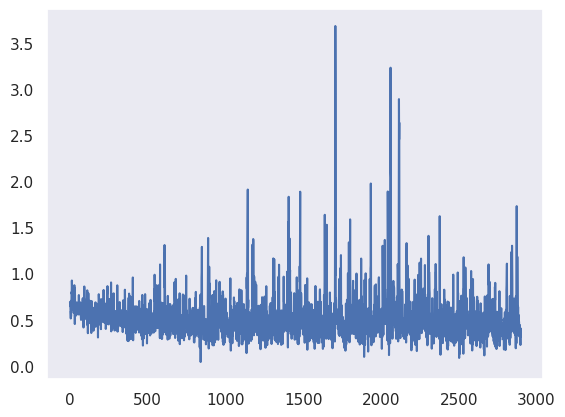

In [481]:
plt.plot(train_losses)

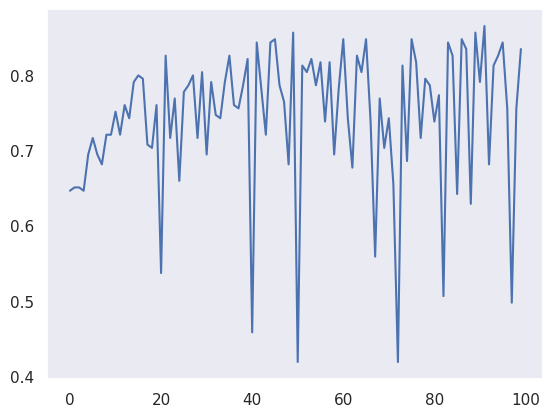

In [482]:
plt.plot(test_accuracy)

In [483]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 191/229 (0.8341)
tensor([[ 48,  33],
        [  5, 143]], device='cuda:0')


In [484]:
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 6.3133e-15],
        [-3.6467e-16],
        [-4.9727e-17],
        [-1.2643e-17],
        [ 3.0294e-17],
        [ 3.7953e-17],
        [-4.1149e-15],
        [-9.9798e-17],
        [-8.6623e-17],
        [-8.3969e-18],
        [ 6.8233e-18],
        [-1.9153e-17],
        [ 1.0758e-17],
        [-2.6826e-18],
        [ 1.3798e-18],
        [ 0.0000e+00],
        [ 4.3094e-15],
        [-3.2576e-15],
        [ 1.2759e-17],
        [ 2.1750e-18],
        [ 2.6216e-18],
        [ 4.9235e-15],
        [-1.6053e-18],
        [ 4.2840e-17],
        [-8.7548e-17],
        [ 1.9636e-17],
        [-9.6109e-19],
        [-1.0448e-16],
        [-4.4662e-18],
        [ 3.4652e-18],
        [-4.3388e-18],
        [ 0.0000e+00],
        [ 4.6332e-14],
        [ 8.4944e-18],
        [ 4.9928e-16],
        [-7.8281e-16],
        [-3.1861e-15],
        [-5.1386e-16],
        [ 6.6887e-19],
        [-1.3238e-17],
        [ 1.4023e-17],
        [-5.3000e-17],
        [-6

[None, None, None]

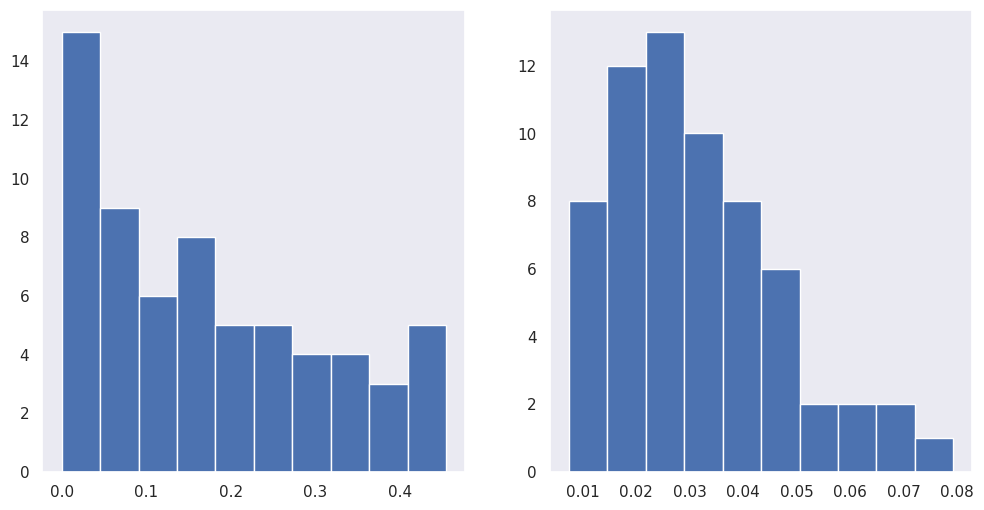

In [485]:
filtviz = visualize_model.FilterVisualizer(
    lowcut_bands = layer.lowcut_bands, 
    bandwidths = layer.bandwidths,
    window_params = layer.window_params, 
    window_length = 64,
    sample_rate = sr
)
filtviz.visualize_bands()

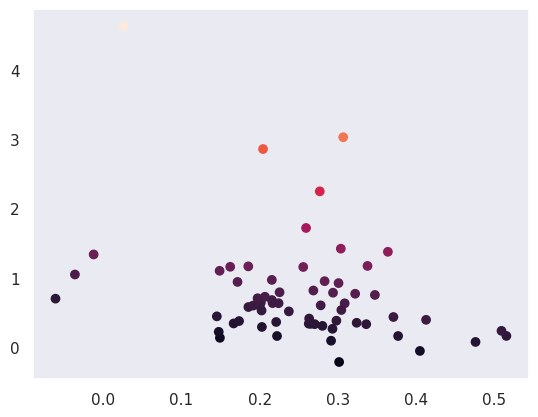

In [488]:
filtviz.visualize_window_params()

Time domain: Filters' shapes vary by frequency bins


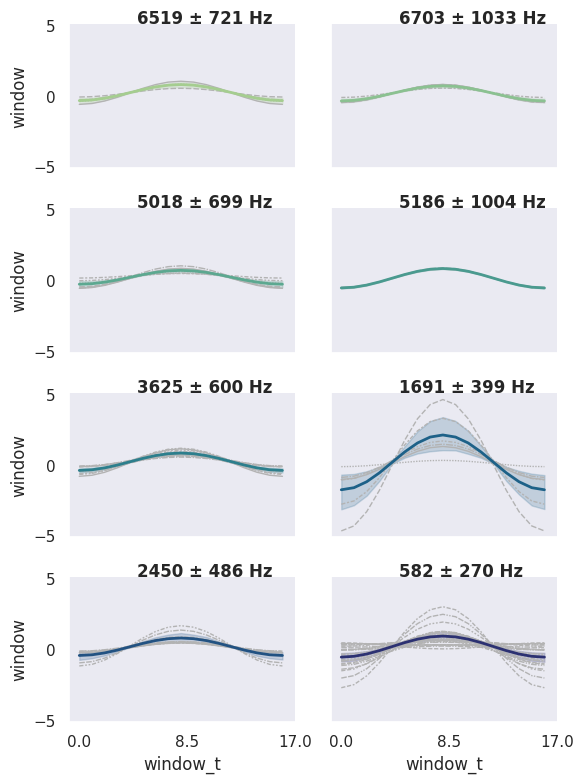

In [486]:
filtviz.visualize_filters(filter_domain='time')

Frequency domain: Filters' shapes vary by frequency bins


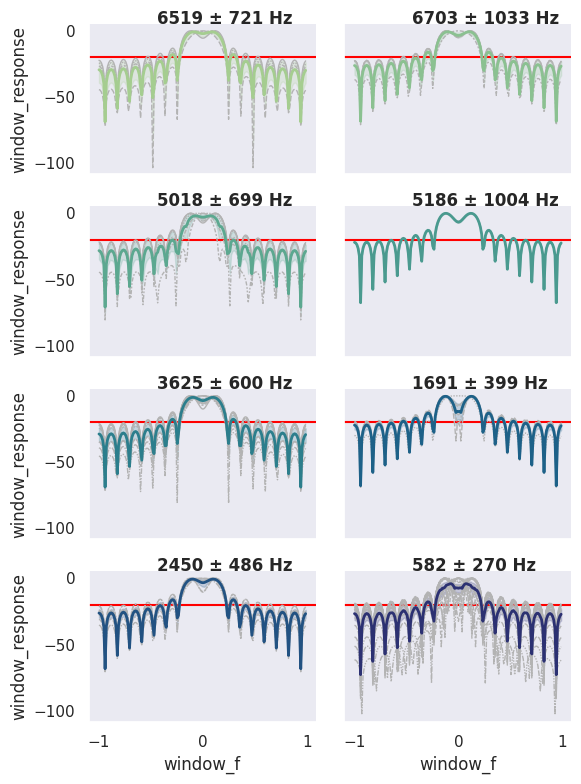

In [487]:
filtviz.visualize_filters(filter_domain='freq')

In [507]:
del model
gc.collect()

9

In [508]:
model = M10(config=model_config,
           n_input=1, n_output=2)
model

M10(
  (fe_blocks): FeBlocks(
    (blocks): ModuleList(
      (0-1): 2 x Sequential(
        (layer): FirConvLayer()
        (norm): CustomNormLayer(
          (layer): LocalResponseNorm(2, alpha=0.0001, beta=0.75, k=1.0)
        )
      )
    )
    (act): NLReLU()
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=64, out_features=256, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=256, out_features=256, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [509]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.2,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [510]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|▏                                                                           | 0.02702702702702703/10 [00:00<03:13, 19.40s/it]

Train Epoch: 1 [0/913 (0%)]	Loss: 0.656716


 10%|███████▋                                                                     | 0.9999999999999991/10 [00:18<02:18, 15.36s/it]


Test Epoch: 1	Accuracy: 148/229 (65%)



 10%|████████                                                                      | 1.027027027027026/10 [00:18<02:29, 16.68s/it]

Train Epoch: 2 [0/913 (0%)]	Loss: 0.579790


 20%|███████████████▍                                                             | 1.9999999999999971/10 [00:36<02:04, 15.50s/it]


Test Epoch: 2	Accuracy: 147/229 (64%)



 20%|███████████████▊                                                              | 2.027027027027024/10 [00:36<02:12, 16.59s/it]

Train Epoch: 3 [0/913 (0%)]	Loss: 0.527654


 30%|███████████████████████▍                                                      | 3.000000000000003/10 [00:54<01:46, 15.22s/it]


Test Epoch: 3	Accuracy: 158/229 (69%)



 30%|███████████████████████▎                                                     | 3.0270270270270303/10 [00:54<01:54, 16.37s/it]

Train Epoch: 4 [0/913 (0%)]	Loss: 0.829631


 40%|███████████████████████████████▏                                              | 4.000000000000009/10 [01:12<01:31, 15.27s/it]


Test Epoch: 4	Accuracy: 162/229 (71%)



 40%|███████████████████████████████▍                                              | 4.027027027027036/10 [01:13<01:38, 16.51s/it]

Train Epoch: 5 [0/913 (0%)]	Loss: 0.716806


 50%|███████████████████████████████████████                                       | 5.000000000000015/10 [01:31<01:17, 15.50s/it]


Test Epoch: 5	Accuracy: 157/229 (69%)



 50%|███████████████████████████████████████▏                                      | 5.027027027027042/10 [01:31<01:26, 17.38s/it]

Train Epoch: 6 [0/913 (0%)]	Loss: 0.842230


 60%|██████████████████████████████████████████████▊                               | 6.000000000000021/10 [01:50<01:01, 15.44s/it]


Test Epoch: 6	Accuracy: 172/229 (75%)



 60%|██████████████████████████████████████████████▍                              | 6.0270270270270485/10 [01:51<01:04, 16.36s/it]

Train Epoch: 7 [0/913 (0%)]	Loss: 0.490182


 70%|█████████████████████████████████████████████████████▉                       | 7.0000000000000275/10 [02:09<00:46, 15.46s/it]


Test Epoch: 7	Accuracy: 170/229 (74%)



 70%|██████████████████████████████████████████████████████▊                       | 7.027027027027055/10 [02:09<00:50, 16.92s/it]

Train Epoch: 8 [0/913 (0%)]	Loss: 0.503049


 80%|██████████████████████████████████████████████████████████████▍               | 8.000000000000034/10 [02:27<00:33, 16.99s/it]


Test Epoch: 8	Accuracy: 157/229 (69%)



 80%|███████████████████████████████████████████████████████████████▍               | 8.02702702702706/10 [02:27<00:35, 17.84s/it]

Train Epoch: 9 [0/913 (0%)]	Loss: 0.783521


 90%|██████████████████████████████████████████████████████████████████████▏       | 9.000000000000007/10 [02:45<00:15, 15.23s/it]


Test Epoch: 9	Accuracy: 152/229 (66%)



 90%|██████████████████████████████████████████████████████████████████████▍       | 9.027027027027033/10 [02:45<00:16, 16.60s/it]

Train Epoch: 10 [0/913 (0%)]	Loss: 0.561257


100%|██████████████████████████████████████████████████████████████████████████████▉| 9.99999999999998/10 [03:03<00:00, 18.34s/it]


Test Epoch: 10	Accuracy: 167/229 (73%)



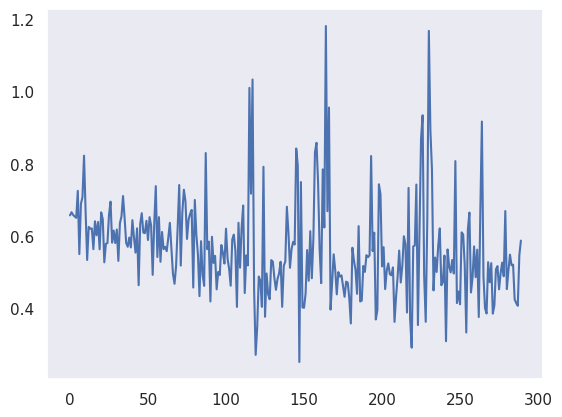

In [511]:
plt.plot(train_losses)

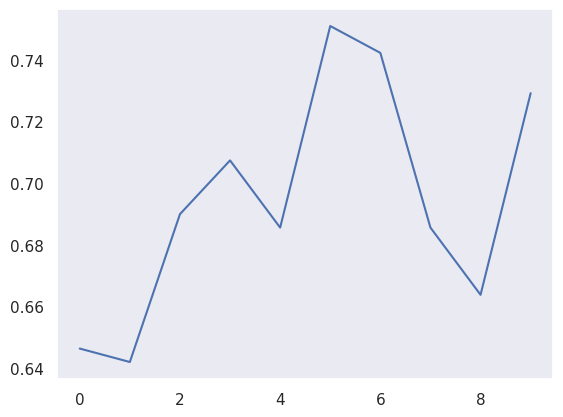

In [512]:
plt.plot(test_accuracy)

In [513]:
metric_cm = ConfusionMatrix(task='binary', num_classes=2).to(device)

model.eval()
correct = 0
for data, target in test_loader:
    data = data.to(device)
    target = target.to(device)
    output = model(data).squeeze()
    del data
    gc.collect()
    torch.cuda.empty_cache()
    probs = F.softmax(output, dim=-1)
    pred = probs.argmax(dim=-1)
    correct += pred.eq(target).sum().item()
    metric_cm(pred, target)
    del target
    gc.collect()
    torch.cuda.empty_cache()
    pbar.update(pbar_update)
print(f'Correct: {correct}/{len(test_loader.dataset)} ({correct/len(test_loader.dataset):.4f})')
cm = metric_cm.compute()
print(cm)

Correct: 167/229 (0.7293)
tensor([[ 60,  21],
        [ 41, 107]], device='cuda:0')


In [514]:
layer = model.fe_blocks.blocks[0].layer
[print(p.grad) for p in layer.parameters() if p.requires_grad]

tensor([[ 0.0000e+00],
        [ 1.2422e-14],
        [ 2.3015e-16],
        [ 1.4274e-17],
        [-1.0142e-16],
        [ 1.3605e-16],
        [ 8.2739e-16],
        [-3.9099e-16],
        [-3.9797e-16],
        [ 6.1613e-17],
        [ 2.2682e-17],
        [-5.3698e-17],
        [-2.1401e-17],
        [ 1.6942e-17],
        [ 1.8872e-18],
        [ 2.1499e-18],
        [ 0.0000e+00],
        [-8.5315e-15],
        [-4.3292e-15],
        [ 1.7117e-16],
        [-2.7891e-17],
        [ 1.0720e-18],
        [ 1.3107e-17],
        [ 1.1649e-17],
        [-4.2822e-17],
        [ 3.5894e-16],
        [-3.3532e-17],
        [-2.5360e-18],
        [-5.7115e-17],
        [-6.3209e-18],
        [ 7.5624e-18],
        [-6.7939e-18],
        [ 0.0000e+00],
        [ 1.0912e-15],
        [ 1.9439e-17],
        [ 2.9126e-16],
        [-4.8784e-15],
        [ 5.2996e-15],
        [-7.1463e-16],
        [-1.1528e-16],
        [-7.6250e-19],
        [ 3.4548e-17],
        [-1.8019e-17],
        [-2

[None, None, None]